In [1]:
'''in this version we always use the same image (times batch size)'''

'in this version we always use the same image (times batch size)'

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


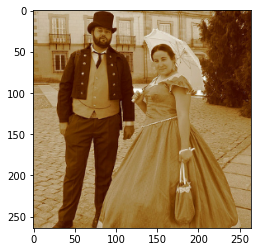

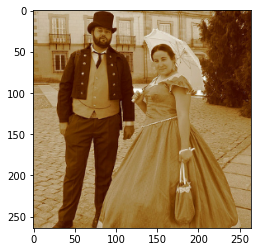

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
from imagenet_dataset import get_dataset
from retina_env import RetinaEnv, calculate_retinal_filter
from rl_networks import create_actor_model, create_critic_model, policy
from rl_core import Buffer, update_target
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from pg_core import GaussianPolicyAgent

import types
config = types.SimpleNamespace()
config.batch_size = 32
config.margin = 20
config.image_h = 224
config.image_w = 224
config.image_hm = config.image_h+2*config.margin
config.image_wm = config.image_w+2*config.margin
config.foveate = None
config.do_grayscale = True
config.history_length = 16
config.t_ignore = 16
config.t_max =50
config.motion_mode = 'velocity'
config.use_dones = False
config.fixed_image_num = 1 #this is a nice image
config.gym_mode = False
t_vec = np.linspace(0,150,16)

balanced_filter = calculate_retinal_filter(t_vec, R=1.0)
config.filter = balanced_filter.reshape([1,1,-1,1])
config.min_freq = 1
config.max_freq = 13
config.action_upper_bound = np.array([2.0, 2.0])
actor_lr = 1e-4
dataset_dir = '/home/bnapp/datasets/tensorflow_datasets/imagenet2012/5.0.0/'

def epsilon_scheduler(episode, floor_episode=200, epsilon_floor=0.1):
    if episode < floor_episode:
        return 1.-(1.-epsilon_floor)*episode/floor_episode
    else:
        return epsilon_floor

dataset = get_dataset(dataset_dir,
                                     'validation',
                                     config.batch_size,
                                     image_h = config.image_hm,
                                     image_w = config.image_wm,
                                    deterministic=True,
                                     preprocessing='identity',
                                     rggb_mode=False,
                                     central_squeeze_and_pad_factor=-1)

# env = RetinaEnv(config, image_generator=dataset)
env = RetinaEnv(config) #freezing on first batch
for images,_ in dataset:
    break
    
images = images[config.fixed_image_num].numpy()
images = np.repeat(images[np.newaxis, :, :, :], config.batch_size, axis=0)
plt.imshow(images[0])
plt.figure()
plt.imshow(images[1])
if config.gym_mode:
    num_states = env.observation_space.shape[0]
    num_actions = env.action_space.shape[0]

    upper_bound = env.action_space.high[0]
    lower_bound = env.action_space.low[0]
else:
    num_states = env.observation_size
    num_actions = env.action_size
    upper_bound = env.action_upper_bound
    lower_bound = env.action_lower_bound


actor_model = create_actor_model(env.image_h, env.image_w,
                                 env.spectral_density_size, env.location_history_size,
                                 env.timestep_size, env.action_size)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)
actor_model.optimizer = actor_optimizer
agent = GaussianPolicyAgent(std_deviation=1.0,model=actor_model)

In [3]:
# Training loop
reward_records = []
epsilon_records = []
action_mean_records = []
action_var_records = []
action_statmean_records = []
action_statvar_records = []
episodes = 10000
for ep in range(episodes):
    prev_state = env.reset(images=images)
    episodic_reward = 0
    states, actions, rewards = [], [], []

#     epsilon = epsilon_scheduler(ep, floor_episode=1000)

    while True:

        deterministic_action, means,stdevs = agent.get_action(env.unflatten_observation(prev_state),
                                               return_stats=True)
        action = deterministic_action #hook in order to add noise if neccessary
        state, reward, done, info = env.step(action)
        
        if env.warmup_done:
            states.append(prev_state)
            actions.append(action)
            rewards.append(reward)
                
            episodic_reward += reward
           
            action_mean_records.append(deterministic_action.mean(axis=0))
            action_var_records.append(deterministic_action.var(axis=0))
            action_statmean_records.append(means)
            action_statvar_records.append(stdevs)
        # End this episode when `done` is True
        if done:
            break

        prev_state = np.copy(state)
    
    agent.train(np.array(states), np.array(actions), np.array(rewards),shaper_fn=env.unflatten_observation_v2,
                max_iterations=1000, loud=True)
    reward_records.append(episodic_reward)
    print(f"Episode * {ep} * Episodic Reward is ==> {episodic_reward.numpy().mean()}")
#     print(f"Episode * {ep} * exploration epsilon {epsilon} * Episodic Reward is ==> {episodic_reward.numpy().mean()}")
    print("action means and variances at step -10:", action_mean_records[-10],action_var_records[-10])
    print("action means and variances at step -5:", action_mean_records[-5],action_var_records[-5])
    print("action statmeans and variances at step -10:", action_statmean_records[-10][0],action_statvar_records[-10][0])
    print("action statmeans and variances at step -5:", action_statmean_records[-5][0],action_statvar_records[-5][0])


Training for 17 iterations with batchsize 64
Episode * 0 * Episodic Reward is ==> -11.856334686279297
action means and variances at step -10: [-0.05798173 -0.30736251] [1.24796089 1.00616716]
action means and variances at step -5: [-0.17709729 -0.22023922] [1.31539888 0.89737992]
action statmeans and variances at step -10: [-0.00182614 -0.02924236] [1. 1.]
action statmeans and variances at step -5: [-0.00480104 -0.00819371] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1 * Episodic Reward is ==> -11.856843948364258
action means and variances at step -10: [-0.27839516  0.29608708] [0.62484456 1.20688493]
action means and variances at step -5: [-0.13879945 -0.27296004] [0.78458918 1.37705785]
action statmeans and variances at step -10: [-0.08332588  0.020619  ] [1. 1.]
action statmeans and variances at step -5: [-0.08170931  0.00983948] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2 * Episodic Reward is ==> -11.869537353515625
action means and variances

Training for 17 iterations with batchsize 64
Episode * 12 * Episodic Reward is ==> -11.102106094360352
action means and variances at step -10: [-0.16148537  0.05810698] [1.53579929 1.09899238]
action means and variances at step -5: [0.02478361 0.01656056] [0.68880308 1.25783439]
action statmeans and variances at step -10: [-0.0354876   0.00248546] [1. 1.]
action statmeans and variances at step -5: [-0.04676822  0.02155396] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 13 * Episodic Reward is ==> -11.593084335327148
action means and variances at step -10: [-0.11098198  0.42180298] [1.23802717 0.93542971]
action means and variances at step -5: [-0.18313079 -0.11362001] [0.61779343 0.56558629]
action statmeans and variances at step -10: [-0.05215281  0.03418753] [1. 1.]
action statmeans and variances at step -5: [-0.05009822  0.03092628] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 14 * Episodic Reward is ==> -11.463101387023926
action means and variance

Training for 17 iterations with batchsize 64
Episode * 24 * Episodic Reward is ==> -11.833818435668945
action means and variances at step -10: [-0.12357708  0.10469879] [0.49726676 0.59676492]
action means and variances at step -5: [-0.00751727  0.37367789] [0.87152994 1.07870017]
action statmeans and variances at step -10: [-0.14728113  0.21497944] [1. 1.]
action statmeans and variances at step -5: [-0.14857352  0.22058992] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 25 * Episodic Reward is ==> -11.829069137573242
action means and variances at step -10: [-0.25571379  0.30739782] [1.31078559 1.37450579]
action means and variances at step -5: [-0.19133271  0.4596223 ] [0.71851732 0.7083164 ]
action statmeans and variances at step -10: [-0.17045522  0.17715219] [1. 1.]
action statmeans and variances at step -5: [-0.16423889  0.15962024] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 26 * Episodic Reward is ==> -12.386884689331055
action means and varian

Training for 17 iterations with batchsize 64
Episode * 36 * Episodic Reward is ==> -12.093717575073242
action means and variances at step -10: [ 0.05178861 -0.21912496] [0.81050852 1.6562333 ]
action means and variances at step -5: [-0.18536982 -0.00812471] [0.75987804 0.98813642]
action statmeans and variances at step -10: [-0.07601543 -0.07061417] [1. 1.]
action statmeans and variances at step -5: [-0.07299514 -0.0723768 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 37 * Episodic Reward is ==> -12.065275192260742
action means and variances at step -10: [ 0.07164313 -0.21607403] [0.99881904 1.13104762]
action means and variances at step -5: [-0.07198935  0.08269932] [0.56993866 0.72891313]
action statmeans and variances at step -10: [-0.10471901 -0.0875636 ] [1. 1.]
action statmeans and variances at step -5: [-0.09802099 -0.09332557] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 38 * Episodic Reward is ==> -11.944114685058594
action means and varian

Training for 17 iterations with batchsize 64
Episode * 48 * Episodic Reward is ==> -11.94808578491211
action means and variances at step -10: [-0.16398177 -0.09448822] [0.98417525 1.17006664]
action means and variances at step -5: [-0.14404025  0.28702696] [1.12637691 1.02358628]
action statmeans and variances at step -10: [-0.15020867 -0.00903991] [1. 1.]
action statmeans and variances at step -5: [-0.11927025 -0.04709114] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 49 * Episodic Reward is ==> -11.602337837219238
action means and variances at step -10: [-0.11718067 -0.12011818] [1.01861025 0.74340227]
action means and variances at step -5: [-0.13921592  0.06429514] [0.93520531 1.14717607]
action statmeans and variances at step -10: [-0.10650985 -0.12867038] [1. 1.]
action statmeans and variances at step -5: [-0.11261281 -0.11349092] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 50 * Episodic Reward is ==> -12.123186111450195
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 60 * Episodic Reward is ==> -11.697765350341797
action means and variances at step -10: [-0.33892537 -0.43108035] [1.05954637 0.58395354]
action means and variances at step -5: [-0.73903836 -0.20205945] [0.55434029 0.65304047]
action statmeans and variances at step -10: [-0.5590535 -0.089361 ] [1. 1.]
action statmeans and variances at step -5: [-0.56071013 -0.08792008] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 61 * Episodic Reward is ==> -11.580733299255371
action means and variances at step -10: [-0.68176533  0.17580093] [1.18006241 1.13695804]
action means and variances at step -5: [-0.90701269 -0.16812171] [0.87906697 1.06709572]
action statmeans and variances at step -10: [-0.53987414 -0.23298144] [1. 1.]
action statmeans and variances at step -5: [-0.5463879  -0.16454038] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 62 * Episodic Reward is ==> -12.09481430053711
action means and variances

Training for 17 iterations with batchsize 64
Episode * 72 * Episodic Reward is ==> -11.831282615661621
action means and variances at step -10: [-0.36133433 -0.1411839 ] [0.90278675 0.78589477]
action means and variances at step -5: [-0.63108235  0.32057093] [1.17183952 0.74856714]
action statmeans and variances at step -10: [-0.39479715 -0.02359129] [1. 1.]
action statmeans and variances at step -5: [-0.39664838 -0.00403235] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 73 * Episodic Reward is ==> -11.791219711303711
action means and variances at step -10: [-0.35211444  0.19670727] [1.3107013 1.0364874]
action means and variances at step -5: [-0.69294231 -0.41010967] [1.11718733 0.81841556]
action statmeans and variances at step -10: [-0.43360126  0.02888671] [1. 1.]
action statmeans and variances at step -5: [-0.4270537   0.01904858] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 74 * Episodic Reward is ==> -11.349079132080078
action means and variance

Training for 17 iterations with batchsize 64
Episode * 84 * Episodic Reward is ==> -11.596569061279297
action means and variances at step -10: [-0.67370145  0.30967813] [1.24285108 0.7951815 ]
action means and variances at step -5: [-0.91480723 -0.23344202] [1.15648886 0.62300901]
action statmeans and variances at step -10: [-0.64653     0.02185828] [1. 1.]
action statmeans and variances at step -5: [-0.6528861   0.01121921] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 85 * Episodic Reward is ==> -11.27469253540039
action means and variances at step -10: [-0.74510998 -0.10853509] [0.98035102 1.40941873]
action means and variances at step -5: [-0.55351812 -0.08238391] [0.68869272 1.03828202]
action statmeans and variances at step -10: [-0.72443724  0.00397785] [1. 1.]
action statmeans and variances at step -5: [-0.7212078   0.00915346] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 86 * Episodic Reward is ==> -11.73343563079834
action means and variance

Training for 17 iterations with batchsize 64
Episode * 96 * Episodic Reward is ==> -11.149714469909668
action means and variances at step -10: [0.05262453 0.2941571 ] [0.70563607 1.0306263 ]
action means and variances at step -5: [-0.47704663 -0.15430111] [1.0542665  1.16631998]
action statmeans and variances at step -10: [-0.34997934  0.06711614] [1. 1.]
action statmeans and variances at step -5: [-0.34564105  0.01460929] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 97 * Episodic Reward is ==> -11.16987419128418
action means and variances at step -10: [-0.42028576 -0.10283159] [0.43117949 0.79624854]
action means and variances at step -5: [-0.29729579 -0.23585805] [1.10819296 0.48203473]
action statmeans and variances at step -10: [-0.38334888  0.14546573] [1. 1.]
action statmeans and variances at step -5: [-0.37049294  0.08738999] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 98 * Episodic Reward is ==> -11.316329956054688
action means and variances

Training for 17 iterations with batchsize 64
Episode * 108 * Episodic Reward is ==> -11.311979293823242
action means and variances at step -10: [-0.22552701  0.08491448] [1.32048882 1.61544642]
action means and variances at step -5: [-0.39969938  0.11404566] [0.95158156 0.79318733]
action statmeans and variances at step -10: [-0.39422688  0.11490156] [1. 1.]
action statmeans and variances at step -5: [-0.3782822   0.01654771] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 109 * Episodic Reward is ==> -11.238078117370605
action means and variances at step -10: [-0.86225881 -0.0577859 ] [0.91102635 1.03695261]
action means and variances at step -5: [-0.47987047  0.04636986] [1.11689578 1.17016734]
action statmeans and variances at step -10: [-0.37424153 -0.10890715] [1. 1.]
action statmeans and variances at step -5: [-0.36673456 -0.07061623] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 110 * Episodic Reward is ==> -11.224465370178223
action means and var

Training for 17 iterations with batchsize 64
Episode * 120 * Episodic Reward is ==> -11.15450668334961
action means and variances at step -10: [-0.77655621  0.16437965] [0.48613403 1.12977213]
action means and variances at step -5: [-0.5338258   0.14376867] [0.73662029 0.92604408]
action statmeans and variances at step -10: [-0.4570232   0.18718663] [1. 1.]
action statmeans and variances at step -5: [-0.45159602  0.15677868] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 121 * Episodic Reward is ==> -11.367035865783691
action means and variances at step -10: [-0.59683813  0.21634771] [0.86551178 1.54041074]
action means and variances at step -5: [-0.34354231  0.16614035] [0.94513556 1.40008353]
action statmeans and variances at step -10: [-0.38463047  0.0989985 ] [1. 1.]
action statmeans and variances at step -5: [-0.38331172  0.09540772] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 122 * Episodic Reward is ==> -12.069392204284668
action means and vari

Training for 17 iterations with batchsize 64
Episode * 132 * Episodic Reward is ==> -12.561410903930664
action means and variances at step -10: [-0.62179485  0.40629034] [0.69415709 0.66996252]
action means and variances at step -5: [-0.81147359  0.46137246] [1.17995582 1.57123958]
action statmeans and variances at step -10: [-0.35650933  0.178797  ] [1. 1.]
action statmeans and variances at step -5: [-0.35127184  0.19268829] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 133 * Episodic Reward is ==> -11.958075523376465
action means and variances at step -10: [-0.27641969  0.16516035] [1.42684141 0.91667877]
action means and variances at step -5: [-0.4927579   0.05953353] [1.19340732 1.02897989]
action statmeans and variances at step -10: [-0.37663087  0.14362448] [1. 1.]
action statmeans and variances at step -5: [-0.36596552  0.1854576 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 134 * Episodic Reward is ==> -11.55415153503418
action means and vari

Training for 17 iterations with batchsize 64
Episode * 144 * Episodic Reward is ==> -11.668220520019531
action means and variances at step -10: [-0.258432    0.04203049] [1.01300872 0.67487314]
action means and variances at step -5: [-0.66329732  0.40163612] [1.24442703 1.58742306]
action statmeans and variances at step -10: [-0.40146244  0.17289641] [1. 1.]
action statmeans and variances at step -5: [-0.4014971  0.171074 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 145 * Episodic Reward is ==> -12.829339027404785
action means and variances at step -10: [-0.14094853  0.39759923] [1.17437466 0.88215162]
action means and variances at step -5: [-0.54103015  0.06900319] [0.57971322 0.89823946]
action statmeans and variances at step -10: [-0.4200607   0.23637678] [1. 1.]
action statmeans and variances at step -5: [-0.41875476  0.23764145] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 146 * Episodic Reward is ==> -12.032634735107422
action means and varia

Training for 17 iterations with batchsize 64
Episode * 156 * Episodic Reward is ==> -12.063189506530762
action means and variances at step -10: [-0.46984298 -0.11239358] [0.55839451 0.76634135]
action means and variances at step -5: [-0.16093192  0.28154802] [0.55265143 0.75504944]
action statmeans and variances at step -10: [-0.34896985 -0.00243142] [1. 1.]
action statmeans and variances at step -5: [-0.34702063  0.00342003] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 157 * Episodic Reward is ==> -11.185674667358398
action means and variances at step -10: [-0.37192875  0.22074766] [0.97681329 0.94604715]
action means and variances at step -5: [-0.40027185  0.05810391] [0.90528155 0.99907147]
action statmeans and variances at step -10: [-0.3776995   0.13025817] [1. 1.]
action statmeans and variances at step -5: [-0.37881768  0.07761049] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 158 * Episodic Reward is ==> -11.270673751831055
action means and var

Training for 17 iterations with batchsize 64
Episode * 168 * Episodic Reward is ==> -11.778603553771973
action means and variances at step -10: [-0.54520795  0.34799697] [1.23219702 1.08250569]
action means and variances at step -5: [-0.58471429  0.25189369] [1.17953478 1.19089502]
action statmeans and variances at step -10: [-0.45423844  0.16434814] [1. 1.]
action statmeans and variances at step -5: [-0.45267123  0.15155725] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 169 * Episodic Reward is ==> -12.728663444519043
action means and variances at step -10: [-0.35323429 -0.01217749] [1.28038126 0.89464331]
action means and variances at step -5: [-0.56940377 -0.30608776] [0.85146739 0.44225701]
action statmeans and variances at step -10: [-0.5359516   0.13766256] [1. 1.]
action statmeans and variances at step -5: [-0.52418613  0.15244666] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 170 * Episodic Reward is ==> -11.270550727844238
action means and var

Training for 17 iterations with batchsize 64
Episode * 180 * Episodic Reward is ==> -11.283945083618164
action means and variances at step -10: [-0.44934598  0.06863169] [1.18549757 1.43586314]
action means and variances at step -5: [-0.74461968 -0.23768275] [1.15006214 0.93873821]
action statmeans and variances at step -10: [-0.5338634  0.1549024] [1. 1.]
action statmeans and variances at step -5: [-0.5336508   0.12914321] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 181 * Episodic Reward is ==> -11.994749069213867
action means and variances at step -10: [-0.69423677 -0.35115181] [1.16571393 0.81683852]
action means and variances at step -5: [-0.58305461  0.16687615] [1.26709287 0.80665625]
action statmeans and variances at step -10: [-0.54842037 -0.03501536] [1. 1.]
action statmeans and variances at step -5: [-0.54458606 -0.02054946] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 182 * Episodic Reward is ==> -11.743785858154297
action means and varia

Training for 17 iterations with batchsize 64
Episode * 192 * Episodic Reward is ==> -11.040821075439453
action means and variances at step -10: [-0.51350576 -0.15473787] [0.54098599 0.70181006]
action means and variances at step -5: [-0.48040728 -0.13662848] [1.14675897 1.17111832]
action statmeans and variances at step -10: [-0.5640608 -0.1811779] [1. 1.]
action statmeans and variances at step -5: [-0.5672587  -0.19093218] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 193 * Episodic Reward is ==> -11.506296157836914
action means and variances at step -10: [-0.51922226  0.03107913] [1.0670626  1.52635876]
action means and variances at step -5: [-0.09106395 -0.20267442] [1.31070204 0.82449436]
action statmeans and variances at step -10: [-0.599525   -0.09505467] [1. 1.]
action statmeans and variances at step -5: [-0.600709   -0.08632222] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 194 * Episodic Reward is ==> -11.446972846984863
action means and varia

Training for 17 iterations with batchsize 64
Episode * 204 * Episodic Reward is ==> -11.54177188873291
action means and variances at step -10: [-0.41776732 -0.19788128] [1.28358252 0.95885773]
action means and variances at step -5: [-0.41384401  0.02312539] [0.56967653 1.04841903]
action statmeans and variances at step -10: [-0.3555346  -0.00896472] [1. 1.]
action statmeans and variances at step -5: [-0.36628288  0.03470577] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 205 * Episodic Reward is ==> -11.489137649536133
action means and variances at step -10: [-0.18387995 -0.04089003] [0.89682146 0.88676676]
action means and variances at step -5: [-0.17659855 -0.23083568] [0.7596344  1.37977616]
action statmeans and variances at step -10: [-0.37540078  0.01249736] [1. 1.]
action statmeans and variances at step -5: [-0.36646387 -0.02213869] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 206 * Episodic Reward is ==> -12.09278678894043
action means and varia

Training for 17 iterations with batchsize 64
Episode * 216 * Episodic Reward is ==> -11.058792114257812
action means and variances at step -10: [-0.56912852 -0.16504879] [0.82281124 0.83914893]
action means and variances at step -5: [-0.3402156 -0.1499769] [0.85558447 1.22277856]
action statmeans and variances at step -10: [-0.35530648  0.0625008 ] [1. 1.]
action statmeans and variances at step -5: [-0.35939357  0.06545778] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 217 * Episodic Reward is ==> -11.539287567138672
action means and variances at step -10: [-0.31447996  0.08386548] [1.50233918 1.3778308 ]
action means and variances at step -5: [-0.46175904 -0.45043288] [1.01855007 0.64720238]
action statmeans and variances at step -10: [-0.3745133  -0.09666739] [1. 1.]
action statmeans and variances at step -5: [-0.3763641  -0.10308287] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 218 * Episodic Reward is ==> -11.501944541931152
action means and varia

Training for 17 iterations with batchsize 64
Episode * 228 * Episodic Reward is ==> -11.714089393615723
action means and variances at step -10: [-0.29799841 -0.01360382] [0.55515135 0.8359805 ]
action means and variances at step -5: [-0.12376674 -0.00173665] [0.77928722 0.70607241]
action statmeans and variances at step -10: [-0.402062 -0.067178] [1. 1.]
action statmeans and variances at step -5: [-0.41336364 -0.08508542] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 229 * Episodic Reward is ==> -11.567876815795898
action means and variances at step -10: [-0.52611231  0.30222784] [1.20282082 0.95905823]
action means and variances at step -5: [-5.15800635e-01  1.90496176e-04] [0.59250652 1.28918555]
action statmeans and variances at step -10: [-0.35828945  0.07842483] [1. 1.]
action statmeans and variances at step -5: [-0.3808135  -0.02710866] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 230 * Episodic Reward is ==> -11.10804271697998
action means and 

Training for 17 iterations with batchsize 64
Episode * 240 * Episodic Reward is ==> -11.886161804199219
action means and variances at step -10: [-0.10386353  0.09947496] [0.78710349 0.8113333 ]
action means and variances at step -5: [-0.49129982  0.10093895] [0.87589922 0.50356993]
action statmeans and variances at step -10: [-0.2273954  -0.11362015] [1. 1.]
action statmeans and variances at step -5: [-0.22578096 -0.01181938] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 241 * Episodic Reward is ==> -12.034871101379395
action means and variances at step -10: [-0.29432332 -0.23563691] [0.74498793 1.22629336]
action means and variances at step -5: [-0.405921    0.21509152] [0.79559918 1.01682751]
action statmeans and variances at step -10: [-0.26154032 -0.19732846] [1. 1.]
action statmeans and variances at step -5: [-0.27657408 -0.24250728] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 242 * Episodic Reward is ==> -12.047204971313477
action means and var

Training for 17 iterations with batchsize 64
Episode * 252 * Episodic Reward is ==> -11.632155418395996
action means and variances at step -10: [0.00193013 0.11410495] [1.18783218 1.08495061]
action means and variances at step -5: [-0.51305528 -0.06733196] [1.29782116 0.9384878 ]
action statmeans and variances at step -10: [-0.13389567 -0.05793834] [1. 1.]
action statmeans and variances at step -5: [-0.1402632 -0.1222782] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 253 * Episodic Reward is ==> -11.745735168457031
action means and variances at step -10: [-0.2266868   0.04352708] [1.21944799 1.27710419]
action means and variances at step -5: [ 0.03427797 -0.15268841] [1.0898176  0.81696144]
action statmeans and variances at step -10: [-0.07231453 -0.09939113] [1. 1.]
action statmeans and variances at step -5: [-0.07637201 -0.10584866] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 254 * Episodic Reward is ==> -11.990909576416016
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 264 * Episodic Reward is ==> -12.0327787399292
action means and variances at step -10: [ 0.01991628 -0.76185315] [1.04555713 1.2044658 ]
action means and variances at step -5: [-0.01933816 -0.36058135] [1.4724185  0.97138227]
action statmeans and variances at step -10: [ 0.1047077  -0.11185807] [1. 1.]
action statmeans and variances at step -5: [ 0.10823967 -0.1308155 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 265 * Episodic Reward is ==> -12.902273178100586
action means and variances at step -10: [ 0.19645694 -0.09243587] [0.89320898 0.57479488]
action means and variances at step -5: [ 0.62678296 -0.21333081] [0.89476632 1.15112626]
action statmeans and variances at step -10: [ 0.19803272 -0.27259788] [1. 1.]
action statmeans and variances at step -5: [ 0.19474107 -0.27038962] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 266 * Episodic Reward is ==> -12.727022171020508
action means and varia

Training for 17 iterations with batchsize 64
Episode * 276 * Episodic Reward is ==> -13.736284255981445
action means and variances at step -10: [ 0.48689223 -0.64347711] [0.86835875 1.01799469]
action means and variances at step -5: [ 0.13919428 -0.42870575] [1.41666973 0.92630524]
action statmeans and variances at step -10: [ 0.39303935 -0.37132803] [1. 1.]
action statmeans and variances at step -5: [ 0.39385015 -0.37057626] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 277 * Episodic Reward is ==> -13.474807739257812
action means and variances at step -10: [0.46259023 0.38239203] [0.59735929 1.00291958]
action means and variances at step -5: [ 0.53658769 -0.12669482] [1.49952935 0.97259442]
action statmeans and variances at step -10: [ 0.42602032 -0.35810938] [1. 1.]
action statmeans and variances at step -5: [ 0.42158988 -0.357159  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 278 * Episodic Reward is ==> -13.232719421386719
action means and varia

Training for 17 iterations with batchsize 64
Episode * 288 * Episodic Reward is ==> -12.587576866149902
action means and variances at step -10: [ 0.20081166 -0.07388572] [0.99459961 1.19776607]
action means and variances at step -5: [0.32615111 0.16099462] [1.10402361 0.85628872]
action statmeans and variances at step -10: [ 0.30873054 -0.15554218] [1. 1.]
action statmeans and variances at step -5: [ 0.31052634 -0.15741523] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 289 * Episodic Reward is ==> -12.317395210266113
action means and variances at step -10: [ 0.50501769 -0.35946405] [0.74032492 0.72619414]
action means and variances at step -5: [ 0.14709929 -0.11421184] [0.92643825 0.6593212 ]
action statmeans and variances at step -10: [ 0.35185653 -0.1847482 ] [1. 1.]
action statmeans and variances at step -5: [ 0.35297942 -0.18546014] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 290 * Episodic Reward is ==> -12.445680618286133
action means and varia

Training for 17 iterations with batchsize 64
Episode * 300 * Episodic Reward is ==> -12.233616828918457
action means and variances at step -10: [ 0.24204639 -0.2380729 ] [0.54738555 1.19591009]
action means and variances at step -5: [0.40285328 0.24187054] [1.22384993 0.6943707 ]
action statmeans and variances at step -10: [ 0.30673945 -0.16242382] [1. 1.]
action statmeans and variances at step -5: [ 0.30770367 -0.16154021] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 301 * Episodic Reward is ==> -12.050372123718262
action means and variances at step -10: [-0.1744619  -0.08093267] [0.82116882 1.46147481]
action means and variances at step -5: [ 0.37618767 -0.37676001] [0.9239375  0.65518646]
action statmeans and variances at step -10: [ 0.32148474 -0.17929986] [1. 1.]
action statmeans and variances at step -5: [ 0.31953815 -0.17752212] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 302 * Episodic Reward is ==> -12.690141677856445
action means and varia

Training for 17 iterations with batchsize 64
Episode * 312 * Episodic Reward is ==> -11.647550582885742
action means and variances at step -10: [ 0.60670481 -0.02938981] [0.98828341 1.20395018]
action means and variances at step -5: [ 0.23761596 -0.19211594] [1.43681215 1.40562892]
action statmeans and variances at step -10: [ 0.26754418 -0.03392604] [1. 1.]
action statmeans and variances at step -5: [ 0.26944125 -0.03859055] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 313 * Episodic Reward is ==> -11.902532577514648
action means and variances at step -10: [0.12365716 0.11040423] [1.12109154 0.61471321]
action means and variances at step -5: [ 0.25889208 -0.31542629] [0.4868464  1.12883017]
action statmeans and variances at step -10: [ 0.27340835 -0.04302815] [1. 1.]
action statmeans and variances at step -5: [ 0.28293118 -0.04392182] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 314 * Episodic Reward is ==> -11.910774230957031
action means and varia

Training for 17 iterations with batchsize 64
Episode * 324 * Episodic Reward is ==> -11.971857070922852
action means and variances at step -10: [0.09496758 0.06244085] [0.99424528 1.34214258]
action means and variances at step -5: [0.19154221 0.18883105] [0.89567675 0.90137199]
action statmeans and variances at step -10: [0.1716824  0.07822222] [1. 1.]
action statmeans and variances at step -5: [0.17235678 0.07936941] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 325 * Episodic Reward is ==> -11.88718032836914
action means and variances at step -10: [0.12957688 0.21208649] [0.83226343 1.03481547]
action means and variances at step -5: [ 0.45009248 -0.11178518] [0.90701529 0.97110923]
action statmeans and variances at step -10: [0.15502034 0.06721818] [1. 1.]
action statmeans and variances at step -5: [0.1608718  0.07899157] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 326 * Episodic Reward is ==> -12.273357391357422
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 336 * Episodic Reward is ==> -11.32223892211914
action means and variances at step -10: [-0.22363243  0.2482245 ] [0.7479349  0.97356265]
action means and variances at step -5: [0.01313877 0.10530219] [1.20651095 1.03132512]
action statmeans and variances at step -10: [0.22639066 0.10137656] [1. 1.]
action statmeans and variances at step -5: [0.22558254 0.10037427] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 337 * Episodic Reward is ==> -11.807769775390625
action means and variances at step -10: [0.24237287 0.00260156] [0.90708515 0.84023503]
action means and variances at step -5: [0.26452557 0.04241123] [0.82105844 1.17752398]
action statmeans and variances at step -10: [0.20682189 0.06732031] [1. 1.]
action statmeans and variances at step -5: [0.20837852 0.0671941 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 338 * Episodic Reward is ==> -11.523740768432617
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 348 * Episodic Reward is ==> -11.739324569702148
action means and variances at step -10: [-0.04727858  0.22626243] [0.88668978 0.77554507]
action means and variances at step -5: [-0.05506405  0.13220697] [0.95169773 1.29534198]
action statmeans and variances at step -10: [0.14204517 0.04177867] [1. 1.]
action statmeans and variances at step -5: [0.13470964 0.05167251] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 349 * Episodic Reward is ==> -11.728281021118164
action means and variances at step -10: [0.09642714 0.05136463] [0.93947899 0.72961425]
action means and variances at step -5: [ 0.01707646 -0.02720484] [1.46055587 0.55172003]
action statmeans and variances at step -10: [0.16498181 0.11530332] [1. 1.]
action statmeans and variances at step -5: [0.1646096  0.11524466] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 350 * Episodic Reward is ==> -12.243074417114258
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 360 * Episodic Reward is ==> -12.01170825958252
action means and variances at step -10: [ 0.40072249 -0.13872301] [0.68733126 0.92879263]
action means and variances at step -5: [ 0.38660031 -0.05614991] [1.00167732 0.57785135]
action statmeans and variances at step -10: [0.07746004 0.00645622] [1. 1.]
action statmeans and variances at step -5: [0.07874135 0.00064576] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 361 * Episodic Reward is ==> -11.791762351989746
action means and variances at step -10: [-0.01267705  0.40619082] [0.73392431 0.90805545]
action means and variances at step -5: [ 0.02024944 -0.00466423] [0.79563474 0.6809783 ]
action statmeans and variances at step -10: [0.07539653 0.11330661] [1. 1.]
action statmeans and variances at step -5: [0.07270272 0.11671443] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 362 * Episodic Reward is ==> -12.271926879882812
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 372 * Episodic Reward is ==> -11.481819152832031
action means and variances at step -10: [0.04650486 0.08398286] [0.63341508 1.7045702 ]
action means and variances at step -5: [ 0.01925405 -0.31478444] [1.06401047 1.23393675]
action statmeans and variances at step -10: [ 0.0277347  -0.10103662] [1. 1.]
action statmeans and variances at step -5: [ 0.03056615 -0.09226876] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 373 * Episodic Reward is ==> -11.544261932373047
action means and variances at step -10: [ 0.07360865 -0.05110007] [1.11490055 1.29893454]
action means and variances at step -5: [0.00572038 0.11160821] [1.05097167 1.00533344]
action statmeans and variances at step -10: [ 0.012372   -0.03950937] [1. 1.]
action statmeans and variances at step -5: [ 0.01154591 -0.04341223] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 374 * Episodic Reward is ==> -11.926359176635742
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 384 * Episodic Reward is ==> -12.735734939575195
action means and variances at step -10: [-0.34748834 -0.09702636] [1.03787561 0.90851723]
action means and variances at step -5: [ 0.11088597 -0.4930043 ] [1.20306514 1.05357266]
action statmeans and variances at step -10: [-0.04556558 -0.29310322] [1. 1.]
action statmeans and variances at step -5: [-0.04073125 -0.26882198] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 385 * Episodic Reward is ==> -12.747695922851562
action means and variances at step -10: [-0.08175796 -0.44344335] [1.1782621  1.26178282]
action means and variances at step -5: [-0.09407109 -0.35569572] [0.55302326 1.25251437]
action statmeans and variances at step -10: [-0.02195177 -0.31452334] [1. 1.]
action statmeans and variances at step -5: [-0.02232337 -0.31029952] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 386 * Episodic Reward is ==> -12.600360870361328
action means and var

Training for 17 iterations with batchsize 64
Episode * 396 * Episodic Reward is ==> -14.028584480285645
action means and variances at step -10: [ 0.03962462 -0.47589973] [0.97068792 1.03428916]
action means and variances at step -5: [-0.04262243 -0.4314262 ] [0.99998764 0.92076731]
action statmeans and variances at step -10: [ 0.00477322 -0.41774464] [1. 1.]
action statmeans and variances at step -5: [ 0.00278441 -0.39428732] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 397 * Episodic Reward is ==> -13.162090301513672
action means and variances at step -10: [ 0.32250308 -0.49997818] [0.72830334 1.13691369]
action means and variances at step -5: [-0.09820764 -0.25039549] [0.7853256  1.08912388]
action statmeans and variances at step -10: [ 0.02484883 -0.33225086] [1. 1.]
action statmeans and variances at step -5: [ 0.02342878 -0.32519317] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 398 * Episodic Reward is ==> -12.478958129882812
action means and var

Training for 17 iterations with batchsize 64
Episode * 408 * Episodic Reward is ==> -12.151113510131836
action means and variances at step -10: [ 0.17926052 -0.14688037] [0.77919269 1.0209215 ]
action means and variances at step -5: [-0.00940539 -0.05464332] [0.94990748 0.97270528]
action statmeans and variances at step -10: [ 0.11320846 -0.20659795] [1. 1.]
action statmeans and variances at step -5: [ 0.10729513 -0.17804593] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 409 * Episodic Reward is ==> -11.949528694152832
action means and variances at step -10: [ 0.21208858 -0.22669799] [1.42207007 0.64137912]
action means and variances at step -5: [ 0.01783329 -0.53409862] [1.08131071 0.74790942]
action statmeans and variances at step -10: [ 0.08525834 -0.13854046] [1. 1.]
action statmeans and variances at step -5: [ 0.08140829 -0.12712407] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 410 * Episodic Reward is ==> -12.075128555297852
action means and var

Training for 17 iterations with batchsize 64
Episode * 420 * Episodic Reward is ==> -12.60666275024414
action means and variances at step -10: [-0.02869358 -0.02445092] [0.98653605 1.87806593]
action means and variances at step -5: [0.04894871 0.03814764] [1.4557823  1.10328938]
action statmeans and variances at step -10: [ 0.00735713 -0.24395368] [1. 1.]
action statmeans and variances at step -5: [ 0.00471447 -0.2678193 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 421 * Episodic Reward is ==> -13.09250259399414
action means and variances at step -10: [-0.05573617 -0.1424237 ] [1.39393106 0.65303914]
action means and variances at step -5: [-0.03619439 -0.49070468] [1.04433089 1.05670283]
action statmeans and variances at step -10: [ 0.03682449 -0.28513747] [1. 1.]
action statmeans and variances at step -5: [ 0.03829083 -0.27217126] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 422 * Episodic Reward is ==> -12.372783660888672
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 432 * Episodic Reward is ==> -12.671394348144531
action means and variances at step -10: [-0.31009792 -0.45043998] [0.93566622 0.57311952]
action means and variances at step -5: [-0.26944793 -0.00881113] [0.59788641 0.79357001]
action statmeans and variances at step -10: [ 0.00810109 -0.24549764] [1. 1.]
action statmeans and variances at step -5: [ 0.00498982 -0.28595704] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 433 * Episodic Reward is ==> -12.310789108276367
action means and variances at step -10: [ 0.38730735 -0.19846685] [0.8644099 0.9388391]
action means and variances at step -5: [ 0.50881399 -0.020077  ] [0.94218204 0.94559414]
action statmeans and variances at step -10: [-0.01968231 -0.23867136] [1. 1.]
action statmeans and variances at step -5: [-0.01890789 -0.26630828] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 434 * Episodic Reward is ==> -12.782147407531738
action means and varia

Training for 17 iterations with batchsize 64
Episode * 444 * Episodic Reward is ==> -12.280181884765625
action means and variances at step -10: [ 0.41448274 -0.12480145] [0.84586879 1.1010716 ]
action means and variances at step -5: [ 0.09760183 -0.48581264] [0.73445586 0.73270482]
action statmeans and variances at step -10: [ 0.01038213 -0.22422642] [1. 1.]
action statmeans and variances at step -5: [ 0.01714941 -0.20853382] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 445 * Episodic Reward is ==> -12.086601257324219
action means and variances at step -10: [ 0.12342879 -0.20921927] [0.7062956 1.3994645]
action means and variances at step -5: [ 0.13252966 -0.17318044] [1.0894512  0.86448529]
action statmeans and variances at step -10: [ 0.02269175 -0.18633758] [1. 1.]
action statmeans and variances at step -5: [ 0.01854734 -0.19761452] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 446 * Episodic Reward is ==> -12.15155029296875
action means and varian

Training for 17 iterations with batchsize 64
Episode * 456 * Episodic Reward is ==> -12.399581909179688
action means and variances at step -10: [-0.1585534  -0.24747064] [0.65978291 0.79887624]
action means and variances at step -5: [-0.07917039 -0.2165827 ] [1.28099024 1.65063561]
action statmeans and variances at step -10: [ 0.06816107 -0.264686  ] [1. 1.]
action statmeans and variances at step -5: [ 0.06795437 -0.26136962] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 457 * Episodic Reward is ==> -12.143331527709961
action means and variances at step -10: [ 0.23404911 -0.15755558] [0.65158645 0.70271969]
action means and variances at step -5: [-0.12117497  0.10792662] [0.92737248 1.24319249]
action statmeans and variances at step -10: [ 0.02677872 -0.17450057] [1. 1.]
action statmeans and variances at step -5: [ 0.04423553 -0.18425335] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 458 * Episodic Reward is ==> -12.749584197998047
action means and var

Training for 17 iterations with batchsize 64
Episode * 468 * Episodic Reward is ==> -12.083137512207031
action means and variances at step -10: [ 0.16838411 -0.16478959] [1.20433727 1.38185256]
action means and variances at step -5: [ 0.14923028 -0.34627154] [1.2522713  0.58110708]
action statmeans and variances at step -10: [-0.06399509 -0.40069264] [1. 1.]
action statmeans and variances at step -5: [-0.05649987 -0.31867197] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 469 * Episodic Reward is ==> -11.319059371948242
action means and variances at step -10: [0.01042147 0.04025282] [0.73265556 0.88299294]
action means and variances at step -5: [ 0.29010575 -0.04505738] [0.86827913 1.04572006]
action statmeans and variances at step -10: [-0.04495257 -0.11972705] [1. 1.]
action statmeans and variances at step -5: [-0.04477846 -0.13654411] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 470 * Episodic Reward is ==> -12.468876838684082
action means and varia

Training for 17 iterations with batchsize 64
Episode * 480 * Episodic Reward is ==> -11.988698959350586
action means and variances at step -10: [-0.07082556 -0.30671476] [0.74531337 0.95331978]
action means and variances at step -5: [-0.26669973 -0.24725413] [0.97480741 1.16768259]
action statmeans and variances at step -10: [-0.03847938 -0.20031789] [1. 1.]
action statmeans and variances at step -5: [-0.03992154 -0.2221902 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 481 * Episodic Reward is ==> -12.366138458251953
action means and variances at step -10: [ 0.04030708 -0.26458162] [1.26822151 0.82290135]
action means and variances at step -5: [-0.1669436 -0.1079587] [1.23708809 0.86688961]
action statmeans and variances at step -10: [-0.05621598 -0.11447655] [1. 1.]
action statmeans and variances at step -5: [-0.05969803 -0.14274654] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 482 * Episodic Reward is ==> -12.191071510314941
action means and varia

Training for 17 iterations with batchsize 64
Episode * 492 * Episodic Reward is ==> -11.903331756591797
action means and variances at step -10: [-0.14201169 -0.06055842] [1.16987419 0.75778719]
action means and variances at step -5: [ 0.28400049 -0.19693591] [0.71292821 0.74933405]
action statmeans and variances at step -10: [-0.1410734   0.02608415] [1. 1.]
action statmeans and variances at step -5: [-0.14322986  0.02718192] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 493 * Episodic Reward is ==> -11.771186828613281
action means and variances at step -10: [-0.14516567  0.02407295] [0.78995811 1.02228887]
action means and variances at step -5: [-0.34348249 -0.07164896] [0.80939461 0.70329988]
action statmeans and variances at step -10: [-0.13566573 -0.09793628] [1. 1.]
action statmeans and variances at step -5: [-0.11322144 -0.05444117] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 494 * Episodic Reward is ==> -11.753955841064453
action means and var

Training for 17 iterations with batchsize 64
Episode * 504 * Episodic Reward is ==> -11.58128547668457
action means and variances at step -10: [ 0.05686755 -0.10635653] [1.41638974 1.14017381]
action means and variances at step -5: [-0.24736599 -0.06036669] [0.95018256 0.85942024]
action statmeans and variances at step -10: [-0.10074933 -0.02838477] [1. 1.]
action statmeans and variances at step -5: [-0.10685109  0.05362528] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 505 * Episodic Reward is ==> -11.732526779174805
action means and variances at step -10: [ 0.02403218 -0.39652061] [1.02603955 0.91061813]
action means and variances at step -5: [-0.23660492 -0.17088152] [1.49663457 1.03806371]
action statmeans and variances at step -10: [-0.08167289 -0.07810274] [1. 1.]
action statmeans and variances at step -5: [-0.08442093 -0.03897366] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 506 * Episodic Reward is ==> -11.981212615966797
action means and vari

Training for 17 iterations with batchsize 64
Episode * 516 * Episodic Reward is ==> -12.058172225952148
action means and variances at step -10: [0.25904381 0.13461651] [0.91163876 1.24143623]
action means and variances at step -5: [-0.07227766 -0.03366312] [1.4484997  1.39556235]
action statmeans and variances at step -10: [-0.05905462 -0.03785802] [1. 1.]
action statmeans and variances at step -5: [-0.05536644 -0.0713596 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 517 * Episodic Reward is ==> -11.743008613586426
action means and variances at step -10: [-0.03212273 -0.16610197] [0.90823384 1.16281367]
action means and variances at step -5: [0.02066855 0.08052431] [1.55920003 0.94732031]
action statmeans and variances at step -10: [-0.0676328   0.00017218] [1. 1.]
action statmeans and variances at step -5: [-0.05887113 -0.01854865] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 518 * Episodic Reward is ==> -11.909645080566406
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 528 * Episodic Reward is ==> -12.19304084777832
action means and variances at step -10: [ 0.24687429 -0.02278045] [1.52950341 0.51313782]
action means and variances at step -5: [0.07186527 0.07262927] [1.67517803 0.85267182]
action statmeans and variances at step -10: [-0.04655247 -0.11053799] [1. 1.]
action statmeans and variances at step -5: [-0.03395937 -0.08724791] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 529 * Episodic Reward is ==> -11.63555908203125
action means and variances at step -10: [-0.07555731 -0.06080691] [0.89233109 0.9035647 ]
action means and variances at step -5: [ 0.17707018 -0.39487449] [0.83124302 0.84545979]
action statmeans and variances at step -10: [-0.05463074  0.02179811] [1. 1.]
action statmeans and variances at step -5: [-0.04471818  0.01391012] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 530 * Episodic Reward is ==> -11.512031555175781
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 540 * Episodic Reward is ==> -12.152498245239258
action means and variances at step -10: [-0.1117263  -0.01447177] [0.72103593 1.10087358]
action means and variances at step -5: [-0.28876769 -0.1356827 ] [1.22993249 1.062011  ]
action statmeans and variances at step -10: [-0.09449004  0.05326737] [1. 1.]
action statmeans and variances at step -5: [-0.09676111  0.07207586] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 541 * Episodic Reward is ==> -11.857965469360352
action means and variances at step -10: [-0.05926282  0.07256317] [0.87296428 1.00845243]
action means and variances at step -5: [-0.20989455 -0.08844147] [1.15065705 0.87903405]
action statmeans and variances at step -10: [-0.11553685 -0.01871362] [1. 1.]
action statmeans and variances at step -5: [-0.10339341 -0.00979814] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 542 * Episodic Reward is ==> -11.991859436035156
action means and var

Training for 17 iterations with batchsize 64
Episode * 552 * Episodic Reward is ==> -11.853744506835938
action means and variances at step -10: [-0.16033995  0.26268446] [0.98714196 0.93243255]
action means and variances at step -5: [-0.52895996  0.215028  ] [0.83163565 1.04139591]
action statmeans and variances at step -10: [-0.12500298  0.06902596] [1. 1.]
action statmeans and variances at step -5: [-0.1338204   0.04281214] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 553 * Episodic Reward is ==> -11.544744491577148
action means and variances at step -10: [0.01372938 0.24538859] [1.32418611 0.71543   ]
action means and variances at step -5: [0.1506076  0.15017105] [0.94052578 0.53186719]
action statmeans and variances at step -10: [-0.10074431  0.0650194 ] [1. 1.]
action statmeans and variances at step -5: [-0.10235629  0.10161877] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 554 * Episodic Reward is ==> -11.410354614257812
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 564 * Episodic Reward is ==> -12.199338912963867
action means and variances at step -10: [-0.13944771  0.31332771] [0.94607512 0.9347651 ]
action means and variances at step -5: [-0.24130595  0.11762541] [0.99674649 0.78428887]
action statmeans and variances at step -10: [-0.07472366  0.14060137] [1. 1.]
action statmeans and variances at step -5: [-0.07965994  0.1338119 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 565 * Episodic Reward is ==> -12.216339111328125
action means and variances at step -10: [-0.11138733 -0.1060414 ] [1.09173656 1.03906424]
action means and variances at step -5: [0.15112991 0.19513162] [0.87999469 0.60416536]
action statmeans and variances at step -10: [-0.01479895  0.15233877] [1. 1.]
action statmeans and variances at step -5: [-0.00704606  0.15337656] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 566 * Episodic Reward is ==> -12.09072494506836
action means and varian

Training for 17 iterations with batchsize 64
Episode * 576 * Episodic Reward is ==> -12.268253326416016
action means and variances at step -10: [-0.05487899  0.18434757] [0.76347821 0.97070787]
action means and variances at step -5: [ 0.1342537  -0.01485216] [0.9077591  0.98096305]
action statmeans and variances at step -10: [0.01089535 0.12786996] [1. 1.]
action statmeans and variances at step -5: [0.01297051 0.12752502] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 577 * Episodic Reward is ==> -11.874794006347656
action means and variances at step -10: [-0.2701637 -0.1076888] [1.03823585 1.01902503]
action means and variances at step -5: [-0.10818238  0.06643499] [1.19685487 0.81958334]
action statmeans and variances at step -10: [-0.02766533  0.15554307] [1. 1.]
action statmeans and variances at step -5: [-0.03209133  0.16190137] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 578 * Episodic Reward is ==> -12.142166137695312
action means and variances

Training for 17 iterations with batchsize 64
Episode * 588 * Episodic Reward is ==> -12.048372268676758
action means and variances at step -10: [0.10682744 0.19780279] [0.86793162 0.56232591]
action means and variances at step -5: [-0.07869039  0.31131155] [0.93592718 0.96800608]
action statmeans and variances at step -10: [-0.03587722  0.05982494] [1. 1.]
action statmeans and variances at step -5: [-0.04419472  0.04499559] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 589 * Episodic Reward is ==> -11.393068313598633
action means and variances at step -10: [ 0.19755758 -0.0189541 ] [1.13475217 1.12678472]
action means and variances at step -5: [ 0.12985769 -0.15994975] [1.11860594 0.86613092]
action statmeans and variances at step -10: [0.01679699 0.12062737] [1. 1.]
action statmeans and variances at step -5: [0.01593114 0.12041   ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 590 * Episodic Reward is ==> -12.138548851013184
action means and variances

Training for 17 iterations with batchsize 64
Episode * 600 * Episodic Reward is ==> -11.618566513061523
action means and variances at step -10: [0.09323847 0.12192357] [1.04441639 0.86497693]
action means and variances at step -5: [-0.37816635  0.1459259 ] [0.8212207  1.03666012]
action statmeans and variances at step -10: [0.0076179  0.10708489] [1. 1.]
action statmeans and variances at step -5: [0.00905509 0.10448536] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 601 * Episodic Reward is ==> -11.668352127075195
action means and variances at step -10: [0.18002757 0.06919634] [0.98098243 0.99335484]
action means and variances at step -5: [0.24901919 0.15505048] [1.69239921 0.60568133]
action statmeans and variances at step -10: [-0.05673512  0.14330053] [1. 1.]
action statmeans and variances at step -5: [-0.05777237  0.14504303] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 602 * Episodic Reward is ==> -11.57995891571045
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 612 * Episodic Reward is ==> -11.831693649291992
action means and variances at step -10: [-0.00327328  0.12965275] [1.07990022 0.77032797]
action means and variances at step -5: [-0.00143832  0.19172785] [0.76166912 1.06449112]
action statmeans and variances at step -10: [-0.02340085  0.02182188] [1. 1.]
action statmeans and variances at step -5: [-0.02545257  0.0258649 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 613 * Episodic Reward is ==> -12.016910552978516
action means and variances at step -10: [-0.41931386  0.05214496] [0.71940913 0.79041998]
action means and variances at step -5: [-0.05279242  0.14565541] [1.56234078 0.83182243]
action statmeans and variances at step -10: [-0.03525685  0.04108353] [1. 1.]
action statmeans and variances at step -5: [-0.03584025  0.03296483] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 614 * Episodic Reward is ==> -12.112454414367676
action means and var

Training for 17 iterations with batchsize 64
Episode * 624 * Episodic Reward is ==> -11.529956817626953
action means and variances at step -10: [-0.15609673  0.10945413] [0.99040067 0.64910021]
action means and variances at step -5: [0.0896427  0.44721967] [0.78316066 0.93733194]
action statmeans and variances at step -10: [-0.02377627  0.11735779] [1. 1.]
action statmeans and variances at step -5: [-0.02595087  0.11319833] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 625 * Episodic Reward is ==> -11.894968032836914
action means and variances at step -10: [-0.00115301  0.16541463] [1.36107467 1.13583977]
action means and variances at step -5: [-0.0847087  0.1627594] [0.74338263 0.78592627]
action statmeans and variances at step -10: [-0.01203366  0.12660962] [1. 1.]
action statmeans and variances at step -5: [-0.00755403  0.12843741] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 626 * Episodic Reward is ==> -12.136356353759766
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 636 * Episodic Reward is ==> -11.600574493408203
action means and variances at step -10: [ 0.02190439 -0.04133289] [0.88429202 1.09770093]
action means and variances at step -5: [ 0.2257663  -0.10117332] [0.70423574 0.8474518 ]
action statmeans and variances at step -10: [0.01767657 0.05178303] [1. 1.]
action statmeans and variances at step -5: [0.01214692 0.0668679 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 637 * Episodic Reward is ==> -11.968988418579102
action means and variances at step -10: [-0.31082725 -0.04912533] [1.07967944 0.67682812]
action means and variances at step -5: [ 0.0905217  -0.21480241] [1.02249671 1.47138764]
action statmeans and variances at step -10: [0.02123426 0.12845032] [1. 1.]
action statmeans and variances at step -5: [0.02031974 0.12239254] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 638 * Episodic Reward is ==> -12.038092613220215
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 648 * Episodic Reward is ==> -11.62879753112793
action means and variances at step -10: [-0.10211749  0.18936239] [0.78715069 1.1900477 ]
action means and variances at step -5: [-0.43134324 -0.01477116] [1.15290159 0.73804071]
action statmeans and variances at step -10: [-0.04361587 -0.01545406] [1. 1.]
action statmeans and variances at step -5: [-0.03989173  0.0137755 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 649 * Episodic Reward is ==> -11.686830520629883
action means and variances at step -10: [-0.12122545  0.04808983] [1.09427279 0.60330847]
action means and variances at step -5: [-0.0491253  -0.29001185] [0.69385274 1.00574799]
action statmeans and variances at step -10: [-0.02365787  0.10423313] [1. 1.]
action statmeans and variances at step -5: [-0.02568786  0.10323599] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 650 * Episodic Reward is ==> -12.139644622802734
action means and vari

Training for 17 iterations with batchsize 64
Episode * 660 * Episodic Reward is ==> -11.459310531616211
action means and variances at step -10: [-0.19630403 -0.1812739 ] [0.67122655 0.87589157]
action means and variances at step -5: [ 0.05275958 -0.26166143] [0.90722469 1.09205986]
action statmeans and variances at step -10: [-0.02728427  0.05166329] [1. 1.]
action statmeans and variances at step -5: [-0.03094584  0.0376353 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 661 * Episodic Reward is ==> -11.399417877197266
action means and variances at step -10: [0.07864896 0.18327477] [0.95847893 1.17866773]
action means and variances at step -5: [-0.22290264  0.09535191] [0.77845087 0.92061962]
action statmeans and variances at step -10: [-0.14793535 -0.05420281] [1. 1.]
action statmeans and variances at step -5: [-0.12358204 -0.04511056] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 662 * Episodic Reward is ==> -11.291274070739746
action means and varia

Training for 17 iterations with batchsize 64
Episode * 672 * Episodic Reward is ==> -11.658012390136719
action means and variances at step -10: [0.05406395 0.05083939] [0.67201256 1.22855779]
action means and variances at step -5: [ 0.02958535 -0.08692628] [1.20939209 1.14202406]
action statmeans and variances at step -10: [-0.08827496 -0.04501175] [1. 1.]
action statmeans and variances at step -5: [-0.09562276 -0.04145995] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 673 * Episodic Reward is ==> -11.673381805419922
action means and variances at step -10: [-0.30465786 -0.16693416] [1.12562049 0.89594181]
action means and variances at step -5: [-0.2526744  -0.23569889] [1.29516422 0.85251345]
action statmeans and variances at step -10: [-0.19305025  0.00883111] [1. 1.]
action statmeans and variances at step -5: [-0.19400689  0.00292492] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 674 * Episodic Reward is ==> -11.32929801940918
action means and varian

Training for 17 iterations with batchsize 64
Episode * 684 * Episodic Reward is ==> -12.089021682739258
action means and variances at step -10: [-0.03622629  0.26840567] [0.93996026 0.99029017]
action means and variances at step -5: [0.01506181 0.08416344] [1.15661302 1.78646604]
action statmeans and variances at step -10: [-0.07927115  0.0098577 ] [1. 1.]
action statmeans and variances at step -5: [-0.04913247 -0.07683624] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 685 * Episodic Reward is ==> -11.815828323364258
action means and variances at step -10: [-0.00975738 -0.44576636] [1.01781189 0.77014174]
action means and variances at step -5: [ 0.00537067 -0.10125632] [1.08443399 1.04660241]
action statmeans and variances at step -10: [-0.04104696  0.02991984] [1. 1.]
action statmeans and variances at step -5: [-0.03633167  0.05748196] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 686 * Episodic Reward is ==> -11.985093116760254
action means and varia

Training for 17 iterations with batchsize 64
Episode * 696 * Episodic Reward is ==> -12.043501853942871
action means and variances at step -10: [0.08018586 0.08493204] [0.59788796 1.19921411]
action means and variances at step -5: [-0.10141284 -0.09828212] [1.14611941 0.79314283]
action statmeans and variances at step -10: [-0.06930809  0.07173633] [1. 1.]
action statmeans and variances at step -5: [-0.07691377  0.06249502] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 697 * Episodic Reward is ==> -11.518242835998535
action means and variances at step -10: [0.26990551 0.23928944] [1.32717544 0.57102611]
action means and variances at step -5: [-0.08187593  0.13692322] [0.75329388 0.95741367]
action statmeans and variances at step -10: [-0.03747407  0.05092754] [1. 1.]
action statmeans and variances at step -5: [-0.03544628  0.05282702] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 698 * Episodic Reward is ==> -12.188093185424805
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 708 * Episodic Reward is ==> -11.878896713256836
action means and variances at step -10: [-0.25461598  0.03856498] [0.62216972 1.18200493]
action means and variances at step -5: [0.0065713  0.13003045] [0.79620405 0.94990767]
action statmeans and variances at step -10: [-0.09092377  0.06033015] [1. 1.]
action statmeans and variances at step -5: [-0.0866538   0.06156977] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 709 * Episodic Reward is ==> -11.804121971130371
action means and variances at step -10: [-0.33800376 -0.02146248] [1.19908745 1.31656323]
action means and variances at step -5: [-0.277256   0.0794727] [1.44354866 0.81703086]
action statmeans and variances at step -10: [-0.09036858  0.03400246] [1. 1.]
action statmeans and variances at step -5: [-0.09304847  0.03004646] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 710 * Episodic Reward is ==> -11.91208553314209
action means and variance

Training for 17 iterations with batchsize 64
Episode * 720 * Episodic Reward is ==> -11.385147094726562
action means and variances at step -10: [-0.16252135  0.20285558] [0.92043091 0.6335802 ]
action means and variances at step -5: [-0.05095799  0.1959655 ] [1.34685894 1.00918633]
action statmeans and variances at step -10: [-0.19574416  0.00512438] [1. 1.]
action statmeans and variances at step -5: [-1.9550046e-01  1.3952376e-04] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 721 * Episodic Reward is ==> -11.907044410705566
action means and variances at step -10: [-0.21568822  0.10019584] [0.8502314  0.90912238]
action means and variances at step -5: [-0.03308402  0.15262292] [1.32374996 0.73332857]
action statmeans and variances at step -10: [-0.15927044  0.0444736 ] [1. 1.]
action statmeans and variances at step -5: [-0.16897456  0.01137813] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 722 * Episodic Reward is ==> -12.325249671936035
action means a

Training for 17 iterations with batchsize 64
Episode * 732 * Episodic Reward is ==> -12.295915603637695
action means and variances at step -10: [0.05928341 0.03976246] [0.82534111 0.79909286]
action means and variances at step -5: [-0.01016096 -0.08169062] [0.57122414 0.82836365]
action statmeans and variances at step -10: [-0.12382995  0.02964257] [1. 1.]
action statmeans and variances at step -5: [-0.12916963  0.03047504] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 733 * Episodic Reward is ==> -11.937470436096191
action means and variances at step -10: [-0.19930334  0.13124922] [0.83719845 0.8180749 ]
action means and variances at step -5: [-0.17317256 -0.03284405] [0.93423434 0.92100163]
action statmeans and variances at step -10: [-0.13381758  0.01498226] [1. 1.]
action statmeans and variances at step -5: [-0.142425   0.0119957] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 734 * Episodic Reward is ==> -11.96835708618164
action means and variance

Training for 17 iterations with batchsize 64
Episode * 744 * Episodic Reward is ==> -11.902032852172852
action means and variances at step -10: [-0.23843186  0.20074791] [1.13134978 0.63412603]
action means and variances at step -5: [0.05139989 0.35320447] [0.87829456 0.96214504]
action statmeans and variances at step -10: [-0.13799977  0.05647538] [1. 1.]
action statmeans and variances at step -5: [-0.15633938  0.05976973] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 745 * Episodic Reward is ==> -12.009810447692871
action means and variances at step -10: [-0.0868922  -0.01780729] [1.008699   1.06367232]
action means and variances at step -5: [-0.26336751 -0.2610592 ] [1.26613235 0.88017786]
action statmeans and variances at step -10: [-0.13652325  0.08550331] [1. 1.]
action statmeans and variances at step -5: [-0.13868982  0.08623089] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 746 * Episodic Reward is ==> -11.902832984924316
action means and varia

Training for 17 iterations with batchsize 64
Episode * 756 * Episodic Reward is ==> -12.101350784301758
action means and variances at step -10: [-0.04969377  0.07352737] [1.19714874 0.90481452]
action means and variances at step -5: [0.0201722  0.09048031] [0.88605989 1.08722134]
action statmeans and variances at step -10: [-0.11686236  0.06603909] [1. 1.]
action statmeans and variances at step -5: [-0.12472592  0.07245848] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 757 * Episodic Reward is ==> -11.992269515991211
action means and variances at step -10: [-0.18133034  0.01448562] [0.86306777 0.74644594]
action means and variances at step -5: [-0.03582891  0.29557924] [1.46818807 1.12153477]
action statmeans and variances at step -10: [-0.17609109  0.06445121] [1. 1.]
action statmeans and variances at step -5: [-0.13636048  0.05273807] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 758 * Episodic Reward is ==> -11.558906555175781
action means and varia

Training for 17 iterations with batchsize 64
Episode * 768 * Episodic Reward is ==> -11.743413925170898
action means and variances at step -10: [-0.11930009  0.10226396] [0.661608   0.96287339]
action means and variances at step -5: [-0.30461892  0.06021522] [0.88681293 0.9870564 ]
action statmeans and variances at step -10: [-0.15587494  0.04041516] [1. 1.]
action statmeans and variances at step -5: [-0.17662129  0.04334289] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 769 * Episodic Reward is ==> -11.438651084899902
action means and variances at step -10: [-0.04460743  0.07873486] [0.98391055 1.02535843]
action means and variances at step -5: [-0.17243226  0.09366249] [1.06920458 0.67353788]
action statmeans and variances at step -10: [-0.16017412  0.0466991 ] [1. 1.]
action statmeans and variances at step -5: [-0.13633388  0.02986498] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 770 * Episodic Reward is ==> -11.75177001953125
action means and vari

Training for 17 iterations with batchsize 64
Episode * 780 * Episodic Reward is ==> -11.674029350280762
action means and variances at step -10: [-0.29754352 -0.16184357] [0.70961239 0.92135739]
action means and variances at step -5: [-0.1639626   0.30570356] [1.06740519 0.77749086]
action statmeans and variances at step -10: [-0.3297509  -0.02162824] [1. 1.]
action statmeans and variances at step -5: [-0.33579722 -0.01379385] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 781 * Episodic Reward is ==> -11.778173446655273
action means and variances at step -10: [0.0783976  0.01336629] [0.94658042 0.80360902]
action means and variances at step -5: [-0.39760714  0.11341071] [1.20466548 0.94921986]
action statmeans and variances at step -10: [-0.2249377  -0.06129629] [1. 1.]
action statmeans and variances at step -5: [-0.22865045 -0.05616985] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 782 * Episodic Reward is ==> -11.426528930664062
action means and varia

Training for 17 iterations with batchsize 64
Episode * 792 * Episodic Reward is ==> -11.559910774230957
action means and variances at step -10: [-0.2948686   0.09831687] [0.97726779 0.59814958]
action means and variances at step -5: [-0.23688732 -0.04288911] [1.0023264  0.48419879]
action statmeans and variances at step -10: [-0.25259957  0.00170271] [1. 1.]
action statmeans and variances at step -5: [-0.23980652 -0.12409063] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 793 * Episodic Reward is ==> -11.774779319763184
action means and variances at step -10: [-0.26883324 -0.20580825] [1.43824511 0.83430551]
action means and variances at step -5: [-0.52245691 -0.40844901] [0.92099395 0.85424022]
action statmeans and variances at step -10: [-0.2715325  -0.08774738] [1. 1.]
action statmeans and variances at step -5: [-0.27622885 -0.07775171] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 794 * Episodic Reward is ==> -11.66330337524414
action means and vari

Training for 17 iterations with batchsize 64
Episode * 804 * Episodic Reward is ==> -11.784335136413574
action means and variances at step -10: [-0.23958198  0.09454769] [1.25650657 1.12671257]
action means and variances at step -5: [-0.26998354  0.0952035 ] [1.48797334 0.75610761]
action statmeans and variances at step -10: [-0.37660795 -0.01567197] [1. 1.]
action statmeans and variances at step -5: [-0.38070852 -0.00153437] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 805 * Episodic Reward is ==> -11.71782112121582
action means and variances at step -10: [-0.5223111  0.2921467] [0.53423338 0.92407035]
action means and variances at step -5: [-0.47415901 -0.30059724] [0.97953236 0.62192106]
action statmeans and variances at step -10: [-0.28032008 -0.09389251] [1. 1.]
action statmeans and variances at step -5: [-0.32632753 -0.04158338] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 806 * Episodic Reward is ==> -11.600250244140625
action means and varian

Training for 17 iterations with batchsize 64
Episode * 816 * Episodic Reward is ==> -11.562094688415527
action means and variances at step -10: [-0.56249844 -0.322878  ] [0.89995363 0.63017545]
action means and variances at step -5: [-0.35855734 -0.07077862] [1.2950176 1.122541 ]
action statmeans and variances at step -10: [-0.5285258  -0.02676146] [1. 1.]
action statmeans and variances at step -5: [-0.5305752  -0.02009825] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 817 * Episodic Reward is ==> -11.09583854675293
action means and variances at step -10: [-0.36806576 -0.26767207] [1.37165407 0.92309401]
action means and variances at step -5: [-0.68777505  0.10685329] [0.94776488 1.83858831]
action statmeans and variances at step -10: [-0.4118418  -0.12343432] [1. 1.]
action statmeans and variances at step -5: [-0.4485561  -0.10058238] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 818 * Episodic Reward is ==> -11.300189018249512
action means and varian

Training for 17 iterations with batchsize 64
Episode * 828 * Episodic Reward is ==> -11.489867210388184
action means and variances at step -10: [-0.27593647 -0.06047515] [0.77043332 1.32858013]
action means and variances at step -5: [-0.38648031 -0.18053511] [0.85694082 0.89198034]
action statmeans and variances at step -10: [-0.38515228 -0.08539274] [1. 1.]
action statmeans and variances at step -5: [-0.36327913 -0.1066877 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 829 * Episodic Reward is ==> -11.455327033996582
action means and variances at step -10: [-0.42848074  0.25204626] [0.94093421 0.83373638]
action means and variances at step -5: [-0.43083804 -0.29118443] [0.51872037 0.79862111]
action statmeans and variances at step -10: [-0.46108013 -0.04715732] [1. 1.]
action statmeans and variances at step -5: [-0.43741313 -0.0707716 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 830 * Episodic Reward is ==> -11.291121482849121
action means and var

Training for 17 iterations with batchsize 64
Episode * 840 * Episodic Reward is ==> -11.567242622375488
action means and variances at step -10: [-0.61645489  0.04440493] [1.12423681 0.86771488]
action means and variances at step -5: [-0.1964605  -0.14676201] [0.97428841 0.68847001]
action statmeans and variances at step -10: [-0.2530653  -0.02515544] [1. 1.]
action statmeans and variances at step -5: [-0.25366604 -0.04104521] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 841 * Episodic Reward is ==> -11.374895095825195
action means and variances at step -10: [-0.36669759  0.18809761] [0.99846793 0.86298699]
action means and variances at step -5: [-0.34494089  0.18484497] [0.70855343 0.8234046 ]
action statmeans and variances at step -10: [-0.27626726 -0.06309044] [1. 1.]
action statmeans and variances at step -5: [-0.27441025 -0.06288143] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 842 * Episodic Reward is ==> -11.116898536682129
action means and var

Training for 17 iterations with batchsize 64
Episode * 852 * Episodic Reward is ==> -11.498273849487305
action means and variances at step -10: [-0.49526396 -0.09483508] [0.93199894 1.28194276]
action means and variances at step -5: [-0.35223479  0.16849921] [1.00372336 1.07297064]
action statmeans and variances at step -10: [-0.42818946  0.03253888] [1. 1.]
action statmeans and variances at step -5: [-0.42869687  0.03072986] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 853 * Episodic Reward is ==> -11.89295482635498
action means and variances at step -10: [-0.40329991  0.01877651] [1.08305253 1.09283447]
action means and variances at step -5: [-0.57102084  0.39534352] [0.81975323 0.80175867]
action statmeans and variances at step -10: [-0.5038096   0.12877756] [1. 1.]
action statmeans and variances at step -5: [-0.43791837  0.04253424] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 854 * Episodic Reward is ==> -11.380365371704102
action means and vari

Training for 17 iterations with batchsize 64
Episode * 864 * Episodic Reward is ==> -10.868446350097656
action means and variances at step -10: [-0.43667152  0.43954247] [1.06892837 1.01533334]
action means and variances at step -5: [-0.45785013  0.16989452] [1.30098464 0.75370209]
action statmeans and variances at step -10: [-0.4151751   0.05447083] [1. 1.]
action statmeans and variances at step -5: [-0.41815072  0.05764356] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 865 * Episodic Reward is ==> -11.693178176879883
action means and variances at step -10: [-0.51967333  0.21370323] [0.74738194 1.15469193]
action means and variances at step -5: [-0.46650116  0.37996508] [1.58627803 0.88514157]
action statmeans and variances at step -10: [-0.36306873  0.06198774] [1. 1.]
action statmeans and variances at step -5: [-0.3860247   0.11091027] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 866 * Episodic Reward is ==> -11.34935188293457
action means and vari

Training for 17 iterations with batchsize 64
Episode * 876 * Episodic Reward is ==> -11.5455322265625
action means and variances at step -10: [-0.68502011  0.24930637] [0.86441916 1.06694948]
action means and variances at step -5: [-0.61667156  0.07448746] [0.85636443 1.19026928]
action statmeans and variances at step -10: [-0.51345     0.07874185] [1. 1.]
action statmeans and variances at step -5: [-0.5803542   0.15643075] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 877 * Episodic Reward is ==> -11.84469223022461
action means and variances at step -10: [-0.58923293  0.0711007 ] [0.9861167  1.08830545]
action means and variances at step -5: [-0.73343014 -0.05388287] [0.91368471 0.93173209]
action statmeans and variances at step -10: [-0.6074825   0.19042122] [1. 1.]
action statmeans and variances at step -5: [-0.5999187   0.17390606] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 878 * Episodic Reward is ==> -11.15993881225586
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 888 * Episodic Reward is ==> -11.352148056030273
action means and variances at step -10: [-0.81647591  0.26693188] [1.15888795 1.41973287]
action means and variances at step -5: [-0.4221015  -0.04653849] [0.86248807 0.95086579]
action statmeans and variances at step -10: [-0.44706976  0.08072196] [1. 1.]
action statmeans and variances at step -5: [-0.4571926   0.09725026] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 889 * Episodic Reward is ==> -11.373109817504883
action means and variances at step -10: [-0.43610118 -0.03243308] [1.04624833 1.04945834]
action means and variances at step -5: [-0.47653866 -0.18099663] [0.97234323 1.03556223]
action statmeans and variances at step -10: [-0.46545053  0.16252972] [1. 1.]
action statmeans and variances at step -5: [-0.46887517  0.15476182] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 890 * Episodic Reward is ==> -11.616891860961914
action means and var

Training for 17 iterations with batchsize 64
Episode * 900 * Episodic Reward is ==> -11.095634460449219
action means and variances at step -10: [-0.55470253  0.02206816] [1.20145484 0.67255932]
action means and variances at step -5: [-0.59434781 -0.19240505] [0.62154594 0.88080686]
action statmeans and variances at step -10: [-0.46936986 -0.03767968] [1. 1.]
action statmeans and variances at step -5: [-0.4578673  -0.05370679] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 901 * Episodic Reward is ==> -11.153833389282227
action means and variances at step -10: [-0.59091773  0.03985067] [1.63170547 0.81936891]
action means and variances at step -5: [-0.38417797 -0.22389997] [0.77050615 0.92432108]
action statmeans and variances at step -10: [-0.5088435 -0.0173761] [1. 1.]
action statmeans and variances at step -5: [-0.5016912  -0.02235033] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 902 * Episodic Reward is ==> -11.32349967956543
action means and varian

Training for 17 iterations with batchsize 64
Episode * 912 * Episodic Reward is ==> -11.360637664794922
action means and variances at step -10: [-0.66171297  0.17983116] [1.06576376 0.74960323]
action means and variances at step -5: [-0.51782542 -0.0228503 ] [1.28749296 0.57535812]
action statmeans and variances at step -10: [-0.571645    0.07975093] [1. 1.]
action statmeans and variances at step -5: [-0.63057685  0.13173147] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 913 * Episodic Reward is ==> -11.163185119628906
action means and variances at step -10: [-0.28182874  0.24247973] [0.65001955 0.75680984]
action means and variances at step -5: [-0.70961511 -0.2082354 ] [0.93218733 1.01008829]
action statmeans and variances at step -10: [-0.52474475  0.00825647] [1. 1.]
action statmeans and variances at step -5: [-0.5240151   0.03137878] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 914 * Episodic Reward is ==> -11.135908126831055
action means and var

Training for 17 iterations with batchsize 64
Episode * 924 * Episodic Reward is ==> -11.029610633850098
action means and variances at step -10: [-0.70756881  0.19288188] [0.74522559 1.35769022]
action means and variances at step -5: [-0.51307625 -0.2661523 ] [0.94629745 0.90611007]
action statmeans and variances at step -10: [-0.6174079   0.06545334] [1. 1.]
action statmeans and variances at step -5: [-0.66452676  0.10076527] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 925 * Episodic Reward is ==> -11.466407775878906
action means and variances at step -10: [-0.31955719  0.43229141] [1.0655175 1.0004374]
action means and variances at step -5: [-0.87711934  0.00509165] [0.79859059 1.04811081]
action statmeans and variances at step -10: [-0.6043288   0.06249299] [1. 1.]
action statmeans and variances at step -5: [-0.5686756   0.02954371] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 926 * Episodic Reward is ==> -10.83360767364502
action means and varian

Training for 17 iterations with batchsize 64
Episode * 936 * Episodic Reward is ==> -11.491562843322754
action means and variances at step -10: [-0.40496113  0.12818227] [0.90302061 1.35195192]
action means and variances at step -5: [-0.70535778 -0.03391377] [0.74388487 1.12171631]
action statmeans and variances at step -10: [-0.25651765 -0.10892706] [1. 1.]
action statmeans and variances at step -5: [-0.25702387 -0.12119976] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 937 * Episodic Reward is ==> -11.172928810119629
action means and variances at step -10: [-0.25253261 -0.23671066] [1.36075907 1.25882538]
action means and variances at step -5: [-0.6427748  -0.02233545] [0.71218514 1.04719196]
action statmeans and variances at step -10: [-0.45730937  0.03783845] [1. 1.]
action statmeans and variances at step -5: [-0.5014908   0.09154163] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 938 * Episodic Reward is ==> -11.464374542236328
action means and var

Training for 17 iterations with batchsize 64
Episode * 948 * Episodic Reward is ==> -11.959076881408691
action means and variances at step -10: [-0.73620278 -0.1658619 ] [0.72385989 0.9373505 ]
action means and variances at step -5: [-0.26960693  0.14970263] [1.02730751 0.83001994]
action statmeans and variances at step -10: [-0.44665527  0.02765579] [1. 1.]
action statmeans and variances at step -5: [-0.4591515   0.02468796] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 949 * Episodic Reward is ==> -11.695504188537598
action means and variances at step -10: [-0.23211043 -0.05149549] [0.97077212 0.83980248]
action means and variances at step -5: [-0.22245522 -0.2414797 ] [0.61207675 0.98075929]
action statmeans and variances at step -10: [-0.44761252  0.00849764] [1. 1.]
action statmeans and variances at step -5: [-0.43358526 -0.00830327] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 950 * Episodic Reward is ==> -11.36253547668457
action means and vari

Training for 17 iterations with batchsize 64
Episode * 960 * Episodic Reward is ==> -11.284574508666992
action means and variances at step -10: [-0.50907647  0.00302421] [1.17962412 0.93311613]
action means and variances at step -5: [-0.41987573  0.06238987] [1.18848064 0.59743708]
action statmeans and variances at step -10: [-0.2896959  -0.10851511] [1. 1.]
action statmeans and variances at step -5: [-0.28669912 -0.13774139] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 961 * Episodic Reward is ==> -11.718331336975098
action means and variances at step -10: [-0.46741112 -0.0884675 ] [1.20160862 0.37617596]
action means and variances at step -5: [-0.3801624   0.24325347] [0.98406229 0.93742361]
action statmeans and variances at step -10: [-0.4424969  0.0466688] [1. 1.]
action statmeans and variances at step -5: [-0.42534104  0.00977143] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 962 * Episodic Reward is ==> -11.329418182373047
action means and varia

Training for 17 iterations with batchsize 64
Episode * 972 * Episodic Reward is ==> -11.254480361938477
action means and variances at step -10: [-0.48542155 -0.12558354] [1.85156429 0.67081915]
action means and variances at step -5: [-0.01556101 -0.01395896] [0.8185612  1.09149523]
action statmeans and variances at step -10: [-0.44889477  0.02428824] [1. 1.]
action statmeans and variances at step -5: [-0.41013062 -0.0252801 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 973 * Episodic Reward is ==> -11.440463066101074
action means and variances at step -10: [-0.17422014  0.00552789] [0.72752999 0.82484641]
action means and variances at step -5: [-0.26248766  0.19176035] [0.64588699 0.83750508]
action statmeans and variances at step -10: [-0.41999334  0.10948078] [1. 1.]
action statmeans and variances at step -5: [-0.39170825  0.05863965] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 974 * Episodic Reward is ==> -11.678536415100098
action means and var

Training for 17 iterations with batchsize 64
Episode * 984 * Episodic Reward is ==> -11.732728004455566
action means and variances at step -10: [-0.27207107 -0.15853605] [1.0044074  1.20568323]
action means and variances at step -5: [-0.14704943 -0.04045542] [0.73657119 0.77324338]
action statmeans and variances at step -10: [-0.17322981 -0.16925323] [1. 1.]
action statmeans and variances at step -5: [-0.18696037 -0.14012553] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 985 * Episodic Reward is ==> -11.591703414916992
action means and variances at step -10: [-0.3370248   0.16555142] [1.25756603 0.91657667]
action means and variances at step -5: [-0.14953877 -0.19426991] [1.6901897 1.1449976]
action statmeans and variances at step -10: [-0.30095404 -0.03361698] [1. 1.]
action statmeans and variances at step -5: [-0.3455281  -0.02632861] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 986 * Episodic Reward is ==> -11.60377025604248
action means and varian

Training for 17 iterations with batchsize 64
Episode * 996 * Episodic Reward is ==> -11.081385612487793
action means and variances at step -10: [ 0.00842715 -0.20111074] [1.13236509 0.92987156]
action means and variances at step -5: [-0.50854553  0.31780002] [1.10320401 0.86982132]
action statmeans and variances at step -10: [-0.20311719  0.05703287] [1. 1.]
action statmeans and variances at step -5: [-0.18486702  0.04728843] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 997 * Episodic Reward is ==> -11.994560241699219
action means and variances at step -10: [-0.0471023  -0.16416625] [1.2859493  0.84573526]
action means and variances at step -5: [-0.40842451  0.30763251] [0.83137388 1.00670603]
action statmeans and variances at step -10: [-0.1709015   0.07915541] [1. 1.]
action statmeans and variances at step -5: [-0.17832956  0.0660313 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 998 * Episodic Reward is ==> -11.613420486450195
action means and var

Training for 17 iterations with batchsize 64
Episode * 1008 * Episodic Reward is ==> -11.529961585998535
action means and variances at step -10: [-0.23128091 -0.38097202] [0.85158367 0.90917854]
action means and variances at step -5: [ 0.08004301 -0.0296582 ] [0.97066276 0.95711289]
action statmeans and variances at step -10: [-0.3045919  -0.10045105] [1. 1.]
action statmeans and variances at step -5: [-0.3279275  -0.10135279] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1009 * Episodic Reward is ==> -11.781596183776855
action means and variances at step -10: [-0.36829805 -0.26220682] [1.07922722 0.85006502]
action means and variances at step -5: [-0.55890319 -0.11989683] [1.71367336 0.90204339]
action statmeans and variances at step -10: [-0.30124864 -0.07840755] [1. 1.]
action statmeans and variances at step -5: [-0.30925784 -0.11591213] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1010 * Episodic Reward is ==> -11.484576225280762
action means and 

Training for 17 iterations with batchsize 64
Episode * 1020 * Episodic Reward is ==> -11.50366497039795
action means and variances at step -10: [-0.54518626  0.04049525] [0.95825975 0.93782109]
action means and variances at step -5: [-0.49123039  0.16697762] [1.07022966 0.9732546 ]
action statmeans and variances at step -10: [-0.31777897 -0.0277413 ] [1. 1.]
action statmeans and variances at step -5: [-0.33806285  0.0017759 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1021 * Episodic Reward is ==> -11.198835372924805
action means and variances at step -10: [-0.22719356  0.25194807] [0.93922534 0.68859975]
action means and variances at step -5: [-0.2228018   0.36810314] [1.37737593 1.21249849]
action statmeans and variances at step -10: [-0.43284208  0.02095799] [1. 1.]
action statmeans and variances at step -5: [-0.4297678   0.01548128] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1022 * Episodic Reward is ==> -12.263044357299805
action means and v

Training for 17 iterations with batchsize 64
Episode * 1032 * Episodic Reward is ==> -12.042280197143555
action means and variances at step -10: [-0.47164711  0.5014864 ] [0.5953473  1.01103552]
action means and variances at step -5: [-0.58387055  0.25215579] [1.2400704 0.9154054]
action statmeans and variances at step -10: [-0.38006788  0.29294547] [1. 1.]
action statmeans and variances at step -5: [-0.38239512  0.29252532] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1033 * Episodic Reward is ==> -12.26522445678711
action means and variances at step -10: [-0.54539514  0.53044594] [0.53764945 1.40722703]
action means and variances at step -5: [-0.60289855  0.68794012] [1.16457901 1.17155254]
action statmeans and variances at step -10: [-0.41494465  0.32982448] [1. 1.]
action statmeans and variances at step -5: [-0.42025715  0.33062118] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1034 * Episodic Reward is ==> -12.833211898803711
action means and var

Training for 17 iterations with batchsize 64
Episode * 1044 * Episodic Reward is ==> -12.079339981079102
action means and variances at step -10: [-0.52540502  0.38909792] [1.05063205 1.32149299]
action means and variances at step -5: [-0.74855393  0.14746775] [1.02293927 0.85222529]
action statmeans and variances at step -10: [-0.61816645  0.2742654 ] [1. 1.]
action statmeans and variances at step -5: [-0.607625    0.26957405] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1045 * Episodic Reward is ==> -12.767547607421875
action means and variances at step -10: [-0.86835176  0.39552479] [0.92174632 0.83818843]
action means and variances at step -5: [-0.39478253  0.37000227] [1.03624481 1.19993187]
action statmeans and variances at step -10: [-0.6839118   0.33403108] [1. 1.]
action statmeans and variances at step -5: [-0.6700755   0.31188872] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1046 * Episodic Reward is ==> -13.016763687133789
action means and 

Training for 17 iterations with batchsize 64
Episode * 1056 * Episodic Reward is ==> -12.760035514831543
action means and variances at step -10: [-0.52464815  0.32236671] [0.77554997 0.68502401]
action means and variances at step -5: [-0.46111409  0.45159651] [1.06113501 0.95660768]
action statmeans and variances at step -10: [-0.56229013  0.34090728] [1. 1.]
action statmeans and variances at step -5: [-0.5617639   0.34111792] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1057 * Episodic Reward is ==> -13.160402297973633
action means and variances at step -10: [-0.44419882  0.21208483] [0.98015458 1.73424508]
action means and variances at step -5: [-0.5928878  0.2853092] [1.12508879 0.99940266]
action statmeans and variances at step -10: [-0.56087315  0.3779226 ] [1. 1.]
action statmeans and variances at step -5: [-0.56215537  0.37908491] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1058 * Episodic Reward is ==> -13.92466926574707
action means and var

Training for 17 iterations with batchsize 64
Episode * 1068 * Episodic Reward is ==> -12.525442123413086
action means and variances at step -10: [-0.56125384  0.21848168] [0.5536756 0.57087  ]
action means and variances at step -5: [-0.58966451  0.52904832] [0.59565627 1.10747998]
action statmeans and variances at step -10: [-0.4843161  0.3364702] [1. 1.]
action statmeans and variances at step -5: [-0.47615683  0.33018774] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1069 * Episodic Reward is ==> -12.968070983886719
action means and variances at step -10: [-0.47132588  0.34073562] [0.90492424 0.98477082]
action means and variances at step -5: [-0.65908456  0.22299857] [1.16609138 1.24206456]
action statmeans and variances at step -10: [-0.47260535  0.3313742 ] [1. 1.]
action statmeans and variances at step -5: [-0.4776473  0.332369 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1070 * Episodic Reward is ==> -12.394336700439453
action means and varian

Training for 17 iterations with batchsize 64
Episode * 1080 * Episodic Reward is ==> -12.48643684387207
action means and variances at step -10: [-0.24261532  0.19354476] [0.98864972 1.04122911]
action means and variances at step -5: [-0.12093473  0.10615784] [1.23364379 1.01068942]
action statmeans and variances at step -10: [-0.32322428  0.30025178] [1. 1.]
action statmeans and variances at step -5: [-0.34947166  0.31053856] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1081 * Episodic Reward is ==> -12.326297760009766
action means and variances at step -10: [-0.41855274  0.34878976] [1.06729207 1.23090713]
action means and variances at step -5: [-0.55235788  0.03118064] [1.06293591 0.98380693]
action statmeans and variances at step -10: [-0.31959218  0.27431157] [1. 1.]
action statmeans and variances at step -5: [-0.33247077  0.28015384] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1082 * Episodic Reward is ==> -12.307746887207031
action means and v

Training for 17 iterations with batchsize 64
Episode * 1092 * Episodic Reward is ==> -12.184499740600586
action means and variances at step -10: [-0.40148923  0.39921595] [1.27501268 0.84215309]
action means and variances at step -5: [0.01083126 0.48385976] [1.02318642 1.17787977]
action statmeans and variances at step -10: [-0.2818073   0.24637565] [1. 1.]
action statmeans and variances at step -5: [-0.2637986   0.23332274] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1093 * Episodic Reward is ==> -11.669181823730469
action means and variances at step -10: [-0.42599262  0.07800327] [0.87933698 0.81079463]
action means and variances at step -5: [-0.26985936  0.03079992] [0.69283259 1.00955766]
action statmeans and variances at step -10: [-0.24438703  0.24364552] [1. 1.]
action statmeans and variances at step -5: [-0.24758323  0.24340433] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1094 * Episodic Reward is ==> -12.972294807434082
action means and va

Training for 17 iterations with batchsize 64
Episode * 1104 * Episodic Reward is ==> -12.005786895751953
action means and variances at step -10: [0.00226652 0.15660645] [0.73641542 1.23259179]
action means and variances at step -5: [-0.28002528 -0.0728091 ] [0.98066085 0.72403904]
action statmeans and variances at step -10: [-0.22652444  0.21700835] [1. 1.]
action statmeans and variances at step -5: [-0.22558616  0.21803503] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1105 * Episodic Reward is ==> -12.021289825439453
action means and variances at step -10: [-0.47844372  0.05958681] [1.08444957 0.98531147]
action means and variances at step -5: [0.11669992 0.41261772] [1.20139985 1.20593139]
action statmeans and variances at step -10: [-0.13779455  0.21039367] [1. 1.]
action statmeans and variances at step -5: [-0.14971817  0.19916403] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1106 * Episodic Reward is ==> -11.860024452209473
action means and vari

Training for 17 iterations with batchsize 64
Episode * 1116 * Episodic Reward is ==> -11.443157196044922
action means and variances at step -10: [0.04923544 0.25670427] [1.24029894 1.18871242]
action means and variances at step -5: [-0.20189525  0.44253785] [0.64950929 0.70386084]
action statmeans and variances at step -10: [-0.31700742  0.24907634] [1. 1.]
action statmeans and variances at step -5: [-0.20815162  0.14964719] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1117 * Episodic Reward is ==> -12.060832977294922
action means and variances at step -10: [-0.19395121  0.37534048] [0.79712636 1.14974995]
action means and variances at step -5: [-0.2552117   0.51663443] [0.82389153 0.86500364]
action statmeans and variances at step -10: [-0.23398487  0.1858975 ] [1. 1.]
action statmeans and variances at step -5: [-0.25518766  0.20167713] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1118 * Episodic Reward is ==> -12.052927017211914
action means and va

Training for 17 iterations with batchsize 64
Episode * 1128 * Episodic Reward is ==> -11.686182975769043
action means and variances at step -10: [-0.13852001 -0.15391178] [0.68728545 1.16654537]
action means and variances at step -5: [-0.29787647 -0.0179673 ] [1.06579358 1.09127614]
action statmeans and variances at step -10: [-0.23725912  0.20106643] [1. 1.]
action statmeans and variances at step -5: [-0.25660223  0.21375895] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1129 * Episodic Reward is ==> -12.340420722961426
action means and variances at step -10: [-0.17962928  0.04700789] [0.87728489 0.62229693]
action means and variances at step -5: [-0.33418173  0.38646597] [0.55656754 1.31516168]
action statmeans and variances at step -10: [-0.42189413  0.21970221] [1. 1.]
action statmeans and variances at step -5: [-0.37900406  0.18804765] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1130 * Episodic Reward is ==> -11.874082565307617
action means and 

Training for 17 iterations with batchsize 64
Episode * 1140 * Episodic Reward is ==> -12.081350326538086
action means and variances at step -10: [0.03485647 0.16470931] [1.60049682 1.24243584]
action means and variances at step -5: [-0.2392322   0.20868558] [1.47587148 1.37171543]
action statmeans and variances at step -10: [-0.24395624  0.20906758] [1. 1.]
action statmeans and variances at step -5: [-0.20139304  0.17608269] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1141 * Episodic Reward is ==> -11.830278396606445
action means and variances at step -10: [-0.41835638  0.42132254] [0.96919548 1.26375459]
action means and variances at step -5: [-0.05450326 -0.00764629] [1.00370855 1.18005584]
action statmeans and variances at step -10: [-0.16987687  0.1599983 ] [1. 1.]
action statmeans and variances at step -5: [-0.20476529  0.18201163] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1142 * Episodic Reward is ==> -12.513009071350098
action means and va

Training for 17 iterations with batchsize 64
Episode * 1152 * Episodic Reward is ==> -11.24091911315918
action means and variances at step -10: [-0.32747988  0.07755279] [1.36126532 0.8147111 ]
action means and variances at step -5: [-0.77542142  0.01881063] [0.70103458 1.49144858]
action statmeans and variances at step -10: [-0.48348007  0.23141362] [1. 1.]
action statmeans and variances at step -5: [-0.5411823   0.27119392] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1153 * Episodic Reward is ==> -11.187406539916992
action means and variances at step -10: [-0.34715362  0.30494307] [1.20063858 0.89857037]
action means and variances at step -5: [-0.34806783 -0.03235443] [0.81984901 0.86895387]
action statmeans and variances at step -10: [-0.47696358  0.09922417] [1. 1.]
action statmeans and variances at step -5: [-0.48472202  0.14443657] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1154 * Episodic Reward is ==> -11.681303024291992
action means and v

Training for 17 iterations with batchsize 64
Episode * 1164 * Episodic Reward is ==> -12.23762321472168
action means and variances at step -10: [-0.14252384  0.09322676] [1.00816006 0.61892187]
action means and variances at step -5: [-0.40817985  0.24683112] [0.50081199 1.20711894]
action statmeans and variances at step -10: [-0.38009715  0.2565542 ] [1. 1.]
action statmeans and variances at step -5: [-0.3396645   0.23332727] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1165 * Episodic Reward is ==> -12.10811996459961
action means and variances at step -10: [-0.5538752   0.21043539] [1.05985169 0.88931072]
action means and variances at step -5: [-0.31691942  0.3855155 ] [1.22834794 1.07640437]
action statmeans and variances at step -10: [-0.3976931  0.2573211] [1. 1.]
action statmeans and variances at step -5: [-0.40443197  0.25385463] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1166 * Episodic Reward is ==> -11.945557594299316
action means and vari

Training for 17 iterations with batchsize 64
Episode * 1176 * Episodic Reward is ==> -12.003387451171875
action means and variances at step -10: [-0.56899862 -0.09823103] [1.63742257 0.80523468]
action means and variances at step -5: [-0.7211166  -0.15456266] [0.84884678 0.98226665]
action statmeans and variances at step -10: [-0.66826046  0.00071221] [1. 1.]
action statmeans and variances at step -5: [-0.66854274  0.01300411] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1177 * Episodic Reward is ==> -11.500720977783203
action means and variances at step -10: [-0.54291525  0.15681273] [1.07233692 0.90159253]
action means and variances at step -5: [-0.43663863 -0.23404415] [0.84641822 1.11942463]
action statmeans and variances at step -10: [-0.44931573 -0.09112503] [1. 1.]
action statmeans and variances at step -5: [-0.5239031  -0.01583867] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1178 * Episodic Reward is ==> -11.134981155395508
action means and 

Training for 17 iterations with batchsize 64
Episode * 1188 * Episodic Reward is ==> -11.167898178100586
action means and variances at step -10: [-0.70756113 -0.05367406] [0.66723813 1.27838774]
action means and variances at step -5: [-0.89985264 -0.39654837] [1.1918864  1.51307611]
action statmeans and variances at step -10: [-0.6190925   0.00168838] [1. 1.]
action statmeans and variances at step -5: [-0.6419992  -0.00525821] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1189 * Episodic Reward is ==> -11.494584083557129
action means and variances at step -10: [-0.71381431  0.1270538 ] [0.77573098 1.49635925]
action means and variances at step -5: [-0.32738828  0.15967041] [1.12562844 1.25618553]
action statmeans and variances at step -10: [-0.58481765 -0.04995768] [1. 1.]
action statmeans and variances at step -5: [-0.57431686 -0.04991716] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1190 * Episodic Reward is ==> -10.749227523803711
action means and 

Training for 17 iterations with batchsize 64
Episode * 1200 * Episodic Reward is ==> -11.321409225463867
action means and variances at step -10: [-0.70522651  0.09708019] [0.95720764 0.9418201 ]
action means and variances at step -5: [-0.92353823 -0.27085586] [1.89465829 0.82664734]
action statmeans and variances at step -10: [-0.7575626   0.09677998] [1. 1.]
action statmeans and variances at step -5: [-0.74892044  0.0802653 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1201 * Episodic Reward is ==> -11.235145568847656
action means and variances at step -10: [-0.63389054  0.18461079] [0.93514412 1.11506537]
action means and variances at step -5: [-0.50485245  0.08089135] [1.11667772 0.76958442]
action statmeans and variances at step -10: [-0.64096814  0.02257176] [1. 1.]
action statmeans and variances at step -5: [-6.307503e-01 -2.647927e-04] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1202 * Episodic Reward is ==> -11.116832733154297
action means 

Training for 17 iterations with batchsize 64
Episode * 1212 * Episodic Reward is ==> -10.863797187805176
action means and variances at step -10: [-0.4270634  0.3305064] [1.24498665 1.14461438]
action means and variances at step -5: [ 0.03734223 -0.07787251] [0.6320111  0.50134209]
action statmeans and variances at step -10: [-0.542599    0.12966238] [1. 1.]
action statmeans and variances at step -5: [-0.53176516  0.11170955] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1213 * Episodic Reward is ==> -11.333375930786133
action means and variances at step -10: [-0.61785509 -0.19884133] [1.11345942 0.58152241]
action means and variances at step -5: [-0.29058078  0.26143496] [0.76854894 0.76548482]
action statmeans and variances at step -10: [-0.48505342  0.10474055] [1. 1.]
action statmeans and variances at step -5: [-0.5031696   0.09404151] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1214 * Episodic Reward is ==> -11.118043899536133
action means and va

Training for 17 iterations with batchsize 64
Episode * 1224 * Episodic Reward is ==> -11.526711463928223
action means and variances at step -10: [-0.25289095  0.19012704] [1.10826961 0.98468951]
action means and variances at step -5: [-0.36926249  0.00751188] [1.22370377 0.70370655]
action statmeans and variances at step -10: [-0.25864905  0.10414948] [1. 1.]
action statmeans and variances at step -5: [-0.23816697  0.07474279] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1225 * Episodic Reward is ==> -11.632447242736816
action means and variances at step -10: [-0.02635831  0.44667096] [0.62473182 1.00002859]
action means and variances at step -5: [-0.10641452  0.25276954] [0.96055532 0.61418482]
action statmeans and variances at step -10: [-0.3197235   0.04574994] [1. 1.]
action statmeans and variances at step -5: [-0.34872803  0.12586862] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1226 * Episodic Reward is ==> -11.775671005249023
action means and 

Training for 17 iterations with batchsize 64
Episode * 1236 * Episodic Reward is ==> -11.664922714233398
action means and variances at step -10: [-0.16347713 -0.16275682] [1.06988172 0.75085476]
action means and variances at step -5: [-0.19082601  0.22794001] [0.85626628 1.11487811]
action statmeans and variances at step -10: [-0.5208549   0.26941228] [1. 1.]
action statmeans and variances at step -5: [-0.518919    0.24623989] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1237 * Episodic Reward is ==> -11.529788970947266
action means and variances at step -10: [-0.33379922 -0.16423063] [1.32205849 1.11600951]
action means and variances at step -5: [-0.48070759  0.37922839] [0.92461809 0.83669512]
action statmeans and variances at step -10: [-0.36988842  0.15461452] [1. 1.]
action statmeans and variances at step -5: [-0.38519803  0.15456244] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1238 * Episodic Reward is ==> -11.944645881652832
action means and 

Training for 17 iterations with batchsize 64
Episode * 1248 * Episodic Reward is ==> -11.387079238891602
action means and variances at step -10: [-0.30590764  0.00294428] [0.77663689 0.9358424 ]
action means and variances at step -5: [-0.61368605  0.29412546] [1.15447353 0.96320252]
action statmeans and variances at step -10: [-0.4731448   0.03255704] [1. 1.]
action statmeans and variances at step -5: [-0.49626297  0.05866095] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1249 * Episodic Reward is ==> -11.19164752960205
action means and variances at step -10: [-0.5154561   0.50144867] [0.76947652 1.0054173 ]
action means and variances at step -5: [-0.05275698 -0.05160693] [0.87081651 0.81913072]
action statmeans and variances at step -10: [-0.49003395 -0.00548194] [1. 1.]
action statmeans and variances at step -5: [-0.48832828  0.00069066] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1250 * Episodic Reward is ==> -11.094625473022461
action means and v

Training for 17 iterations with batchsize 64
Episode * 1260 * Episodic Reward is ==> -10.822696685791016
action means and variances at step -10: [-0.63805069  0.17464159] [0.9961377  0.68798058]
action means and variances at step -5: [-0.45215932  0.08718359] [0.7552554  0.92315379]
action statmeans and variances at step -10: [-0.6523732  -0.04453165] [1. 1.]
action statmeans and variances at step -5: [-0.63654494 -0.04906062] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1261 * Episodic Reward is ==> -11.099477767944336
action means and variances at step -10: [-0.60823244  0.081948  ] [1.49299432 0.97143341]
action means and variances at step -5: [-0.84926149 -0.04162097] [1.28759937 1.33727179]
action statmeans and variances at step -10: [-0.67286     0.08516739] [1. 1.]
action statmeans and variances at step -5: [-0.67053527 -0.0052411 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1262 * Episodic Reward is ==> -11.0281982421875
action means and va

Training for 17 iterations with batchsize 64
Episode * 1272 * Episodic Reward is ==> -11.570929527282715
action means and variances at step -10: [-0.526546   -0.14091826] [1.02003144 1.29622796]
action means and variances at step -5: [-0.66356765 -0.15868813] [1.01156612 0.66890999]
action statmeans and variances at step -10: [-0.7916832  -0.11624156] [1. 1.]
action statmeans and variances at step -5: [-0.8029399  -0.15548849] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1273 * Episodic Reward is ==> -11.418973922729492
action means and variances at step -10: [-0.79240732 -0.13471814] [1.02511911 0.9543983 ]
action means and variances at step -5: [-1.06455427 -0.26175981] [0.99198839 0.79413933]
action statmeans and variances at step -10: [-0.7676878  -0.17446814] [1. 1.]
action statmeans and variances at step -5: [-0.7764921  -0.20001975] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1274 * Episodic Reward is ==> -12.131534576416016
action means and 

Training for 17 iterations with batchsize 64
Episode * 1284 * Episodic Reward is ==> -11.07740592956543
action means and variances at step -10: [-0.47900469 -0.18933648] [0.9746635  0.78544078]
action means and variances at step -5: [-0.53137286 -0.01751313] [0.92253176 0.72849874]
action statmeans and variances at step -10: [-0.6181393   0.00923355] [1. 1.]
action statmeans and variances at step -5: [-0.6169232   0.01907799] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1285 * Episodic Reward is ==> -11.020339965820312
action means and variances at step -10: [-0.56346837  0.13916596] [0.89060092 1.11754532]
action means and variances at step -5: [-0.70096515  0.14734123] [0.94443797 0.58987941]
action statmeans and variances at step -10: [-0.59527886 -0.01094063] [1. 1.]
action statmeans and variances at step -5: [-0.56423104 -0.0497597 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1286 * Episodic Reward is ==> -11.218238830566406
action means and v

Training for 17 iterations with batchsize 64
Episode * 1296 * Episodic Reward is ==> -11.680327415466309
action means and variances at step -10: [-0.65219166 -0.3599459 ] [1.03209472 1.14698942]
action means and variances at step -5: [-0.74049557  0.35714034] [0.77709432 0.41515728]
action statmeans and variances at step -10: [-0.58992994 -0.05708428] [1. 1.]
action statmeans and variances at step -5: [-0.60956603  0.00677791] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1297 * Episodic Reward is ==> -11.176468849182129
action means and variances at step -10: [-0.62549196 -0.3667785 ] [0.98139871 1.32965298]
action means and variances at step -5: [-0.90343287  0.15941473] [0.99926258 0.83852792]
action statmeans and variances at step -10: [-0.71112144 -0.01183437] [1. 1.]
action statmeans and variances at step -5: [-0.7175732  -0.06447741] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1298 * Episodic Reward is ==> -11.145559310913086
action means and 

Training for 17 iterations with batchsize 64
Episode * 1308 * Episodic Reward is ==> -12.00797176361084
action means and variances at step -10: [-1.1290554  -0.20552842] [0.81057891 0.51811688]
action means and variances at step -5: [-1.25891421 -0.25014775] [0.9439658  0.86537475]
action statmeans and variances at step -10: [-1.2087035  -0.07092656] [1. 1.]
action statmeans and variances at step -5: [-1.2223413  -0.02946162] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1309 * Episodic Reward is ==> -12.253661155700684
action means and variances at step -10: [-1.13592911  0.01158255] [1.245275   1.21301911]
action means and variances at step -5: [-0.93115089  0.09778076] [0.94404711 0.98781601]
action statmeans and variances at step -10: [-1.1240511  -0.00568236] [1. 1.]
action statmeans and variances at step -5: [-1.1261771  0.0094478] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1310 * Episodic Reward is ==> -11.317806243896484
action means and var

Training for 17 iterations with batchsize 64
Episode * 1320 * Episodic Reward is ==> -12.608572006225586
action means and variances at step -10: [-1.41068034 -0.40223306] [0.78756044 0.97985802]
action means and variances at step -5: [-1.60083562 -0.30942095] [0.81968569 0.97326666]
action statmeans and variances at step -10: [-1.6307986   0.03620058] [1. 1.]
action statmeans and variances at step -5: [-1.6297989   0.04958856] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1321 * Episodic Reward is ==> -12.323795318603516
action means and variances at step -10: [-1.4189995  -0.18291836] [1.14367927 0.88394944]
action means and variances at step -5: [-1.24424721 -0.28359701] [1.24158916 1.34065394]
action statmeans and variances at step -10: [-1.6035601  -0.09577812] [1. 1.]
action statmeans and variances at step -5: [-1.6136341  -0.08075743] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1322 * Episodic Reward is ==> -12.862682342529297
action means and 

Training for 17 iterations with batchsize 64
Episode * 1332 * Episodic Reward is ==> -12.338586807250977
action means and variances at step -10: [-1.500109   -0.10818029] [1.2185746  0.88787399]
action means and variances at step -5: [-1.75306632 -0.08824503] [0.65721562 0.84001749]
action statmeans and variances at step -10: [-1.5342468  -0.11479138] [1. 1.]
action statmeans and variances at step -5: [-1.5278788  -0.12661338] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1333 * Episodic Reward is ==> -12.768315315246582
action means and variances at step -10: [-1.54991359 -0.17202604] [1.0367512  0.83044891]
action means and variances at step -5: [-1.63083661 -0.0656584 ] [0.83312615 1.15227005]
action statmeans and variances at step -10: [-1.6232944  -0.11387374] [1. 1.]
action statmeans and variances at step -5: [-1.6424749  -0.08816616] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1334 * Episodic Reward is ==> -12.511165618896484
action means and 

Training for 17 iterations with batchsize 64
Episode * 1344 * Episodic Reward is ==> -12.414897918701172
action means and variances at step -10: [-1.87539727 -0.15199833] [0.58738381 1.10794669]
action means and variances at step -5: [-1.67775779  0.14338347] [1.16406207 1.69638822]
action statmeans and variances at step -10: [-1.8224597  -0.08230259] [1. 1.]
action statmeans and variances at step -5: [-1.82262    -0.08327217] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1345 * Episodic Reward is ==> -12.594269752502441
action means and variances at step -10: [-1.60498382 -0.09064798] [0.62528158 0.9026232 ]
action means and variances at step -5: [-2.24272782 -0.21743462] [1.13913759 0.8788919 ]
action statmeans and variances at step -10: [-1.720768  -0.1347168] [1. 1.]
action statmeans and variances at step -5: [-1.7221622  -0.13042584] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1346 * Episodic Reward is ==> -12.897001266479492
action means and va

Training for 17 iterations with batchsize 64
Episode * 1356 * Episodic Reward is ==> -12.851099014282227
action means and variances at step -10: [-1.94563912 -0.15695564] [1.34040678 0.99634226]
action means and variances at step -5: [-2.0613801  -0.29861192] [0.75679329 0.99767477]
action statmeans and variances at step -10: [-1.951022   -0.07863405] [1. 1.]
action statmeans and variances at step -5: [-1.94875    -0.09508365] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1357 * Episodic Reward is ==> -12.7145414352417
action means and variances at step -10: [-2.25702204 -0.09618158] [0.63725559 1.087984  ]
action means and variances at step -5: [-1.86929196 -0.09638119] [1.33405692 0.72363889]
action statmeans and variances at step -10: [-1.9459445 -0.1334456] [1. 1.]
action statmeans and variances at step -5: [-1.9527974  -0.13942298] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1358 * Episodic Reward is ==> -12.601015090942383
action means and vari

Training for 17 iterations with batchsize 64
Episode * 1368 * Episodic Reward is ==> -13.377548217773438
action means and variances at step -10: [-1.79266042 -0.02334474] [0.89229634 1.35551214]
action means and variances at step -5: [-2.14401497 -0.03521574] [0.9494639  0.76046224]
action statmeans and variances at step -10: [-1.8956022   0.06835363] [1. 1.]
action statmeans and variances at step -5: [-1.8955196   0.07317202] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1369 * Episodic Reward is ==> -12.913070678710938
action means and variances at step -10: [-2.01032563 -0.17063002] [0.80392824 1.62916178]
action means and variances at step -5: [-1.98206122 -0.16884206] [1.38597329 0.51661742]
action statmeans and variances at step -10: [-1.9748716   0.02707841] [1. 1.]
action statmeans and variances at step -5: [-1.9772007  0.0202098] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1370 * Episodic Reward is ==> -12.981011390686035
action means and va

Training for 17 iterations with batchsize 64
Episode * 1380 * Episodic Reward is ==> -13.209531784057617
action means and variances at step -10: [-2.07033045 -0.52222337] [0.92165861 0.85772695]
action means and variances at step -5: [-2.39118743  0.04581156] [0.8087441  1.17940047]
action statmeans and variances at step -10: [-2.235877   -0.25342926] [1. 1.]
action statmeans and variances at step -5: [-2.2359838 -0.2515301] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1381 * Episodic Reward is ==> -13.085293769836426
action means and variances at step -10: [-2.49764558 -0.0365962 ] [1.26891991 0.80994714]
action means and variances at step -5: [-1.87839951 -0.08323999] [1.12469325 0.94445673]
action statmeans and variances at step -10: [-2.22723    -0.12546568] [1. 1.]
action statmeans and variances at step -5: [-2.2282274  -0.15590289] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1382 * Episodic Reward is ==> -13.422966003417969
action means and va

Training for 17 iterations with batchsize 64
Episode * 1392 * Episodic Reward is ==> -12.96391487121582
action means and variances at step -10: [-2.41170018e+00  1.45762448e-03] [0.7970111  1.23981782]
action means and variances at step -5: [-1.94908274 -0.13472586] [0.78221507 0.89730574]
action statmeans and variances at step -10: [-2.067622   -0.04464945] [1. 1.]
action statmeans and variances at step -5: [-2.058392   -0.08335469] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1393 * Episodic Reward is ==> -12.493600845336914
action means and variances at step -10: [-1.65382819  0.23509129] [0.80998505 0.93751598]
action means and variances at step -5: [-2.18584402  0.1183992 ] [0.64339179 1.15174392]
action statmeans and variances at step -10: [-2.0139136  -0.01880221] [1. 1.]
action statmeans and variances at step -5: [-2.0139084  -0.00811276] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1394 * Episodic Reward is ==> -13.140069961547852
action mea

Training for 17 iterations with batchsize 64
Episode * 1404 * Episodic Reward is ==> -12.812341690063477
action means and variances at step -10: [-1.65733093 -0.24247359] [1.29539778 0.66820493]
action means and variances at step -5: [-1.91163848 -0.42339956] [0.87647796 1.02281548]
action statmeans and variances at step -10: [-1.9158001  -0.03557493] [1. 1.]
action statmeans and variances at step -5: [-1.9221543  -0.02890921] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1405 * Episodic Reward is ==> -12.65411376953125
action means and variances at step -10: [-2.07518162  0.06840199] [1.07978853 0.72903063]
action means and variances at step -5: [-1.8946324   0.31722209] [1.61815565 1.09091997]
action statmeans and variances at step -10: [-1.8715249  -0.02645339] [1. 1.]
action statmeans and variances at step -5: [-1.8815227  -0.00367475] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1406 * Episodic Reward is ==> -12.904386520385742
action means and v

Training for 17 iterations with batchsize 64
Episode * 1416 * Episodic Reward is ==> -13.211625099182129
action means and variances at step -10: [-1.97218812  0.28689817] [0.77381504 0.89294874]
action means and variances at step -5: [-1.90581344 -0.06534948] [1.00105113 0.74633525]
action statmeans and variances at step -10: [-2.1102297  -0.07265999] [1. 1.]
action statmeans and variances at step -5: [-2.1021945  -0.09751473] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1417 * Episodic Reward is ==> -12.811654090881348
action means and variances at step -10: [-2.41415729 -0.03360561] [0.75767976 1.08558164]
action means and variances at step -5: [-2.03942743 -0.13716712] [1.33612366 1.3793173 ]
action statmeans and variances at step -10: [-2.0394926  -0.02192365] [1. 1.]
action statmeans and variances at step -5: [-2.043898   -0.03583835] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1418 * Episodic Reward is ==> -13.395973205566406
action means and 

Training for 17 iterations with batchsize 64
Episode * 1428 * Episodic Reward is ==> -12.674507141113281
action means and variances at step -10: [-2.16559694 -0.07943586] [0.85860392 1.11195765]
action means and variances at step -5: [-2.05418343  0.47282448] [0.71654865 1.22778548]
action statmeans and variances at step -10: [-2.0169215   0.03283922] [1. 1.]
action statmeans and variances at step -5: [-2.0167599   0.02208939] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1429 * Episodic Reward is ==> -13.103705406188965
action means and variances at step -10: [-1.75047062  0.0621632 ] [0.65882986 1.0095782 ]
action means and variances at step -5: [-2.22404902  0.11955829] [1.29530489 1.04988339]
action statmeans and variances at step -10: [-2.0901349   0.06792712] [1. 1.]
action statmeans and variances at step -5: [-2.100087    0.06301002] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1430 * Episodic Reward is ==> -13.556154251098633
action means and 

Training for 17 iterations with batchsize 64
Episode * 1440 * Episodic Reward is ==> -14.457603454589844
action means and variances at step -10: [-2.43773109  0.11375129] [1.14945347 0.95495573]
action means and variances at step -5: [-2.01473767  0.37570999] [0.89246378 1.05858008]
action statmeans and variances at step -10: [-2.1296618  0.2959789] [1. 1.]
action statmeans and variances at step -5: [-2.126114    0.27505255] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1441 * Episodic Reward is ==> -14.026790618896484
action means and variances at step -10: [-2.30591072  0.40166895] [0.98280617 0.59136416]
action means and variances at step -5: [-2.44252768  0.26684737] [1.34380148 0.99094176]
action statmeans and variances at step -10: [-2.1782281   0.43929058] [1. 1.]
action statmeans and variances at step -5: [-2.1797385   0.41316354] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1442 * Episodic Reward is ==> -13.944330215454102
action means and va

Training for 17 iterations with batchsize 64
Episode * 1452 * Episodic Reward is ==> -13.397964477539062
action means and variances at step -10: [-2.4825945 -0.0233143] [0.79151113 1.0920578 ]
action means and variances at step -5: [-2.22492572 -0.04045417] [1.24576378 0.68635896]
action statmeans and variances at step -10: [-2.230925   -0.04865452] [1. 1.]
action statmeans and variances at step -5: [-2.2335408  -0.03658838] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1453 * Episodic Reward is ==> -12.534945487976074
action means and variances at step -10: [-2.23465653  0.08790567] [0.79067092 0.76828942]
action means and variances at step -5: [-2.32630328  0.02456569] [1.2397477  1.08080877]
action statmeans and variances at step -10: [-2.181772    0.01222909] [1. 1.]
action statmeans and variances at step -5: [-2.1815324   0.01828348] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1454 * Episodic Reward is ==> -13.772890090942383
action means and va

Training for 17 iterations with batchsize 64
Episode * 1464 * Episodic Reward is ==> -13.18106746673584
action means and variances at step -10: [-2.445566   -0.18202559] [0.53838793 0.51992983]
action means and variances at step -5: [-2.28288424 -0.20687929] [1.06514364 1.08079612]
action statmeans and variances at step -10: [-2.367953   -0.11905177] [1. 1.]
action statmeans and variances at step -5: [-2.3710432  -0.12156597] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1465 * Episodic Reward is ==> -13.316545486450195
action means and variances at step -10: [-2.62511818 -0.08427043] [0.94704449 0.95438312]
action means and variances at step -5: [-2.80231492 -0.06653333] [0.84933844 1.08284984]
action statmeans and variances at step -10: [-2.374161  -0.1396413] [1. 1.]
action statmeans and variances at step -5: [-2.3754804  -0.14554222] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1466 * Episodic Reward is ==> -13.282093048095703
action means and var

Training for 17 iterations with batchsize 64
Episode * 1476 * Episodic Reward is ==> -13.276352882385254
action means and variances at step -10: [-2.1416376  -0.19566746] [1.45934848 1.30219414]
action means and variances at step -5: [-2.26471244 -0.01835014] [0.89153435 0.88779804]
action statmeans and variances at step -10: [-2.2892494 -0.0977458] [1. 1.]
action statmeans and variances at step -5: [-2.2893176  -0.07063306] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1477 * Episodic Reward is ==> -12.981316566467285
action means and variances at step -10: [-2.12401325 -0.27927866] [1.10638137 0.93535762]
action means and variances at step -5: [-2.23242526 -0.36899137] [1.20318626 0.53192698]
action statmeans and variances at step -10: [-2.2987912  -0.01177855] [1. 1.]
action statmeans and variances at step -5: [-2.300989   -0.00335835] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1478 * Episodic Reward is ==> -13.368185043334961
action means and va

Training for 17 iterations with batchsize 64
Episode * 1488 * Episodic Reward is ==> -13.351288795471191
action means and variances at step -10: [-2.17657292 -0.31815975] [1.02989978 0.64265479]
action means and variances at step -5: [-2.25147172  0.3352638 ] [1.37253705 1.02138749]
action statmeans and variances at step -10: [-2.3031101   0.16254777] [1. 1.]
action statmeans and variances at step -5: [-2.3038704   0.16414751] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1489 * Episodic Reward is ==> -13.024312973022461
action means and variances at step -10: [-2.44138631 -0.17732749] [1.00387802 0.82038956]
action means and variances at step -5: [-2.32195791 -0.10356322] [1.01149132 1.13976153]
action statmeans and variances at step -10: [-2.2582502   0.07220227] [1. 1.]
action statmeans and variances at step -5: [-2.254804    0.06521735] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1490 * Episodic Reward is ==> -13.181062698364258
action means and 

Training for 17 iterations with batchsize 64
Episode * 1500 * Episodic Reward is ==> -13.60922622680664
action means and variances at step -10: [-2.63948011 -0.23680527] [1.51475245 0.921028  ]
action means and variances at step -5: [-2.46312561 -0.11391386] [0.69866177 0.86989191]
action statmeans and variances at step -10: [-2.3686857 -0.1992147] [1. 1.]
action statmeans and variances at step -5: [-2.3678281  -0.21544912] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1501 * Episodic Reward is ==> -13.80020523071289
action means and variances at step -10: [-2.14476281 -0.26501759] [0.96431368 0.61000548]
action means and variances at step -5: [-2.22373901 -0.02738463] [1.11686277 1.16275103]
action statmeans and variances at step -10: [-2.381357   -0.25529924] [1. 1.]
action statmeans and variances at step -5: [-2.384303   -0.25744575] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1502 * Episodic Reward is ==> -13.492491722106934
action means and vari

Training for 17 iterations with batchsize 64
Episode * 1512 * Episodic Reward is ==> -14.994049072265625
action means and variances at step -10: [-2.18794273 -0.386244  ] [0.9646335  1.03959945]
action means and variances at step -5: [-2.30201987 -0.37436192] [0.92030195 0.7722827 ]
action statmeans and variances at step -10: [-2.2067382  -0.41356534] [1. 1.]
action statmeans and variances at step -5: [-2.2072325  -0.41274843] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1513 * Episodic Reward is ==> -14.809942245483398
action means and variances at step -10: [-2.45909081 -0.25954401] [1.37233592 0.69808474]
action means and variances at step -5: [-1.9232597  -0.48365171] [0.84243708 1.56303636]
action statmeans and variances at step -10: [-2.2449741  -0.43927354] [1. 1.]
action statmeans and variances at step -5: [-2.243884  -0.4622789] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1514 * Episodic Reward is ==> -14.486041069030762
action means and va

Training for 17 iterations with batchsize 64
Episode * 1524 * Episodic Reward is ==> -14.184122085571289
action means and variances at step -10: [-2.33238201 -0.55519705] [0.78201129 1.5317878 ]
action means and variances at step -5: [-2.14331179 -0.05065995] [0.88392767 0.88193373]
action statmeans and variances at step -10: [-2.2243056  -0.38511306] [1. 1.]
action statmeans and variances at step -5: [-2.2266026 -0.3635431] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1525 * Episodic Reward is ==> -14.910293579101562
action means and variances at step -10: [-2.26824863 -0.37222754] [0.94541947 0.9828934 ]
action means and variances at step -5: [-2.27666578 -0.33780409] [0.83722089 1.17932842]
action statmeans and variances at step -10: [-2.228543  -0.4108961] [1. 1.]
action statmeans and variances at step -5: [-2.2277403 -0.4232782] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1526 * Episodic Reward is ==> -14.243476867675781
action means and varian

Training for 17 iterations with batchsize 64
Episode * 1536 * Episodic Reward is ==> -14.46591854095459
action means and variances at step -10: [-2.39065678 -0.53436263] [0.75862665 0.64565327]
action means and variances at step -5: [-2.26997982 -0.70748922] [0.71691171 1.02953536]
action statmeans and variances at step -10: [-2.153573   -0.38089648] [1. 1.]
action statmeans and variances at step -5: [-2.15491   -0.3654219] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1537 * Episodic Reward is ==> -13.972874641418457
action means and variances at step -10: [-1.95177332 -0.4253374 ] [1.01531908 1.0061709 ]
action means and variances at step -5: [-2.27007056 -0.16119947] [1.47730861 0.90719372]
action statmeans and variances at step -10: [-2.1202054 -0.4013784] [1. 1.]
action statmeans and variances at step -5: [-2.1148934  -0.38925344] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1538 * Episodic Reward is ==> -13.977983474731445
action means and varia

Training for 17 iterations with batchsize 64
Episode * 1548 * Episodic Reward is ==> -13.292252540588379
action means and variances at step -10: [-2.09765463  0.09120167] [1.00921115 0.68810079]
action means and variances at step -5: [-2.00996319 -0.13845447] [1.10477404 1.09919513]
action statmeans and variances at step -10: [-1.9989483  -0.06276059] [1. 1.]
action statmeans and variances at step -5: [-1.9969229  -0.05987807] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1549 * Episodic Reward is ==> -13.006567001342773
action means and variances at step -10: [-1.90051454  0.00547182] [1.44334268 0.91694087]
action means and variances at step -5: [-2.12934084 -0.04750836] [1.1507958  0.97359714]
action statmeans and variances at step -10: [-1.9882767  -0.07454578] [1. 1.]
action statmeans and variances at step -5: [-1.9891902  -0.07356291] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1550 * Episodic Reward is ==> -12.712543487548828
action means and 

Training for 17 iterations with batchsize 64
Episode * 1560 * Episodic Reward is ==> -12.46006965637207
action means and variances at step -10: [-1.62519946  0.06591806] [1.10440307 0.71237854]
action means and variances at step -5: [-1.77733572 -0.07237114] [0.73605131 0.90490275]
action statmeans and variances at step -10: [-1.7365676  -0.04467114] [1. 1.]
action statmeans and variances at step -5: [-1.72754    -0.09555417] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1561 * Episodic Reward is ==> -12.689130783081055
action means and variances at step -10: [-1.98269455 -0.04196439] [1.19240755 0.91055026]
action means and variances at step -5: [-1.6195033  -0.23531962] [0.71172317 1.00158085]
action statmeans and variances at step -10: [-1.7570376  -0.10774503] [1. 1.]
action statmeans and variances at step -5: [-1.761256   -0.08353929] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1562 * Episodic Reward is ==> -12.72735595703125
action means and va

Training for 17 iterations with batchsize 64
Episode * 1572 * Episodic Reward is ==> -13.112517356872559
action means and variances at step -10: [-1.75364663 -0.27031669] [0.89162458 1.58946375]
action means and variances at step -5: [-1.67847346 -0.34348088] [0.38984977 1.02241699]
action statmeans and variances at step -10: [-1.7048993  -0.11648595] [1. 1.]
action statmeans and variances at step -5: [-1.6945928 -0.177471 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1573 * Episodic Reward is ==> -12.945980072021484
action means and variances at step -10: [-1.41065155e+00 -5.18639630e-05] [0.70984191 0.58078534]
action means and variances at step -5: [-1.76377214 -0.4891186 ] [0.75973586 1.05881678]
action statmeans and variances at step -10: [-1.6988394  -0.14261666] [1. 1.]
action statmeans and variances at step -5: [-1.7031691  -0.11407337] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1574 * Episodic Reward is ==> -13.063976287841797
action mean

Training for 17 iterations with batchsize 64
Episode * 1584 * Episodic Reward is ==> -12.820940017700195
action means and variances at step -10: [-1.82423584 -0.12595517] [0.65647399 0.76257251]
action means and variances at step -5: [-1.59914862  0.00371901] [1.08090381 0.75586545]
action statmeans and variances at step -10: [-1.5597527  -0.11918959] [1. 1.]
action statmeans and variances at step -5: [-1.5560508  -0.14144556] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1585 * Episodic Reward is ==> -12.460731506347656
action means and variances at step -10: [-1.48511716 -0.12708003] [0.89346902 0.84758155]
action means and variances at step -5: [-1.57186415  0.03539956] [0.72607902 0.94304464]
action statmeans and variances at step -10: [-1.4696946  -0.16658904] [1. 1.]
action statmeans and variances at step -5: [-1.4723991  -0.18072757] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1586 * Episodic Reward is ==> -12.583084106445312
action means and 

Training for 17 iterations with batchsize 64
Episode * 1596 * Episodic Reward is ==> -12.510363578796387
action means and variances at step -10: [-1.68179837  0.04334216] [0.72685881 0.69180449]
action means and variances at step -5: [-1.5785237  -0.19147049] [1.22800288 1.0390445 ]
action statmeans and variances at step -10: [-1.460175   -0.06649227] [1. 1.]
action statmeans and variances at step -5: [-1.4626231  -0.05689899] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1597 * Episodic Reward is ==> -12.454681396484375
action means and variances at step -10: [-1.37174807 -0.1646661 ] [0.7705512  1.22816222]
action means and variances at step -5: [-1.35859239 -0.3567337 ] [0.79338711 0.84362517]
action statmeans and variances at step -10: [-1.4347744  -0.22342592] [1. 1.]
action statmeans and variances at step -5: [-1.4436139  -0.09552887] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1598 * Episodic Reward is ==> -12.66833209991455
action means and v

Training for 17 iterations with batchsize 64
Episode * 1608 * Episodic Reward is ==> -12.609264373779297
action means and variances at step -10: [-1.66264704 -0.0696142 ] [1.17570707 0.7311891 ]
action means and variances at step -5: [-1.67430886 -0.33388186] [0.75407654 0.9105543 ]
action statmeans and variances at step -10: [-1.4744498  -0.28164873] [1. 1.]
action statmeans and variances at step -5: [-1.4670922  -0.25079292] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1609 * Episodic Reward is ==> -12.865213394165039
action means and variances at step -10: [-1.59112639 -0.31867711] [1.10871427 1.17952078]
action means and variances at step -5: [-1.42326022 -0.43313281] [0.51213068 1.01132759]
action statmeans and variances at step -10: [-1.4838585  -0.14512037] [1. 1.]
action statmeans and variances at step -5: [-1.483297   -0.14509884] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1610 * Episodic Reward is ==> -13.020734786987305
action means and 

Training for 17 iterations with batchsize 64
Episode * 1620 * Episodic Reward is ==> -13.36947250366211
action means and variances at step -10: [-1.20294312 -0.36950858] [1.39092186 1.15583704]
action means and variances at step -5: [-1.22399342 -0.4345935 ] [0.91091639 0.68569078]
action statmeans and variances at step -10: [-1.2651668 -0.3282662] [1. 1.]
action statmeans and variances at step -5: [-1.2761761  -0.31367654] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1621 * Episodic Reward is ==> -13.084129333496094
action means and variances at step -10: [-1.29191592  0.07625587] [1.54786554 1.19101189]
action means and variances at step -5: [-1.35097413 -0.62350227] [0.97537753 0.68735892]
action statmeans and variances at step -10: [-1.266849  -0.3105588] [1. 1.]
action statmeans and variances at step -5: [-1.276279   -0.32850626] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1622 * Episodic Reward is ==> -12.75439453125
action means and variances

Training for 17 iterations with batchsize 64
Episode * 1632 * Episodic Reward is ==> -13.480244636535645
action means and variances at step -10: [-1.27072189 -0.45738902] [1.41747193 1.11518376]
action means and variances at step -5: [-1.43746967 -0.38254511] [1.05122714 0.69912885]
action statmeans and variances at step -10: [-1.3706143 -0.3546974] [1. 1.]
action statmeans and variances at step -5: [-1.3718381  -0.34953365] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1633 * Episodic Reward is ==> -14.137651443481445
action means and variances at step -10: [-1.29861574 -0.61624782] [0.70369145 1.31405661]
action means and variances at step -5: [-1.20837165 -0.23012277] [0.82264099 0.79152916]
action statmeans and variances at step -10: [-1.3716155  -0.25987476] [1. 1.]
action statmeans and variances at step -5: [-1.3623806  -0.24121892] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1634 * Episodic Reward is ==> -13.504091262817383
action means and va

Training for 17 iterations with batchsize 64
Episode * 1644 * Episodic Reward is ==> -13.04000473022461
action means and variances at step -10: [-1.24077977 -0.06943191] [0.90768958 0.47977917]
action means and variances at step -5: [-1.03559703 -0.3096749 ] [0.84532776 0.84840487]
action statmeans and variances at step -10: [-1.1951646 -0.3284028] [1. 1.]
action statmeans and variances at step -5: [-1.1944616  -0.30025047] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1645 * Episodic Reward is ==> -13.026511192321777
action means and variances at step -10: [-1.38549531 -0.38944881] [1.06981916 1.40954179]
action means and variances at step -5: [-1.04622609 -0.3182329 ] [0.67866795 1.14072142]
action statmeans and variances at step -10: [-1.2071135  -0.31205732] [1. 1.]
action statmeans and variances at step -5: [-1.2152686  -0.31996295] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1646 * Episodic Reward is ==> -12.956073760986328
action means and var

Training for 17 iterations with batchsize 64
Episode * 1656 * Episodic Reward is ==> -12.775264739990234
action means and variances at step -10: [-1.3977164   0.04033966] [1.29017111 0.58005097]
action means and variances at step -5: [-1.47954434 -0.45941997] [0.74191983 0.7528195 ]
action statmeans and variances at step -10: [-1.2894971  -0.17156526] [1. 1.]
action statmeans and variances at step -5: [-1.2925775 -0.1769731] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1657 * Episodic Reward is ==> -13.006702423095703
action means and variances at step -10: [-1.10319207 -0.25353716] [1.04540654 1.25793848]
action means and variances at step -5: [-1.52468649 -0.38768351] [1.10507494 0.96168528]
action statmeans and variances at step -10: [-1.215535   -0.23469324] [1. 1.]
action statmeans and variances at step -5: [-1.2290422  -0.27582878] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1658 * Episodic Reward is ==> -12.910603523254395
action means and va

Training for 17 iterations with batchsize 64
Episode * 1668 * Episodic Reward is ==> -12.992895126342773
action means and variances at step -10: [-1.65204606 -0.08817971] [0.79393131 1.19439982]
action means and variances at step -5: [-1.19078803 -0.07916792] [1.04342687 1.19995366]
action statmeans and variances at step -10: [-1.3816667  -0.20918593] [1. 1.]
action statmeans and variances at step -5: [-1.3882561  -0.21699424] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1669 * Episodic Reward is ==> -13.29742431640625
action means and variances at step -10: [-1.23441895 -0.2497007 ] [1.19632893 1.05831565]
action means and variances at step -5: [-1.03414882 -0.25895401] [1.11077558 0.65437044]
action statmeans and variances at step -10: [-1.4203172 -0.1644664] [1. 1.]
action statmeans and variances at step -5: [-1.4195012 -0.1793586] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1670 * Episodic Reward is ==> -12.989702224731445
action means and varia

Training for 17 iterations with batchsize 64
Episode * 1680 * Episodic Reward is ==> -12.590290069580078
action means and variances at step -10: [-1.30739168 -0.20185249] [0.61899547 0.61835495]
action means and variances at step -5: [-1.08657704 -0.3936028 ] [0.67952237 0.99272814]
action statmeans and variances at step -10: [-1.2056581  -0.21198593] [1. 1.]
action statmeans and variances at step -5: [-1.2056905  -0.23024829] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1681 * Episodic Reward is ==> -12.743291854858398
action means and variances at step -10: [-1.46286432 -0.02536252] [0.85491599 0.90695002]
action means and variances at step -5: [-1.33582722  0.0858085 ] [0.72867871 0.94069977]
action statmeans and variances at step -10: [-1.1788262 -0.2595621] [1. 1.]
action statmeans and variances at step -5: [-1.1779528  -0.25833693] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1682 * Episodic Reward is ==> -12.229255676269531
action means and va

Training for 17 iterations with batchsize 64
Episode * 1692 * Episodic Reward is ==> -11.75727367401123
action means and variances at step -10: [-0.91104957 -0.07876177] [0.6009357  1.21826063]
action means and variances at step -5: [-1.08929837 -0.07815765] [1.21050662 1.14211544]
action statmeans and variances at step -10: [-1.1024914   0.02101292] [1. 1.]
action statmeans and variances at step -5: [-1.1011902  -0.00326757] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1693 * Episodic Reward is ==> -11.904986381530762
action means and variances at step -10: [-1.25863863 -0.13322946] [0.88461991 0.99390045]
action means and variances at step -5: [-1.04981078 -0.20867103] [0.8820134  0.81440871]
action statmeans and variances at step -10: [-1.0749415  -0.06127525] [1. 1.]
action statmeans and variances at step -5: [-1.0671884  -0.09172428] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1694 * Episodic Reward is ==> -11.7449951171875
action means and var

Training for 17 iterations with batchsize 64
Episode * 1704 * Episodic Reward is ==> -12.40800666809082
action means and variances at step -10: [-1.35029425 -0.40428128] [0.58144749 1.01624714]
action means and variances at step -5: [-1.45390801 -0.05069687] [0.97635832 0.94932985]
action statmeans and variances at step -10: [-1.5119426  -0.08032125] [1. 1.]
action statmeans and variances at step -5: [-1.5158454 -0.1011004] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1705 * Episodic Reward is ==> -12.385032653808594
action means and variances at step -10: [-1.63112005  0.22068717] [0.57324422 0.75799051]
action means and variances at step -5: [-1.7719155   0.18825478] [0.82995244 0.69510265]
action statmeans and variances at step -10: [-1.5385576 -0.1305885] [1. 1.]
action statmeans and variances at step -5: [-1.5460256  -0.14029326] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1706 * Episodic Reward is ==> -12.93699836730957
action means and varian

Training for 17 iterations with batchsize 64
Episode * 1716 * Episodic Reward is ==> -12.79019546508789
action means and variances at step -10: [-1.79881052 -0.41257839] [1.20123836 1.01619168]
action means and variances at step -5: [-1.88829448 -0.16016134] [1.40071378 1.32149975]
action statmeans and variances at step -10: [-1.7255852  -0.01304464] [1. 1.]
action statmeans and variances at step -5: [-1.7298207  -0.00892603] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1717 * Episodic Reward is ==> -12.960881233215332
action means and variances at step -10: [-1.88049462 -0.06255243] [0.64776516 0.85717192]
action means and variances at step -5: [-1.6660579  -0.28637985] [0.78413189 0.54550032]
action statmeans and variances at step -10: [-1.6821218  -0.11868839] [1. 1.]
action statmeans and variances at step -5: [-1.6995438  -0.09197302] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1718 * Episodic Reward is ==> -12.231992721557617
action means and v

Training for 17 iterations with batchsize 64
Episode * 1728 * Episodic Reward is ==> -12.513415336608887
action means and variances at step -10: [-1.87137721  0.06896212] [0.88722381 0.9024706 ]
action means and variances at step -5: [-1.65663729  0.02565471] [0.9579471  0.59790403]
action statmeans and variances at step -10: [-1.675813   -0.00995417] [1. 1.]
action statmeans and variances at step -5: [-1.678904   -0.05104554] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1729 * Episodic Reward is ==> -11.952627182006836
action means and variances at step -10: [-1.74029619 -0.17620859] [0.62206298 0.98145141]
action means and variances at step -5: [-1.44921214 -0.01819316] [0.75453383 0.90453236]
action statmeans and variances at step -10: [-1.757757   -0.05151581] [1. 1.]
action statmeans and variances at step -5: [-1.7551303  -0.04032876] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1730 * Episodic Reward is ==> -12.87451171875
action means and vari

Training for 17 iterations with batchsize 64
Episode * 1740 * Episodic Reward is ==> -12.751263618469238
action means and variances at step -10: [-1.8292243  -0.10314633] [1.3395246  1.56142245]
action means and variances at step -5: [-1.83919693  0.17498409] [0.90783239 1.13105654]
action statmeans and variances at step -10: [-1.9607179   0.00266665] [1. 1.]
action statmeans and variances at step -5: [-1.9599428   0.02057812] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1741 * Episodic Reward is ==> -12.864073753356934
action means and variances at step -10: [-2.32457411 -0.05073131] [0.80407151 0.98073507]
action means and variances at step -5: [-2.00369698 -0.40244351] [0.6739898  0.97659335]
action statmeans and variances at step -10: [-1.9945788  -0.12084502] [1. 1.]
action statmeans and variances at step -5: [-1.9959486  -0.07026625] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1742 * Episodic Reward is ==> -12.998311042785645
action means and 

Training for 17 iterations with batchsize 64
Episode * 1752 * Episodic Reward is ==> -12.931990623474121
action means and variances at step -10: [-2.14545163 -0.09779147] [1.10072732 0.61703411]
action means and variances at step -5: [-2.22148459  0.08656863] [0.97964997 1.31486297]
action statmeans and variances at step -10: [-2.086502    0.09948657] [1. 1.]
action statmeans and variances at step -5: [-2.0897822  0.067082 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1753 * Episodic Reward is ==> -12.678346633911133
action means and variances at step -10: [-2.07226905 -0.01073475] [0.99544079 0.89306909]
action means and variances at step -5: [-2.09274174 -0.11484523] [0.99664842 0.72381282]
action statmeans and variances at step -10: [-2.0901237  -0.03602564] [1. 1.]
action statmeans and variances at step -5: [-2.0959337  -0.05043225] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1754 * Episodic Reward is ==> -13.024953842163086
action means and va

Training for 17 iterations with batchsize 64
Episode * 1764 * Episodic Reward is ==> -12.772865295410156
action means and variances at step -10: [-1.80996494  0.09626936] [0.86597769 0.65357012]
action means and variances at step -5: [-1.72816301  0.19550735] [1.46392801 1.72322233]
action statmeans and variances at step -10: [-1.8381021   0.04655862] [1. 1.]
action statmeans and variances at step -5: [-1.8407083   0.05351496] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1765 * Episodic Reward is ==> -12.7042236328125
action means and variances at step -10: [-1.94374629 -0.06073065] [1.00845907 1.15893086]
action means and variances at step -5: [-1.69339744 -0.05922383] [0.9621718  1.18528481]
action statmeans and variances at step -10: [-1.8056867   0.02779405] [1. 1.]
action statmeans and variances at step -5: [-1.8026509   0.05820084] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1766 * Episodic Reward is ==> -12.746235847473145
action means and va

Training for 17 iterations with batchsize 64
Episode * 1776 * Episodic Reward is ==> -12.388153076171875
action means and variances at step -10: [-1.8710318   0.16897773] [1.22351141 0.91859149]
action means and variances at step -5: [-2.01910995  0.0711027 ] [1.14559193 1.49368973]
action statmeans and variances at step -10: [-1.8697512   0.08744778] [1. 1.]
action statmeans and variances at step -5: [-1.87092     0.06882146] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1777 * Episodic Reward is ==> -12.659208297729492
action means and variances at step -10: [-1.79989209  0.28325542] [0.72858496 0.87693613]
action means and variances at step -5: [-1.68881112 -0.14701588] [0.8670258  0.94871938]
action statmeans and variances at step -10: [-1.9073212   0.01123322] [1. 1.]
action statmeans and variances at step -5: [-1.9198294   0.06064833] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1778 * Episodic Reward is ==> -12.781743049621582
action means and 

Training for 17 iterations with batchsize 64
Episode * 1788 * Episodic Reward is ==> -12.451610565185547
action means and variances at step -10: [-1.61724454  0.2759097 ] [1.05513208 1.14478228]
action means and variances at step -5: [-1.8459211  -0.02345222] [0.76963589 1.22139835]
action statmeans and variances at step -10: [-1.6120553  0.1698912] [1. 1.]
action statmeans and variances at step -5: [-1.6291137   0.17994614] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1789 * Episodic Reward is ==> -12.742061614990234
action means and variances at step -10: [-1.39395163  0.41597466] [0.73789724 1.44924305]
action means and variances at step -5: [-1.24296895  0.21395139] [0.71544102 1.10272851]
action statmeans and variances at step -10: [-1.6380739   0.20625308] [1. 1.]
action statmeans and variances at step -5: [-1.6387024  0.1898101] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1790 * Episodic Reward is ==> -12.611828804016113
action means and vari

Training for 17 iterations with batchsize 64
Episode * 1800 * Episodic Reward is ==> -12.25839614868164
action means and variances at step -10: [-1.66507361 -0.14010354] [0.95066171 1.11392945]
action means and variances at step -5: [-1.7312892  -0.01910466] [1.12442082 1.34338974]
action statmeans and variances at step -10: [-1.3593612  -0.01974421] [1. 1.]
action statmeans and variances at step -5: [-1.3388152  -0.03092517] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1801 * Episodic Reward is ==> -11.644719123840332
action means and variances at step -10: [-1.41786346 -0.21748878] [1.2290304  0.78630839]
action means and variances at step -5: [-1.54360657 -0.07321572] [0.65003329 0.83077018]
action statmeans and variances at step -10: [-1.3834826  -0.03623433] [1. 1.]
action statmeans and variances at step -5: [-1.3786842  -0.05280391] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1802 * Episodic Reward is ==> -11.776100158691406
action means and v

Training for 17 iterations with batchsize 64
Episode * 1812 * Episodic Reward is ==> -12.521707534790039
action means and variances at step -10: [-1.7017021   0.34219783] [0.72914669 0.53152793]
action means and variances at step -5: [-1.64346249  0.18022388] [0.61136012 0.9249238 ]
action statmeans and variances at step -10: [-1.706989    0.04279162] [1. 1.]
action statmeans and variances at step -5: [-1.7108148   0.04119754] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1813 * Episodic Reward is ==> -12.497005462646484
action means and variances at step -10: [-1.64255807 -0.02994551] [0.88107213 1.4708131 ]
action means and variances at step -5: [-1.88347097 -0.06892467] [0.65909265 1.38350656]
action statmeans and variances at step -10: [-1.7696732   0.05994914] [1. 1.]
action statmeans and variances at step -5: [-1.7571477   0.05486129] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1814 * Episodic Reward is ==> -12.942427635192871
action means and 

Training for 17 iterations with batchsize 64
Episode * 1824 * Episodic Reward is ==> -13.298009872436523
action means and variances at step -10: [-1.89217556  0.57560642] [1.26337315 0.99711505]
action means and variances at step -5: [-1.56302647  0.23055066] [1.11266407 0.96815565]
action statmeans and variances at step -10: [-1.7899263   0.30589426] [1. 1.]
action statmeans and variances at step -5: [-1.7943704   0.31842902] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1825 * Episodic Reward is ==> -13.670106887817383
action means and variances at step -10: [-1.65310726  0.48334742] [1.48565001 0.79658952]
action means and variances at step -5: [-1.7109464   0.47641802] [1.4527537  1.28731639]
action statmeans and variances at step -10: [-1.8296602  0.3680271] [1. 1.]
action statmeans and variances at step -5: [-1.8377106   0.37963188] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1826 * Episodic Reward is ==> -13.457635879516602
action means and va

Training for 17 iterations with batchsize 64
Episode * 1836 * Episodic Reward is ==> -15.529179573059082
action means and variances at step -10: [-1.80755485  0.63673263] [0.58325377 0.91186298]
action means and variances at step -5: [-1.59672467  0.64699863] [0.57747753 1.2617818 ]
action statmeans and variances at step -10: [-1.7981254  0.6684851] [1. 1.]
action statmeans and variances at step -5: [-1.7985325   0.64059186] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1837 * Episodic Reward is ==> -15.733654022216797
action means and variances at step -10: [-1.96209099  0.52455295] [0.95723439 0.92473951]
action means and variances at step -5: [-1.81862457  0.6627644 ] [0.75958782 0.72589417]
action statmeans and variances at step -10: [-1.8488746  0.6341213] [1. 1.]
action statmeans and variances at step -5: [-1.852919    0.65207154] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1838 * Episodic Reward is ==> -15.374995231628418
action means and vari

Training for 17 iterations with batchsize 64
Episode * 1848 * Episodic Reward is ==> -14.924482345581055
action means and variances at step -10: [-1.92421631  0.87526588] [1.33487598 0.70798707]
action means and variances at step -5: [-2.44989341  0.43246282] [0.8700066  1.18163878]
action statmeans and variances at step -10: [-2.0118268   0.63399005] [1. 1.]
action statmeans and variances at step -5: [-2.0044465   0.62221503] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1849 * Episodic Reward is ==> -15.375417709350586
action means and variances at step -10: [-2.22270172  0.48022662] [0.79783138 1.12078826]
action means and variances at step -5: [-1.99243566  0.42535316] [0.76695605 0.89995055]
action statmeans and variances at step -10: [-2.0112886   0.59729546] [1. 1.]
action statmeans and variances at step -5: [-2.0153449  0.6106111] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1850 * Episodic Reward is ==> -15.382562637329102
action means and va

Training for 17 iterations with batchsize 64
Episode * 1860 * Episodic Reward is ==> -13.102801322937012
action means and variances at step -10: [-1.81068811  0.58076954] [0.98440848 0.71576407]
action means and variances at step -5: [-1.62025784  0.37648715] [0.56439484 1.0898123 ]
action statmeans and variances at step -10: [-1.8387856  0.3105147] [1. 1.]
action statmeans and variances at step -5: [-1.841116    0.31431776] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1861 * Episodic Reward is ==> -14.043306350708008
action means and variances at step -10: [-2.03406529  0.46318517] [0.80712511 0.77371368]
action means and variances at step -5: [-1.80140313  0.50527896] [1.26998568 0.91219517]
action statmeans and variances at step -10: [-1.9250982   0.37194544] [1. 1.]
action statmeans and variances at step -5: [-1.9370043  0.3929716] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1862 * Episodic Reward is ==> -13.444045066833496
action means and vari

Training for 17 iterations with batchsize 64
Episode * 1872 * Episodic Reward is ==> -14.114977836608887
action means and variances at step -10: [-1.56774123  0.54413209] [0.47630198 1.20691492]
action means and variances at step -5: [-1.64194193  0.69915865] [0.74915687 0.79535476]
action statmeans and variances at step -10: [-1.6951807   0.55365497] [1. 1.]
action statmeans and variances at step -5: [-1.7042124  0.5541462] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1873 * Episodic Reward is ==> -13.498310089111328
action means and variances at step -10: [-1.59192737  0.66651711] [1.00819652 0.65552398]
action means and variances at step -5: [-1.50469766  0.79677301] [1.18798115 1.11168484]
action statmeans and variances at step -10: [-1.6372914   0.49651885] [1. 1.]
action statmeans and variances at step -5: [-1.6422665   0.48842466] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1874 * Episodic Reward is ==> -14.381287574768066
action means and va

Training for 17 iterations with batchsize 64
Episode * 1884 * Episodic Reward is ==> -13.690384864807129
action means and variances at step -10: [-1.48122035  0.64742831] [0.71996384 0.69282311]
action means and variances at step -5: [-1.837851    0.57292775] [1.10270382 0.84604221]
action statmeans and variances at step -10: [-1.4186261  0.5580477] [1. 1.]
action statmeans and variances at step -5: [-1.424004    0.56996363] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1885 * Episodic Reward is ==> -14.84483528137207
action means and variances at step -10: [-1.53105684  1.23004167] [0.95456577 0.69204408]
action means and variances at step -5: [-1.21114114  0.60817665] [0.73585501 0.87630107]
action statmeans and variances at step -10: [-1.4689068  0.6276371] [1. 1.]
action statmeans and variances at step -5: [-1.4731292   0.67595893] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1886 * Episodic Reward is ==> -15.272237777709961
action means and varia

Training for 17 iterations with batchsize 64
Episode * 1896 * Episodic Reward is ==> -14.783674240112305
action means and variances at step -10: [-1.92618657  0.86744777] [0.97331786 1.08775315]
action means and variances at step -5: [-1.65136661  0.38740622] [1.11859708 0.94104116]
action statmeans and variances at step -10: [-1.5868802  0.6881524] [1. 1.]
action statmeans and variances at step -5: [-1.5869541  0.6676933] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1897 * Episodic Reward is ==> -14.884342193603516
action means and variances at step -10: [-1.69561294  0.4161499 ] [1.25634612 0.84160227]
action means and variances at step -5: [-1.51218237  0.90888755] [0.89120312 0.61751114]
action statmeans and variances at step -10: [-1.6054497  0.6500789] [1. 1.]
action statmeans and variances at step -5: [-1.6082544  0.6416733] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1898 * Episodic Reward is ==> -15.889795303344727
action means and variance

Training for 17 iterations with batchsize 64
Episode * 1908 * Episodic Reward is ==> -12.824751853942871
action means and variances at step -10: [-1.42350956  0.63680758] [0.67178902 0.71185309]
action means and variances at step -5: [-2.14805564  0.72403918] [1.70581207 0.94206075]
action statmeans and variances at step -10: [-1.6145997   0.44323748] [1. 1.]
action statmeans and variances at step -5: [-1.6274071   0.45658734] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1909 * Episodic Reward is ==> -13.013757705688477
action means and variances at step -10: [-1.60752961  0.52753114] [1.18784831 0.89646682]
action means and variances at step -5: [-1.66267357  0.47065664] [0.7789598  1.00601466]
action statmeans and variances at step -10: [-1.6556373   0.49523047] [1. 1.]
action statmeans and variances at step -5: [-1.6601905   0.48776194] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1910 * Episodic Reward is ==> -13.275510787963867
action means and 

Training for 17 iterations with batchsize 64
Episode * 1920 * Episodic Reward is ==> -13.142781257629395
action means and variances at step -10: [-1.9719955  0.3171307] [1.3942348  1.32131828]
action means and variances at step -5: [-1.48170715  0.5144288 ] [0.9146458 0.9621088]
action statmeans and variances at step -10: [-1.7490969   0.42936206] [1. 1.]
action statmeans and variances at step -5: [-1.749255    0.43893123] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1921 * Episodic Reward is ==> -13.11888599395752
action means and variances at step -10: [-1.76749064  0.33078817] [1.18006417 0.90926584]
action means and variances at step -5: [-1.58816842  0.28610746] [0.73582089 1.05124436]
action statmeans and variances at step -10: [-1.7264452  0.3745474] [1. 1.]
action statmeans and variances at step -5: [-1.7223794   0.37589985] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1922 * Episodic Reward is ==> -12.894710540771484
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 1932 * Episodic Reward is ==> -12.249991416931152
action means and variances at step -10: [-1.93742165 -0.02687291] [0.97500514 0.83837135]
action means and variances at step -5: [-2.11507785  0.3325568 ] [0.60752093 0.69721096]
action statmeans and variances at step -10: [-1.871217    0.01870287] [1. 1.]
action statmeans and variances at step -5: [-1.8742874  0.0408336] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1933 * Episodic Reward is ==> -12.444890022277832
action means and variances at step -10: [-1.94526071 -0.17736309] [0.81902434 1.01256708]
action means and variances at step -5: [-1.72019646 -0.01736841] [0.9229997  1.66431677]
action statmeans and variances at step -10: [-1.8794711e+00  7.3540374e-04] [1. 1.]
action statmeans and variances at step -5: [-1.8843744   0.00194906] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1934 * Episodic Reward is ==> -12.435575485229492
action means 

Training for 17 iterations with batchsize 64
Episode * 1944 * Episodic Reward is ==> -12.91642951965332
action means and variances at step -10: [-1.95271072  0.05348761] [0.83017823 0.6294124 ]
action means and variances at step -5: [-1.86079353 -0.16062335] [1.09772481 1.33365107]
action statmeans and variances at step -10: [-1.964865   -0.11218935] [1. 1.]
action statmeans and variances at step -5: [-1.9760473  -0.05681778] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1945 * Episodic Reward is ==> -12.508878707885742
action means and variances at step -10: [-2.33498242 -0.04400754] [0.71746349 0.97012137]
action means and variances at step -5: [-2.00156594  0.10202827] [0.86333408 1.38717046]
action statmeans and variances at step -10: [-1.9805242  -0.05691877] [1. 1.]
action statmeans and variances at step -5: [-1.9850507  -0.04280993] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1946 * Episodic Reward is ==> -13.048314094543457
action means and v

Training for 17 iterations with batchsize 64
Episode * 1956 * Episodic Reward is ==> -13.368494033813477
action means and variances at step -10: [-2.30897252  0.41571353] [1.22743166 0.9608523 ]
action means and variances at step -5: [-2.16852287 -0.02249917] [0.82221011 0.74775805]
action statmeans and variances at step -10: [-2.089055    0.05913538] [1. 1.]
action statmeans and variances at step -5: [-2.096613    0.10469663] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1957 * Episodic Reward is ==> -12.755593299865723
action means and variances at step -10: [-2.21208884  0.28448179] [0.90661989 0.86170028]
action means and variances at step -5: [-2.21205243  0.21356399] [0.87433685 1.14655634]
action statmeans and variances at step -10: [-2.0869253   0.09234536] [1. 1.]
action statmeans and variances at step -5: [-2.0943654   0.10566872] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1958 * Episodic Reward is ==> -12.605144500732422
action means and 

Training for 17 iterations with batchsize 64
Episode * 1968 * Episodic Reward is ==> -12.567415237426758
action means and variances at step -10: [-1.80041912 -0.37734429] [0.65831778 0.66061901]
action means and variances at step -5: [-1.75462603 -0.29399426] [1.02229705 0.9941413 ]
action statmeans and variances at step -10: [-1.7467765  -0.12152067] [1. 1.]
action statmeans and variances at step -5: [-1.769302   -0.08269147] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1969 * Episodic Reward is ==> -12.543916702270508
action means and variances at step -10: [-1.863998   -0.25589662] [1.05221152 1.30713144]
action means and variances at step -5: [-2.0860982  -0.00954839] [1.49977787 0.85246331]
action statmeans and variances at step -10: [-1.7874875  -0.10070498] [1. 1.]
action statmeans and variances at step -5: [-1.7915665  -0.10400317] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1970 * Episodic Reward is ==> -12.374074935913086
action means and 

Training for 17 iterations with batchsize 64
Episode * 1980 * Episodic Reward is ==> -12.8438138961792
action means and variances at step -10: [-2.1991473   0.13331685] [1.07289289 0.90397188]
action means and variances at step -5: [-2.34081821  0.19710181] [1.0136734  1.19655728]
action statmeans and variances at step -10: [-1.9294657  -0.00997989] [1. 1.]
action statmeans and variances at step -5: [-1.9300544 -0.0593457] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1981 * Episodic Reward is ==> -12.584893226623535
action means and variances at step -10: [-2.23832645 -0.15298656] [0.98907856 1.11329819]
action means and variances at step -5: [-1.81471768  0.26279819] [0.87530429 0.8347405 ]
action statmeans and variances at step -10: [-1.9248941   0.10113285] [1. 1.]
action statmeans and variances at step -5: [-1.9237406   0.05701472] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1982 * Episodic Reward is ==> -12.21561336517334
action means and varia

Training for 17 iterations with batchsize 64
Episode * 1992 * Episodic Reward is ==> -12.994991302490234
action means and variances at step -10: [-2.00724458  0.72821238] [0.8659156  0.90371569]
action means and variances at step -5: [-1.53686482  0.64511783] [0.76854495 0.98496202]
action statmeans and variances at step -10: [-1.7224474  0.4683761] [1. 1.]
action statmeans and variances at step -5: [-1.7158034  0.4254603] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1993 * Episodic Reward is ==> -13.897690773010254
action means and variances at step -10: [-1.92941628  0.29556948] [0.75146539 1.62212342]
action means and variances at step -5: [-2.20248128  0.57110897] [0.84285104 0.67953091]
action statmeans and variances at step -10: [-1.8445698  0.6210412] [1. 1.]
action statmeans and variances at step -5: [-1.8494463  0.6185552] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1994 * Episodic Reward is ==> -13.57974624633789
action means and variances

Training for 17 iterations with batchsize 64
Episode * 2004 * Episodic Reward is ==> -12.85169792175293
action means and variances at step -10: [-2.36754421  0.26536654] [1.30845149 0.75688238]
action means and variances at step -5: [-2.26207407  0.46926078] [1.04835293 0.94602304]
action statmeans and variances at step -10: [-2.2969966   0.37874222] [1. 1.]
action statmeans and variances at step -5: [-2.3058007   0.37288058] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2005 * Episodic Reward is ==> -13.069517135620117
action means and variances at step -10: [-2.2940832   0.51550935] [1.16529342 0.63008002]
action means and variances at step -5: [-2.07423037  0.12402512] [0.97694459 1.22410568]
action statmeans and variances at step -10: [-2.3101716   0.27887386] [1. 1.]
action statmeans and variances at step -5: [-2.3135316  0.309622 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2006 * Episodic Reward is ==> -12.591136932373047
action means and var

Training for 17 iterations with batchsize 64
Episode * 2016 * Episodic Reward is ==> -12.997650146484375
action means and variances at step -10: [-2.76132018  0.22856364] [0.79609246 1.16699546]
action means and variances at step -5: [-2.83421572  0.17612107] [0.85498189 0.56566083]
action statmeans and variances at step -10: [-2.489321    0.12015641] [1. 1.]
action statmeans and variances at step -5: [-2.490482   0.1322189] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2017 * Episodic Reward is ==> -13.285419464111328
action means and variances at step -10: [-2.44996562  0.18922347] [1.0205505 0.7022934]
action means and variances at step -5: [-2.23283513  0.37066697] [0.7213031  1.16830815]
action statmeans and variances at step -10: [-2.5359507   0.07362861] [1. 1.]
action statmeans and variances at step -5: [-2.5407004   0.10433325] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2018 * Episodic Reward is ==> -12.872568130493164
action means and vari

Training for 17 iterations with batchsize 64
Episode * 2028 * Episodic Reward is ==> -12.957010269165039
action means and variances at step -10: [-2.57340994  0.14811841] [0.63144293 0.89037377]
action means and variances at step -5: [-2.37656924  0.23370265] [0.7379944 0.7670719]
action statmeans and variances at step -10: [-2.529568   -0.01068725] [1. 1.]
action statmeans and variances at step -5: [-2.5348053   0.03610075] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2029 * Episodic Reward is ==> -13.057082176208496
action means and variances at step -10: [-2.84513135  0.03720733] [0.84027619 0.68826177]
action means and variances at step -5: [-2.52637285 -0.13152633] [1.6215953  0.64471631]
action statmeans and variances at step -10: [-2.5453005   0.10523255] [1. 1.]
action statmeans and variances at step -5: [-2.5469012  0.0847276] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2030 * Episodic Reward is ==> -13.31102180480957
action means and varia

Training for 17 iterations with batchsize 64
Episode * 2040 * Episodic Reward is ==> -13.48314094543457
action means and variances at step -10: [-2.42882144 -0.04911835] [1.17113081 0.63231701]
action means and variances at step -5: [-2.42343517  0.16465972] [0.80902909 0.88257765]
action statmeans and variances at step -10: [-2.5148373  -0.05950591] [1. 1.]
action statmeans and variances at step -5: [-2.5142426  -0.06241347] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2041 * Episodic Reward is ==> -13.017730712890625
action means and variances at step -10: [-2.68942684 -0.42635065] [1.23843302 1.00554388]
action means and variances at step -5: [-2.44554855 -0.05757537] [1.082835   1.03843042]
action statmeans and variances at step -10: [-2.524818    0.10531676] [1. 1.]
action statmeans and variances at step -5: [-2.5280952   0.15111114] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2042 * Episodic Reward is ==> -13.48427677154541
action means and va

Training for 17 iterations with batchsize 64
Episode * 2052 * Episodic Reward is ==> -14.954792976379395
action means and variances at step -10: [-2.32954552 -0.68992736] [0.93029847 0.97187912]
action means and variances at step -5: [-2.42328028 -0.16737854] [0.82837524 0.97033964]
action statmeans and variances at step -10: [-2.4635587  -0.42543203] [1. 1.]
action statmeans and variances at step -5: [-2.466162   -0.39085788] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2053 * Episodic Reward is ==> -15.318180084228516
action means and variances at step -10: [-2.45297695 -0.67132008] [0.97100606 1.05205349]
action means and variances at step -5: [-2.5077387  -0.55836082] [1.39491284 0.98771662]
action statmeans and variances at step -10: [-2.452581  -0.6341641] [1. 1.]
action statmeans and variances at step -5: [-2.4557223 -0.5836418] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2054 * Episodic Reward is ==> -15.035661697387695
action means and vari

Training for 17 iterations with batchsize 64
Episode * 2064 * Episodic Reward is ==> -14.137903213500977
action means and variances at step -10: [-2.53943916 -0.20665777] [0.8315592 1.3122855]
action means and variances at step -5: [-2.4351004  -0.11745164] [0.8178824  1.31082702]
action statmeans and variances at step -10: [-2.5262768  -0.18063952] [1. 1.]
action statmeans and variances at step -5: [-2.5298886  -0.18559802] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2065 * Episodic Reward is ==> -13.603288650512695
action means and variances at step -10: [-2.40304176 -0.51477546] [0.70307078 1.12086754]
action means and variances at step -5: [-2.36227921 -0.23865956] [0.61815778 0.7449996 ]
action statmeans and variances at step -10: [-2.4988925 -0.2574622] [1. 1.]
action statmeans and variances at step -5: [-2.5015578  -0.24652384] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2066 * Episodic Reward is ==> -13.560937881469727
action means and vari

Training for 17 iterations with batchsize 64
Episode * 2076 * Episodic Reward is ==> -14.971479415893555
action means and variances at step -10: [-2.60861596  0.15822725] [1.58497919 1.1418236 ]
action means and variances at step -5: [-2.54460318 -0.18812999] [0.56724751 0.73852096]
action statmeans and variances at step -10: [-2.602553   -0.43259838] [1. 1.]
action statmeans and variances at step -5: [-2.6054513  -0.47534636] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2077 * Episodic Reward is ==> -15.199499130249023
action means and variances at step -10: [-2.8181409  -0.33576238] [0.5487117  1.67125823]
action means and variances at step -5: [-2.37573533 -0.5788699 ] [1.3834412  1.10943351]
action statmeans and variances at step -10: [-2.5877826  -0.44341165] [1. 1.]
action statmeans and variances at step -5: [-2.588571   -0.45871818] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2078 * Episodic Reward is ==> -14.4509859085083
action means and va

Training for 17 iterations with batchsize 64
Episode * 2088 * Episodic Reward is ==> -13.277885437011719
action means and variances at step -10: [-2.51982134 -0.24268999] [0.92246211 0.74342151]
action means and variances at step -5: [-2.53014303 -0.22967117] [1.13988412 1.06307721]
action statmeans and variances at step -10: [-2.5802388  -0.02420442] [1. 1.]
action statmeans and variances at step -5: [-2.5852067  0.016997 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2089 * Episodic Reward is ==> -12.88163948059082
action means and variances at step -10: [-2.66967793  0.16647039] [0.80666602 1.09255553]
action means and variances at step -5: [-2.47413216  0.21651258] [0.97550233 0.89955724]
action statmeans and variances at step -10: [-2.624289    0.04659182] [1. 1.]
action statmeans and variances at step -5: [-2.6228747   0.05319609] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2090 * Episodic Reward is ==> -13.344808578491211
action means and var

Training for 17 iterations with batchsize 64
Episode * 2100 * Episodic Reward is ==> -14.567273139953613
action means and variances at step -10: [-2.64745931  1.19913722] [0.85164454 0.84172702]
action means and variances at step -5: [-2.5635081   0.87726494] [1.0558249 0.8624535]
action statmeans and variances at step -10: [-2.5504727  0.6003902] [1. 1.]
action statmeans and variances at step -5: [-2.5519013  0.6209928] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2101 * Episodic Reward is ==> -15.480812072753906
action means and variances at step -10: [-2.84689072  0.60083915] [0.88557767 1.58913884]
action means and variances at step -5: [-2.47398217  0.33712215] [1.14409224 1.3502476 ]
action statmeans and variances at step -10: [-2.548643    0.62657595] [1. 1.]
action statmeans and variances at step -5: [-2.5545423   0.68301284] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2102 * Episodic Reward is ==> -15.20357608795166
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 2112 * Episodic Reward is ==> -19.640291213989258
action means and variances at step -10: [-2.62507601  1.03197145] [0.88626237 1.38846511]
action means and variances at step -5: [-2.42840709  0.87035278] [0.66247476 1.01487208]
action statmeans and variances at step -10: [-2.4564352  0.9469737] [1. 1.]
action statmeans and variances at step -5: [-2.4531431  0.931661 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2113 * Episodic Reward is ==> -19.200977325439453
action means and variances at step -10: [-2.32005605  0.94175809] [0.39653738 1.21902723]
action means and variances at step -5: [-2.46286069  1.32251165] [1.27144815 0.90726937]
action statmeans and variances at step -10: [-2.4082108  0.8386899] [1. 1.]
action statmeans and variances at step -5: [-2.407633    0.85342777] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2114 * Episodic Reward is ==> -20.478187561035156
action means and varian

Training for 17 iterations with batchsize 64
Episode * 2124 * Episodic Reward is ==> -15.920916557312012
action means and variances at step -10: [-2.1807305   0.42680741] [0.98043632 0.80736035]
action means and variances at step -5: [-2.04506219  0.81105747] [0.94368667 1.28845847]
action statmeans and variances at step -10: [-2.2241063   0.67541844] [1. 1.]
action statmeans and variances at step -5: [-2.2398343   0.72857213] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2125 * Episodic Reward is ==> -15.047769546508789
action means and variances at step -10: [-2.39704825  1.17267333] [1.30269961 0.85208981]
action means and variances at step -5: [-2.33297986  0.75974791] [0.85689442 1.40133798]
action statmeans and variances at step -10: [-2.2044926  0.6644211] [1. 1.]
action statmeans and variances at step -5: [-2.2057662  0.6867683] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2126 * Episodic Reward is ==> -14.786689758300781
action means and vari

Training for 17 iterations with batchsize 64
Episode * 2136 * Episodic Reward is ==> -17.10919761657715
action means and variances at step -10: [-2.39465103  0.72080087] [1.01983893 0.45893729]
action means and variances at step -5: [-2.36958986  0.72358849] [0.94549244 0.8085896 ]
action statmeans and variances at step -10: [-2.2538047  0.9049982] [1. 1.]
action statmeans and variances at step -5: [-2.2503216  0.8786894] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2137 * Episodic Reward is ==> -17.87256622314453
action means and variances at step -10: [-2.30890346  0.83575855] [1.363475   0.71605533]
action means and variances at step -5: [-2.41470322  1.09583713] [0.58708735 1.15125736]
action statmeans and variances at step -10: [-2.3157732  0.9410622] [1. 1.]
action statmeans and variances at step -5: [-2.3142362   0.93846273] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2138 * Episodic Reward is ==> -18.61741065979004
action means and variances

Training for 17 iterations with batchsize 64
Episode * 2148 * Episodic Reward is ==> -21.455163955688477
action means and variances at step -10: [-2.7305651  1.3306613] [0.70811304 1.17815616]
action means and variances at step -5: [-2.03049838  1.13650794] [1.24366173 1.19602186]
action statmeans and variances at step -10: [-2.411032   1.2450057] [1. 1.]
action statmeans and variances at step -5: [-2.4080405  1.2444292] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2149 * Episodic Reward is ==> -20.18320083618164
action means and variances at step -10: [-2.63495567  0.8235639 ] [0.81375813 1.42865159]
action means and variances at step -5: [-2.24819051  1.49186232] [0.5206998  0.91951652]
action statmeans and variances at step -10: [-2.372711   1.0953163] [1. 1.]
action statmeans and variances at step -5: [-2.3789062  1.1495996] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2150 * Episodic Reward is ==> -22.209915161132812
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 2160 * Episodic Reward is ==> -27.76129913330078
action means and variances at step -10: [-2.26116174  1.56746089] [1.25316343 1.14376906]
action means and variances at step -5: [-2.18761852  1.83554849] [0.8632548  0.96694187]
action statmeans and variances at step -10: [-2.4804552  1.712043 ] [1. 1.]
action statmeans and variances at step -5: [-2.4867902  1.738308 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2161 * Episodic Reward is ==> -27.76565933227539
action means and variances at step -10: [-2.22281094  1.58266045] [0.82633143 0.72751987]
action means and variances at step -5: [-2.3628983   1.49281242] [0.96296962 1.48766909]
action statmeans and variances at step -10: [-2.4696112  1.7007669] [1. 1.]
action statmeans and variances at step -5: [-2.4702177  1.7068579] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2162 * Episodic Reward is ==> -27.77167510986328
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 2172 * Episodic Reward is ==> -19.95842742919922
action means and variances at step -10: [-2.14787443  1.15184174] [1.24200337 0.78234582]
action means and variances at step -5: [-2.50329736  1.27383592] [0.82963648 1.16584465]
action statmeans and variances at step -10: [-2.2543004  1.3217821] [1. 1.]
action statmeans and variances at step -5: [-2.2525034  1.3172967] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2173 * Episodic Reward is ==> -20.685405731201172
action means and variances at step -10: [-2.32554834  1.24871965] [0.71374297 0.54531881]
action means and variances at step -5: [-2.10924188  1.66686185] [0.87871193 0.87456159]
action statmeans and variances at step -10: [-2.2084825  1.3495777] [1. 1.]
action statmeans and variances at step -5: [-2.2086675  1.3340193] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2174 * Episodic Reward is ==> -19.842042922973633
action means and variances

Training for 17 iterations with batchsize 64
Episode * 2184 * Episodic Reward is ==> -22.799274444580078
action means and variances at step -10: [-2.6102612   1.54935474] [0.75673987 1.29589758]
action means and variances at step -5: [-2.67879644  1.38705038] [1.07220876 1.14952572]
action statmeans and variances at step -10: [-2.6042151  1.4839338] [1. 1.]
action statmeans and variances at step -5: [-2.605619   1.4955357] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2185 * Episodic Reward is ==> -22.288715362548828
action means and variances at step -10: [-2.47450315  1.31693933] [0.54400633 0.95378029]
action means and variances at step -5: [-2.52294368  1.77468299] [1.19625534 1.10484662]
action statmeans and variances at step -10: [-2.577132   1.4040246] [1. 1.]
action statmeans and variances at step -5: [-2.5792305  1.416211 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2186 * Episodic Reward is ==> -21.000598907470703
action means and variance

Training for 17 iterations with batchsize 64
Episode * 2196 * Episodic Reward is ==> -22.269372940063477
action means and variances at step -10: [-2.62713508  1.32749113] [1.33700273 1.04359221]
action means and variances at step -5: [-2.43541764  1.24331063] [1.37824144 0.76825787]
action statmeans and variances at step -10: [-2.647659   1.3775253] [1. 1.]
action statmeans and variances at step -5: [-2.645051   1.3549843] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2197 * Episodic Reward is ==> -23.407978057861328
action means and variances at step -10: [-2.53820851  1.63091134] [0.5859939  0.81189627]
action means and variances at step -5: [-2.1290374   1.62322721] [0.53264785 1.23558168]
action statmeans and variances at step -10: [-2.6441236  1.3676535] [1. 1.]
action statmeans and variances at step -5: [-2.643014   1.3619751] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2198 * Episodic Reward is ==> -23.315242767333984
action means and variance

Training for 17 iterations with batchsize 64
Episode * 2208 * Episodic Reward is ==> -28.198699951171875
action means and variances at step -10: [-2.31941015  1.61258798] [1.1572063  0.68573892]
action means and variances at step -5: [-2.26763353  1.72721772] [1.33002183 0.51743144]
action statmeans and variances at step -10: [-2.5745392  1.7422218] [1. 1.]
action statmeans and variances at step -5: [-2.5754063  1.7531486] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2209 * Episodic Reward is ==> -28.155330657958984
action means and variances at step -10: [-2.27699301  1.35822838] [0.67252431 0.97852142]
action means and variances at step -5: [-2.38339216  1.83078594] [1.66288977 0.93057478]
action statmeans and variances at step -10: [-2.5226824  1.7845533] [1. 1.]
action statmeans and variances at step -5: [-2.5225701  1.7812481] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2210 * Episodic Reward is ==> -28.44552993774414
action means and variances

Training for 17 iterations with batchsize 64
Episode * 2220 * Episodic Reward is ==> -32.018978118896484
action means and variances at step -10: [-2.81611136  2.10102117] [0.82141041 0.81960231]
action means and variances at step -5: [-2.77260671  2.15460305] [1.1455695  0.95493077]
action statmeans and variances at step -10: [-2.6964986  2.0014462] [1. 1.]
action statmeans and variances at step -5: [-2.6986778  2.0171187] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2221 * Episodic Reward is ==> -30.309219360351562
action means and variances at step -10: [-2.56753003  2.33270606] [0.62250605 0.77082203]
action means and variances at step -5: [-2.76290337  2.02061384] [0.85083534 0.86553493]
action statmeans and variances at step -10: [-2.6634018  1.8461497] [1. 1.]
action statmeans and variances at step -5: [-2.6647038  1.8579228] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2222 * Episodic Reward is ==> -29.194108963012695
action means and variance

Training for 17 iterations with batchsize 64
Episode * 2232 * Episodic Reward is ==> -28.510112762451172
action means and variances at step -10: [-2.70965787  1.72667695] [0.94644623 0.82271309]
action means and variances at step -5: [-2.57901417  1.56383615] [0.67084832 1.14535753]
action statmeans and variances at step -10: [-2.639649   1.7750094] [1. 1.]
action statmeans and variances at step -5: [-2.643406  1.787427] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2233 * Episodic Reward is ==> -27.486122131347656
action means and variances at step -10: [-2.47095701  1.57451308] [0.90920412 1.10625649]
action means and variances at step -5: [-2.75189584  1.6151489 ] [0.79405878 1.24577677]
action statmeans and variances at step -10: [-2.6201818  1.7493464] [1. 1.]
action statmeans and variances at step -5: [-2.6156666  1.7421677] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2234 * Episodic Reward is ==> -26.97096061706543
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 2244 * Episodic Reward is ==> -23.794151306152344
action means and variances at step -10: [-2.5819969   1.87096566] [0.80557054 1.0615403 ]
action means and variances at step -5: [-2.84983033  1.8882934 ] [0.8620739  1.08697361]
action statmeans and variances at step -10: [-2.6050978  1.5860786] [1. 1.]
action statmeans and variances at step -5: [-2.6072202  1.5900961] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2245 * Episodic Reward is ==> -24.006938934326172
action means and variances at step -10: [-2.4775613   1.40715814] [0.86145731 0.46986368]
action means and variances at step -5: [-2.47422559  1.3908056 ] [1.01425978 0.76983349]
action statmeans and variances at step -10: [-2.6192236  1.5931681] [1. 1.]
action statmeans and variances at step -5: [-2.6218321  1.6158128] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2246 * Episodic Reward is ==> -24.253215789794922
action means and variance

Training for 17 iterations with batchsize 64
Episode * 2256 * Episodic Reward is ==> -23.212600708007812
action means and variances at step -10: [-3.0080893   1.43813379] [0.81158225 1.31612585]
action means and variances at step -5: [-2.55022038  1.71664409] [1.20190203 0.97842426]
action statmeans and variances at step -10: [-2.6811519  1.597318 ] [1. 1.]
action statmeans and variances at step -5: [-2.6822958  1.6083566] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2257 * Episodic Reward is ==> -24.263309478759766
action means and variances at step -10: [-2.62847306  1.79251586] [1.31307726 0.54447261]
action means and variances at step -5: [-2.46729861  1.49077545] [1.11653575 1.27668879]
action statmeans and variances at step -10: [-2.6772213  1.5840579] [1. 1.]
action statmeans and variances at step -5: [-2.6789966  1.59372  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2258 * Episodic Reward is ==> -24.737462997436523
action means and variance

Training for 17 iterations with batchsize 64
Episode * 2268 * Episodic Reward is ==> -17.99893569946289
action means and variances at step -10: [-2.83380564  1.29190748] [0.78019246 0.9626228 ]
action means and variances at step -5: [-2.54980371  1.18273272] [0.51089434 0.98022576]
action statmeans and variances at step -10: [-2.7134762  1.1946929] [1. 1.]
action statmeans and variances at step -5: [-2.7124176  1.1850696] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2269 * Episodic Reward is ==> -18.368837356567383
action means and variances at step -10: [-2.96389114  1.29877864] [1.11661514 0.70767668]
action means and variances at step -5: [-2.86298534  0.94920159] [0.92299282 1.01315615]
action statmeans and variances at step -10: [-2.7154067  1.18677  ] [1. 1.]
action statmeans and variances at step -5: [-2.7173808  1.2193035] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2270 * Episodic Reward is ==> -16.684791564941406
action means and variances

Training for 17 iterations with batchsize 64
Episode * 2280 * Episodic Reward is ==> -14.368095397949219
action means and variances at step -10: [-2.36310885  0.8446398 ] [1.29393026 0.72344182]
action means and variances at step -5: [-2.4395244   1.19189003] [0.89758075 0.96399763]
action statmeans and variances at step -10: [-2.6245189   0.86703455] [1. 1.]
action statmeans and variances at step -5: [-2.6255054  0.8686225] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2281 * Episodic Reward is ==> -15.330071449279785
action means and variances at step -10: [-2.44319987  1.13459781] [1.39707253 0.66548311]
action means and variances at step -5: [-2.66897306  1.0705371 ] [0.65392018 0.70996316]
action statmeans and variances at step -10: [-2.6294975  0.9106148] [1. 1.]
action statmeans and variances at step -5: [-2.6304247  0.9077859] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2282 * Episodic Reward is ==> -14.438310623168945
action means and varian

Training for 17 iterations with batchsize 64
Episode * 2292 * Episodic Reward is ==> -13.307514190673828
action means and variances at step -10: [-2.55958929  0.52592047] [0.77223865 0.84104573]
action means and variances at step -5: [-2.77374625  0.62166032] [1.44061276 1.30603128]
action statmeans and variances at step -10: [-2.599993   0.7009216] [1. 1.]
action statmeans and variances at step -5: [-2.604038   0.7127982] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2293 * Episodic Reward is ==> -13.671009063720703
action means and variances at step -10: [-2.60605797  0.69504096] [1.0305999  1.03738768]
action means and variances at step -5: [-2.6793046   0.58461175] [1.21813122 1.22584857]
action statmeans and variances at step -10: [-2.582598    0.48874056] [1. 1.]
action statmeans and variances at step -5: [-2.589116   0.5307569] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2294 * Episodic Reward is ==> -13.414155960083008
action means and varian

Training for 17 iterations with batchsize 64
Episode * 2304 * Episodic Reward is ==> -13.077223777770996
action means and variances at step -10: [-2.38109271  0.14446304] [0.80473348 0.87063538]
action means and variances at step -5: [-2.43221355  0.30147593] [0.41479957 0.98654434]
action statmeans and variances at step -10: [-2.5571029e+00 -2.5218492e-04] [1. 1.]
action statmeans and variances at step -5: [-2.5599456   0.08991899] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2305 * Episodic Reward is ==> -13.411224365234375
action means and variances at step -10: [-2.19184804  0.04626873] [0.72651367 0.81192095]
action means and variances at step -5: [-2.41692787  0.08517057] [0.65210127 0.79322135]
action statmeans and variances at step -10: [-2.5210145  -0.02424622] [1. 1.]
action statmeans and variances at step -5: [-2.5159273  -0.07808589] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2306 * Episodic Reward is ==> -13.650012969970703
action mean

Training for 17 iterations with batchsize 64
Episode * 2316 * Episodic Reward is ==> -13.09057331085205
action means and variances at step -10: [-2.25417732  0.054465  ] [0.84198797 1.05288529]
action means and variances at step -5: [-2.39888911  0.64692205] [1.0193649  1.17877679]
action statmeans and variances at step -10: [-2.442396    0.49029547] [1. 1.]
action statmeans and variances at step -5: [-2.4425414  0.4269505] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2317 * Episodic Reward is ==> -12.989561080932617
action means and variances at step -10: [-2.37992188  0.63692851] [0.79793111 0.5811711 ]
action means and variances at step -5: [-2.08424212  0.62693657] [0.94035414 0.5528165 ]
action statmeans and variances at step -10: [-2.4370527   0.48530048] [1. 1.]
action statmeans and variances at step -5: [-2.4365957   0.45284313] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2318 * Episodic Reward is ==> -13.154327392578125
action means and var

Training for 17 iterations with batchsize 64
Episode * 2328 * Episodic Reward is ==> -12.647351264953613
action means and variances at step -10: [-2.21555274  0.61227729] [1.00098708 1.11215263]
action means and variances at step -5: [-2.11716891  0.30145868] [0.69796542 1.27390356]
action statmeans and variances at step -10: [-2.1590137   0.49307257] [1. 1.]
action statmeans and variances at step -5: [-2.1787667   0.53794634] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2329 * Episodic Reward is ==> -12.67296314239502
action means and variances at step -10: [-2.31995943  0.20002962] [0.768602   0.71675433]
action means and variances at step -5: [-1.97670906  0.49027419] [1.07361535 1.25384131]
action statmeans and variances at step -10: [-2.203512   0.5899209] [1. 1.]
action statmeans and variances at step -5: [-2.1950321   0.50189304] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2330 * Episodic Reward is ==> -12.929913520812988
action means and var

Training for 17 iterations with batchsize 64
Episode * 2340 * Episodic Reward is ==> -12.330035209655762
action means and variances at step -10: [-2.0700612   0.30197906] [1.0122185 0.979323 ]
action means and variances at step -5: [-1.8856437   0.40738546] [0.77442388 0.83956528]
action statmeans and variances at step -10: [-2.0902598  0.2852496] [1. 1.]
action statmeans and variances at step -5: [-2.1322093  0.4105373] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2341 * Episodic Reward is ==> -12.350966453552246
action means and variances at step -10: [-2.25054642  0.7145857 ] [0.93220122 0.8522843 ]
action means and variances at step -5: [-2.13739355  0.21246684] [0.95610151 0.9239927 ]
action statmeans and variances at step -10: [-2.1093502   0.40433478] [1. 1.]
action statmeans and variances at step -5: [-2.1141624   0.41930252] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2342 * Episodic Reward is ==> -12.621587753295898
action means and varian

Training for 17 iterations with batchsize 64
Episode * 2352 * Episodic Reward is ==> -12.639020919799805
action means and variances at step -10: [-2.42676906  0.47498762] [0.65364543 0.60837074]
action means and variances at step -5: [-2.55445382  0.36334261] [0.96788531 0.78514882]
action statmeans and variances at step -10: [-2.3236375   0.29168504] [1. 1.]
action statmeans and variances at step -5: [-2.3390918  0.3441116] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2353 * Episodic Reward is ==> -12.949102401733398
action means and variances at step -10: [-2.12102162  0.49128029] [0.56288873 0.9929934 ]
action means and variances at step -5: [-2.80862232  0.37063278] [1.07959419 1.05429935]
action statmeans and variances at step -10: [-2.381569  0.355572] [1. 1.]
action statmeans and variances at step -5: [-2.39809     0.43864328] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2354 * Episodic Reward is ==> -13.134772300720215
action means and varian

Training for 17 iterations with batchsize 64
Episode * 2364 * Episodic Reward is ==> -12.887353897094727
action means and variances at step -10: [-2.172922    0.48977912] [0.98139917 0.83767803]
action means and variances at step -5: [-2.33359437  0.2988351 ] [1.04838674 1.02802923]
action statmeans and variances at step -10: [-2.2674491   0.40000302] [1. 1.]
action statmeans and variances at step -5: [-2.2730393   0.39536324] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2365 * Episodic Reward is ==> -12.83553409576416
action means and variances at step -10: [-2.38967423  0.05467257] [1.23208046 0.7711958 ]
action means and variances at step -5: [-1.82279405  0.14148272] [0.86363333 1.45705639]
action statmeans and variances at step -10: [-2.2460573  0.5148097] [1. 1.]
action statmeans and variances at step -5: [-2.2497602   0.40821308] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2366 * Episodic Reward is ==> -12.644695281982422
action means and var

Training for 17 iterations with batchsize 64
Episode * 2376 * Episodic Reward is ==> -13.296180725097656
action means and variances at step -10: [-2.39353602  0.39867853] [0.82209624 0.83961328]
action means and variances at step -5: [-2.52382589  0.61097646] [0.90087748 0.58157859]
action statmeans and variances at step -10: [-2.2944927   0.46844286] [1. 1.]
action statmeans and variances at step -5: [-2.3074172  0.5604705] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2377 * Episodic Reward is ==> -13.154850959777832
action means and variances at step -10: [-2.47398405  0.43129045] [1.41416112 0.80555672]
action means and variances at step -5: [-2.49225969  0.45532182] [1.04598655 0.76531084]
action statmeans and variances at step -10: [-2.3448093  0.6645225] [1. 1.]
action statmeans and variances at step -5: [-2.3429413  0.6979908] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2378 * Episodic Reward is ==> -13.190411567687988
action means and varian

Training for 17 iterations with batchsize 64
Episode * 2388 * Episodic Reward is ==> -13.111210823059082
action means and variances at step -10: [-2.67111347  0.09346341] [0.7207736  1.13347155]
action means and variances at step -5: [-2.38353256  0.12305676] [0.89305695 1.05163429]
action statmeans and variances at step -10: [-2.3185003   0.15540187] [1. 1.]
action statmeans and variances at step -5: [-2.3145134   0.05361583] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2389 * Episodic Reward is ==> -13.195188522338867
action means and variances at step -10: [-2.22886728  0.30942573] [1.15099295 1.00110106]
action means and variances at step -5: [-2.47145903  0.06211012] [0.69258225 1.20354144]
action statmeans and variances at step -10: [-2.2828481   0.21865113] [1. 1.]
action statmeans and variances at step -5: [-2.2860837   0.20087287] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2390 * Episodic Reward is ==> -13.105361938476562
action means and 

Training for 17 iterations with batchsize 64
Episode * 2400 * Episodic Reward is ==> -12.836932182312012
action means and variances at step -10: [-1.9602877   0.30184421] [1.26891417 0.99347019]
action means and variances at step -5: [-2.16837739  0.12109877] [1.01640255 0.58937694]
action statmeans and variances at step -10: [-2.1030352   0.38130042] [1. 1.]
action statmeans and variances at step -5: [-2.1204631  0.3637173] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2401 * Episodic Reward is ==> -12.547301292419434
action means and variances at step -10: [-2.06479386  0.2121023 ] [0.72536388 0.66756618]
action means and variances at step -5: [-2.11658588  0.45614672] [1.19601135 0.95934609]
action statmeans and variances at step -10: [-2.0479212   0.13009301] [1. 1.]
action statmeans and variances at step -5: [-2.0693388   0.22484525] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2402 * Episodic Reward is ==> -12.235331535339355
action means and va

Training for 17 iterations with batchsize 64
Episode * 2412 * Episodic Reward is ==> -13.020188331604004
action means and variances at step -10: [-2.06792918  0.04477015] [0.55856069 0.64685992]
action means and variances at step -5: [-2.44821298  0.36606344] [0.77141023 1.15315414]
action statmeans and variances at step -10: [-2.194616    0.19826901] [1. 1.]
action statmeans and variances at step -5: [-2.191862    0.17771384] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2413 * Episodic Reward is ==> -12.776021957397461
action means and variances at step -10: [-2.53749443  0.37115037] [0.82881023 1.30921085]
action means and variances at step -5: [-2.30742565  0.34220706] [0.9672875  0.75379059]
action statmeans and variances at step -10: [-2.2237651   0.19163862] [1. 1.]
action statmeans and variances at step -5: [-2.236038    0.26077983] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2414 * Episodic Reward is ==> -13.149246215820312
action means and 

Training for 17 iterations with batchsize 64
Episode * 2424 * Episodic Reward is ==> -12.845444679260254
action means and variances at step -10: [-2.31168336  0.31889088] [0.68377394 0.93787159]
action means and variances at step -5: [-2.14102559  0.35740782] [0.89811477 1.23395721]
action statmeans and variances at step -10: [-2.173222   0.4171907] [1. 1.]
action statmeans and variances at step -5: [-2.168892  0.335724] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2425 * Episodic Reward is ==> -12.445962905883789
action means and variances at step -10: [-2.20992826  0.40786077] [0.59801948 0.74958783]
action means and variances at step -5: [-2.47747224  0.43469146] [0.46082946 1.5939598 ]
action statmeans and variances at step -10: [-2.1293995  0.3312096] [1. 1.]
action statmeans and variances at step -5: [-2.1452942   0.31886256] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2426 * Episodic Reward is ==> -12.64525318145752
action means and variances

Training for 17 iterations with batchsize 64
Episode * 2436 * Episodic Reward is ==> -12.7320556640625
action means and variances at step -10: [-1.97519449  0.28158873] [1.52647497 0.9661639 ]
action means and variances at step -5: [-2.25546319  0.69742993] [0.91953994 1.40443382]
action statmeans and variances at step -10: [-2.1026497   0.35464194] [1. 1.]
action statmeans and variances at step -5: [-2.1111307   0.41281915] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2437 * Episodic Reward is ==> -12.78079891204834
action means and variances at step -10: [-1.86132707  0.19659266] [1.09931988 0.81264839]
action means and variances at step -5: [-2.23783457  0.58117671] [1.02276641 1.04070563]
action statmeans and variances at step -10: [-2.0819929   0.32902652] [1. 1.]
action statmeans and variances at step -5: [-2.1070323   0.44575685] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2438 * Episodic Reward is ==> -12.389579772949219
action means and var

Training for 17 iterations with batchsize 64
Episode * 2448 * Episodic Reward is ==> -13.409200668334961
action means and variances at step -10: [-2.22540141  0.86456664] [0.92682018 1.15599138]
action means and variances at step -5: [-2.4597284   0.82943369] [0.79676894 1.78975571]
action statmeans and variances at step -10: [-2.2164962  0.718241 ] [1. 1.]
action statmeans and variances at step -5: [-2.2096856   0.65017056] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2449 * Episodic Reward is ==> -13.215361595153809
action means and variances at step -10: [-2.41393952  1.01435158] [1.29767125 1.1839556 ]
action means and variances at step -5: [-2.36125673  1.0126002 ] [1.41651735 0.9927974 ]
action statmeans and variances at step -10: [-2.2341123  0.7877077] [1. 1.]
action statmeans and variances at step -5: [-2.2440886   0.84905887] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2450 * Episodic Reward is ==> -14.970458984375
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 2460 * Episodic Reward is ==> -13.467496871948242
action means and variances at step -10: [-2.07424661  0.47319812] [1.0915652  1.03395602]
action means and variances at step -5: [-2.02088663  0.68959948] [0.64049293 1.09768186]
action statmeans and variances at step -10: [-2.360671  0.666557] [1. 1.]
action statmeans and variances at step -5: [-2.370418    0.73807067] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2461 * Episodic Reward is ==> -13.247184753417969
action means and variances at step -10: [-2.29424294  0.59505077] [0.48469863 1.04966902]
action means and variances at step -5: [-2.2450321   0.55308863] [0.73564294 0.64539123]
action statmeans and variances at step -10: [-2.4018118  0.5363706] [1. 1.]
action statmeans and variances at step -5: [-2.4132142   0.63862336] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2462 * Episodic Reward is ==> -13.292610168457031
action means and varian

Training for 17 iterations with batchsize 64
Episode * 2472 * Episodic Reward is ==> -13.114021301269531
action means and variances at step -10: [-2.2668585   0.41782989] [0.83906859 1.5923303 ]
action means and variances at step -5: [-2.38979606  0.15239221] [1.25313674 0.7629956 ]
action statmeans and variances at step -10: [-2.3104148  0.3567447] [1. 1.]
action statmeans and variances at step -5: [-2.3237123   0.40835893] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2473 * Episodic Reward is ==> -13.129704475402832
action means and variances at step -10: [-2.48287264  0.209679  ] [1.29730418 0.62383243]
action means and variances at step -5: [-2.3328433   0.52289774] [0.77593876 0.60181708]
action statmeans and variances at step -10: [-2.325779    0.49160105] [1. 1.]
action statmeans and variances at step -5: [-2.322134    0.39042985] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2474 * Episodic Reward is ==> -13.151994705200195
action means and va

Training for 17 iterations with batchsize 64
Episode * 2484 * Episodic Reward is ==> -12.97951889038086
action means and variances at step -10: [-2.59163314  0.46194297] [0.8809996  0.85277907]
action means and variances at step -5: [-2.36093253  0.50173755] [0.85666301 0.53690217]
action statmeans and variances at step -10: [-2.4952285  0.6737764] [1. 1.]
action statmeans and variances at step -5: [-2.5004282   0.74892855] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2485 * Episodic Reward is ==> -13.294586181640625
action means and variances at step -10: [-2.36094004  0.57212695] [0.84816068 1.07768543]
action means and variances at step -5: [-2.4083658   0.60390602] [0.93771103 1.0334399 ]
action statmeans and variances at step -10: [-2.467842    0.52254766] [1. 1.]
action statmeans and variances at step -5: [-2.4844472   0.65179217] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2486 * Episodic Reward is ==> -13.397308349609375
action means and var

Training for 17 iterations with batchsize 64
Episode * 2496 * Episodic Reward is ==> -13.986600875854492
action means and variances at step -10: [-2.43011173  0.72711503] [1.20959594 1.16336882]
action means and variances at step -5: [-2.83412146  0.71049904] [1.30911183 1.18373823]
action statmeans and variances at step -10: [-2.5956993  0.8297558] [1. 1.]
action statmeans and variances at step -5: [-2.5990338  0.8663639] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2497 * Episodic Reward is ==> -13.494043350219727
action means and variances at step -10: [-2.46054274  0.84228404] [1.44381579 0.91154677]
action means and variances at step -5: [-2.3285804  1.0449212] [1.2067908 0.7503048]
action statmeans and variances at step -10: [-2.5893912  0.6662034] [1. 1.]
action statmeans and variances at step -5: [-2.5880544  0.6662667] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2498 * Episodic Reward is ==> -13.339990615844727
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 2508 * Episodic Reward is ==> -13.647815704345703
action means and variances at step -10: [-2.44510376  0.79832994] [0.93166922 0.87040042]
action means and variances at step -5: [-2.65340506  0.63068654] [1.48757413 0.80339919]
action statmeans and variances at step -10: [-2.6354983   0.66621137] [1. 1.]
action statmeans and variances at step -5: [-2.638573   0.6478611] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2509 * Episodic Reward is ==> -13.788180351257324
action means and variances at step -10: [-2.50933481  0.93800396] [1.14049662 1.07458732]
action means and variances at step -5: [-2.57374412  0.64289304] [0.98718048 0.47901116]
action statmeans and variances at step -10: [-2.6491506   0.71868765] [1. 1.]
action statmeans and variances at step -5: [-2.654666   0.8062315] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2510 * Episodic Reward is ==> -13.528350830078125
action means and vari

Training for 17 iterations with batchsize 64
Episode * 2520 * Episodic Reward is ==> -13.797300338745117
action means and variances at step -10: [-2.79579728  0.4797577 ] [0.64514671 0.81110438]
action means and variances at step -5: [-2.67868281  0.28315545] [1.33558995 0.88832255]
action statmeans and variances at step -10: [-2.542894    0.44626558] [1. 1.]
action statmeans and variances at step -5: [-2.5510142  0.5318607] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2521 * Episodic Reward is ==> -13.256723403930664
action means and variances at step -10: [-2.4001506   0.30545187] [1.29328342 0.95636469]
action means and variances at step -5: [-2.46444601  0.68306255] [0.90896314 0.77420144]
action statmeans and variances at step -10: [-2.533872   0.4492449] [1. 1.]
action statmeans and variances at step -5: [-2.540666   0.5470629] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2522 * Episodic Reward is ==> -13.225730895996094
action means and varian

Training for 17 iterations with batchsize 64
Episode * 2532 * Episodic Reward is ==> -13.093427658081055
action means and variances at step -10: [-2.29457354  0.26997452] [1.00358973 0.99331048]
action means and variances at step -5: [-2.61978712  0.39944444] [0.98536282 0.59849178]
action statmeans and variances at step -10: [-2.4717267  0.6195095] [1. 1.]
action statmeans and variances at step -5: [-2.4689903  0.5120436] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2533 * Episodic Reward is ==> -13.450000762939453
action means and variances at step -10: [-2.41585283  0.54943939] [0.81879557 0.78099037]
action means and variances at step -5: [-2.22695866  0.5480222 ] [1.13977002 1.02572596]
action statmeans and variances at step -10: [-2.4200072  0.406372 ] [1. 1.]
action statmeans and variances at step -5: [-2.422432    0.40560955] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2534 * Episodic Reward is ==> -13.475353240966797
action means and varian

Training for 17 iterations with batchsize 64
Episode * 2544 * Episodic Reward is ==> -13.062572479248047
action means and variances at step -10: [-2.16040242 -0.04079172] [0.70561421 0.67298694]
action means and variances at step -5: [-2.23655083 -0.02105178] [0.70039877 0.92361008]
action statmeans and variances at step -10: [-2.3829701e+00  1.5007892e-03] [1. 1.]
action statmeans and variances at step -5: [-2.3962083   0.06033146] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2545 * Episodic Reward is ==> -13.080458641052246
action means and variances at step -10: [-2.33219639  0.14285154] [1.20622415 1.23326178]
action means and variances at step -5: [-2.27978245  0.33417691] [0.58375762 0.85777515]
action statmeans and variances at step -10: [-2.3749986   0.14566597] [1. 1.]
action statmeans and variances at step -5: [-2.37624     0.17198564] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2546 * Episodic Reward is ==> -13.538825988769531
action mean

Training for 17 iterations with batchsize 64
Episode * 2556 * Episodic Reward is ==> -12.960294723510742
action means and variances at step -10: [-2.13526005  0.34924976] [0.85090908 0.98677683]
action means and variances at step -5: [-2.26736277  0.46292277] [1.01247364 1.22258044]
action statmeans and variances at step -10: [-2.2162793   0.36894667] [1. 1.]
action statmeans and variances at step -5: [-2.2093158   0.22397164] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2557 * Episodic Reward is ==> -13.293376922607422
action means and variances at step -10: [-2.2103506   0.25672736] [0.96314626 1.35538748]
action means and variances at step -5: [-2.2958236   0.34181076] [0.75145752 1.11692056]
action statmeans and variances at step -10: [-2.2030172   0.25275576] [1. 1.]
action statmeans and variances at step -5: [-2.2098646   0.26063183] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2558 * Episodic Reward is ==> -13.340312957763672
action means and 

Training for 17 iterations with batchsize 64
Episode * 2568 * Episodic Reward is ==> -13.556628227233887
action means and variances at step -10: [-2.33252685  0.19676754] [0.90742467 0.92477399]
action means and variances at step -5: [-2.23301947 -0.17223082] [0.65800801 1.56981941]
action statmeans and variances at step -10: [-2.1515348  0.0905776] [1. 1.]
action statmeans and variances at step -5: [-2.1582515   0.08868816] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2569 * Episodic Reward is ==> -13.057424545288086
action means and variances at step -10: [-2.04030448 -0.15682403] [0.72830851 1.22484685]
action means and variances at step -5: [-2.22626792 -0.19107618] [0.90428374 0.83458105]
action statmeans and variances at step -10: [-2.1544504  -0.12209404] [1. 1.]
action statmeans and variances at step -5: [-2.1681225   0.14393674] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2570 * Episodic Reward is ==> -13.753535270690918
action means and va

Training for 17 iterations with batchsize 64
Episode * 2580 * Episodic Reward is ==> -14.119431495666504
action means and variances at step -10: [-1.91209303 -0.23185893] [0.62010764 1.24685909]
action means and variances at step -5: [-2.03952879 -0.19433576] [1.06884881 0.92597522]
action statmeans and variances at step -10: [-2.1927974  -0.19204375] [1. 1.]
action statmeans and variances at step -5: [-2.207121   -0.11081539] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2581 * Episodic Reward is ==> -14.044760704040527
action means and variances at step -10: [-2.47763046 -0.30258304] [0.70872497 0.8665114 ]
action means and variances at step -5: [-2.37322776  0.01383832] [0.75580103 1.11379912]
action statmeans and variances at step -10: [-2.2377887  -0.16063422] [1. 1.]
action statmeans and variances at step -5: [-2.2308962  -0.19981277] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2582 * Episodic Reward is ==> -13.593809127807617
action means and 

Training for 17 iterations with batchsize 64
Episode * 2592 * Episodic Reward is ==> -13.16184139251709
action means and variances at step -10: [-2.23090337 -0.42279419] [1.07842764 1.06486949]
action means and variances at step -5: [-2.55286924  0.17283361] [0.96262592 0.85925356]
action statmeans and variances at step -10: [-2.2686644  -0.20825344] [1. 1.]
action statmeans and variances at step -5: [-2.2725797  -0.24088329] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2593 * Episodic Reward is ==> -13.475772857666016
action means and variances at step -10: [-2.37089745 -0.27998311] [0.92881964 0.74584951]
action means and variances at step -5: [-2.34958349 -0.18506825] [1.13943771 1.01844909]
action statmeans and variances at step -10: [-2.3207362   0.03480548] [1. 1.]
action statmeans and variances at step -5: [-2.3178132   0.01421723] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2594 * Episodic Reward is ==> -13.408124923706055
action means and v

Training for 17 iterations with batchsize 64
Episode * 2604 * Episodic Reward is ==> -14.485045433044434
action means and variances at step -10: [-2.45421151 -0.52952636] [1.13577795 1.02506756]
action means and variances at step -5: [-2.40098725 -0.31083292] [0.68291676 1.1742821 ]
action statmeans and variances at step -10: [-2.2782142  -0.19507433] [1. 1.]
action statmeans and variances at step -5: [-2.2778916  -0.25256637] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2605 * Episodic Reward is ==> -14.581329345703125
action means and variances at step -10: [-2.65332321  0.00757564] [0.94234389 0.59370126]
action means and variances at step -5: [-2.38089913 -0.32424749] [1.31606677 0.66540549]
action statmeans and variances at step -10: [-2.3245025  -0.27263004] [1. 1.]
action statmeans and variances at step -5: [-2.3122406 -0.3937158] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2606 * Episodic Reward is ==> -14.686576843261719
action means and va

Training for 17 iterations with batchsize 64
Episode * 2616 * Episodic Reward is ==> -14.074797630310059
action means and variances at step -10: [-2.37664791 -0.31425843] [0.83256638 0.91876682]
action means and variances at step -5: [-2.20192    -0.05032062] [1.26596862 0.7111303 ]
action statmeans and variances at step -10: [-2.330441  -0.1052009] [1. 1.]
action statmeans and variances at step -5: [-2.335402   -0.09715235] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2617 * Episodic Reward is ==> -13.930215835571289
action means and variances at step -10: [-2.36038889  0.2443772 ] [0.97989249 1.03028343]
action means and variances at step -5: [-2.04118912  0.03054566] [1.23572646 1.28932456]
action statmeans and variances at step -10: [-2.3391638  -0.16267711] [1. 1.]
action statmeans and variances at step -5: [-2.3471353  -0.14963391] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2618 * Episodic Reward is ==> -13.50739860534668
action means and var

Training for 17 iterations with batchsize 64
Episode * 2628 * Episodic Reward is ==> -12.916624069213867
action means and variances at step -10: [-2.20295042  0.08338777] [0.56512159 0.93028568]
action means and variances at step -5: [-2.17850521  0.14595715] [0.98316596 1.42144049]
action statmeans and variances at step -10: [-2.3033235   0.18219227] [1. 1.]
action statmeans and variances at step -5: [-2.3152404   0.21793275] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2629 * Episodic Reward is ==> -13.405267715454102
action means and variances at step -10: [-2.54851935  0.31714132] [0.69585572 1.06514604]
action means and variances at step -5: [-2.31013493  0.3844678 ] [1.03604768 0.79974319]
action statmeans and variances at step -10: [-2.3234167   0.01936046] [1. 1.]
action statmeans and variances at step -5: [-2.338695    0.07958777] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2630 * Episodic Reward is ==> -13.225049018859863
action means and 

Training for 17 iterations with batchsize 64
Episode * 2640 * Episodic Reward is ==> -12.789299964904785
action means and variances at step -10: [-2.11715768 -0.02844951] [0.92600035 0.69833674]
action means and variances at step -5: [-2.38356531  0.83347345] [1.05526592 0.5943595 ]
action statmeans and variances at step -10: [-2.4015653   0.41046357] [1. 1.]
action statmeans and variances at step -5: [-2.4081924  0.4817366] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2641 * Episodic Reward is ==> -12.984123229980469
action means and variances at step -10: [-2.33486881  0.07582645] [0.93659124 1.19469598]
action means and variances at step -5: [-2.28684787  0.59280942] [1.05235647 1.45597874]
action statmeans and variances at step -10: [-2.4061007  0.2598572] [1. 1.]
action statmeans and variances at step -5: [-2.416555   0.2880044] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2642 * Episodic Reward is ==> -13.041208267211914
action means and varian

Training for 17 iterations with batchsize 64
Episode * 2652 * Episodic Reward is ==> -13.0372314453125
action means and variances at step -10: [-2.45427152  0.40258802] [0.85898888 0.93305825]
action means and variances at step -5: [-2.41924741  0.32623687] [0.8054614  0.80211048]
action statmeans and variances at step -10: [-2.3740003   0.25472704] [1. 1.]
action statmeans and variances at step -5: [-2.3895898   0.34239936] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2653 * Episodic Reward is ==> -13.196022033691406
action means and variances at step -10: [-2.35077183  0.25589812] [1.22179902 1.32930599]
action means and variances at step -5: [-2.3712117   0.19366912] [0.8914858  1.30492468]
action statmeans and variances at step -10: [-2.3609605   0.39659727] [1. 1.]
action statmeans and variances at step -5: [-2.3686733   0.43035197] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2654 * Episodic Reward is ==> -13.244077682495117
action means and va

Training for 17 iterations with batchsize 64
Episode * 2664 * Episodic Reward is ==> -13.044971466064453
action means and variances at step -10: [-2.21703174  0.28889065] [0.90191962 0.92572461]
action means and variances at step -5: [-1.9781874  -0.19923276] [1.17281727 0.88477293]
action statmeans and variances at step -10: [-2.3327224  0.2364003] [1. 1.]
action statmeans and variances at step -5: [-2.3268182   0.22820592] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2665 * Episodic Reward is ==> -12.856231689453125
action means and variances at step -10: [-2.46266667  0.13795406] [1.5251135  1.00626388]
action means and variances at step -5: [-2.11208918 -0.02247172] [0.86471097 0.93325584]
action statmeans and variances at step -10: [-2.2782576   0.08863962] [1. 1.]
action statmeans and variances at step -5: [-2.2760005e+00  1.4922941e-03] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2666 * Episodic Reward is ==> -13.076946258544922
action means 

Training for 17 iterations with batchsize 64
Episode * 2676 * Episodic Reward is ==> -13.021257400512695
action means and variances at step -10: [-1.96120457 -0.05157044] [0.8107679  0.84193095]
action means and variances at step -5: [-2.31468088 -0.39355667] [1.15582857 0.86375477]
action statmeans and variances at step -10: [-2.27556     0.15521216] [1. 1.]
action statmeans and variances at step -5: [-2.2822356   0.20782399] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2677 * Episodic Reward is ==> -13.229842185974121
action means and variances at step -10: [-2.36176033  0.14411034] [0.86620255 0.58460064]
action means and variances at step -5: [-2.29622937 -0.05967394] [0.85733583 1.00031752]
action statmeans and variances at step -10: [-2.2031984  -0.23967361] [1. 1.]
action statmeans and variances at step -5: [-2.2425036  -0.12084937] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2678 * Episodic Reward is ==> -13.127679824829102
action means and 

Training for 17 iterations with batchsize 64
Episode * 2688 * Episodic Reward is ==> -13.431309700012207
action means and variances at step -10: [-2.26867739  0.21321643] [0.8889658  0.96227406]
action means and variances at step -5: [-2.36444642  0.35346938] [0.81053796 0.91572676]
action statmeans and variances at step -10: [-2.462503   -0.07169276] [1. 1.]
action statmeans and variances at step -5: [-2.4738474   0.04483366] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2689 * Episodic Reward is ==> -13.272918701171875
action means and variances at step -10: [-2.44332739  0.15724118] [1.16770929 0.82768364]
action means and variances at step -5: [-2.37259615 -0.08407391] [0.85339574 0.73718853]
action statmeans and variances at step -10: [-2.42313     0.21316583] [1. 1.]
action statmeans and variances at step -5: [-2.4274242   0.21060675] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2690 * Episodic Reward is ==> -13.479545593261719
action means and 

Training for 17 iterations with batchsize 64
Episode * 2700 * Episodic Reward is ==> -13.565839767456055
action means and variances at step -10: [-2.45148539  0.16073667] [0.61605917 0.83990615]
action means and variances at step -5: [-2.67087107  0.12580356] [1.10494906 1.01872004]
action statmeans and variances at step -10: [-2.5241086   0.00451263] [1. 1.]
action statmeans and variances at step -5: [-2.533107    0.05675475] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2701 * Episodic Reward is ==> -13.199163436889648
action means and variances at step -10: [-2.50971063  0.05398174] [0.64092577 1.0396991 ]
action means and variances at step -5: [-2.62843125  0.35716584] [1.2348089 0.9864132]
action statmeans and variances at step -10: [-2.5524206e+00 -5.1485980e-04] [1. 1.]
action statmeans and variances at step -5: [-2.561339    0.06526942] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2702 * Episodic Reward is ==> -13.353611946105957
action means 

Training for 17 iterations with batchsize 64
Episode * 2712 * Episodic Reward is ==> -13.36410903930664
action means and variances at step -10: [-2.56072445  0.29885278] [1.05429076 0.8432748 ]
action means and variances at step -5: [-2.56239239  0.34703515] [1.29882692 0.62543749]
action statmeans and variances at step -10: [-2.624684   0.1352644] [1. 1.]
action statmeans and variances at step -5: [-2.6182814   0.12116687] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2713 * Episodic Reward is ==> -13.0269775390625
action means and variances at step -10: [-2.62674176  0.35007826] [0.87521531 0.8972576 ]
action means and variances at step -5: [-2.52489384  0.20619921] [0.88141001 0.73435489]
action statmeans and variances at step -10: [-2.611771    0.25685582] [1. 1.]
action statmeans and variances at step -5: [-2.615852    0.23914643] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2714 * Episodic Reward is ==> -13.110258102416992
action means and varia

Training for 17 iterations with batchsize 64
Episode * 2724 * Episodic Reward is ==> -13.263019561767578
action means and variances at step -10: [-2.35640879  0.50374802] [1.10997375 1.22609456]
action means and variances at step -5: [-2.5763504   0.55131831] [0.53416459 1.19637066]
action statmeans and variances at step -10: [-2.5106418  0.4346701] [1. 1.]
action statmeans and variances at step -5: [-2.5203998   0.55108213] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2725 * Episodic Reward is ==> -13.314851760864258
action means and variances at step -10: [-2.12748148  0.70492096] [1.05279768 0.76930324]
action means and variances at step -5: [-2.65884623  0.50078775] [0.85913615 1.07508838]
action statmeans and variances at step -10: [-2.476993    0.55726147] [1. 1.]
action statmeans and variances at step -5: [-2.4769769   0.47640556] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2726 * Episodic Reward is ==> -13.218135833740234
action means and va

Training for 17 iterations with batchsize 64
Episode * 2736 * Episodic Reward is ==> -14.160337448120117
action means and variances at step -10: [-2.5355671   0.91228199] [0.66642552 0.73782748]
action means and variances at step -5: [-2.21965454  0.73645703] [1.03058745 1.42760813]
action statmeans and variances at step -10: [-2.5144308  0.83735  ] [1. 1.]
action statmeans and variances at step -5: [-2.517448   0.8898097] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2737 * Episodic Reward is ==> -13.104991912841797
action means and variances at step -10: [-2.4118522   0.35707686] [1.13938244 0.93947061]
action means and variances at step -5: [-2.20478985  0.58280267] [1.55853929 1.108203  ]
action statmeans and variances at step -10: [-2.4574037   0.58765095] [1. 1.]
action statmeans and variances at step -5: [-2.4463758   0.47660306] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2738 * Episodic Reward is ==> -13.847545623779297
action means and vari

Training for 17 iterations with batchsize 64
Episode * 2748 * Episodic Reward is ==> -13.504876136779785
action means and variances at step -10: [-2.3062383   0.27975409] [1.25072175 1.53506569]
action means and variances at step -5: [-2.41730948  0.30181289] [1.4107187  1.29314369]
action statmeans and variances at step -10: [-2.4989712  0.5278199] [1. 1.]
action statmeans and variances at step -5: [-2.505129    0.54155225] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2749 * Episodic Reward is ==> -13.300849914550781
action means and variances at step -10: [-2.52059051  0.45922714] [1.09654906 0.63249425]
action means and variances at step -5: [-2.57145644  0.69085441] [0.79385136 0.59152908]
action statmeans and variances at step -10: [-2.458274   0.4714415] [1. 1.]
action statmeans and variances at step -5: [-2.4555528  0.4148983] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2750 * Episodic Reward is ==> -12.852790832519531
action means and varian

Training for 17 iterations with batchsize 64
Episode * 2760 * Episodic Reward is ==> -12.36332893371582
action means and variances at step -10: [-2.46617867  0.51036673] [0.82861142 1.17763713]
action means and variances at step -5: [-2.28707984  0.25482191] [0.66428527 0.61607308]
action statmeans and variances at step -10: [-2.2448373   0.51835865] [1. 1.]
action statmeans and variances at step -5: [-2.2469559   0.46707004] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2761 * Episodic Reward is ==> -12.940635681152344
action means and variances at step -10: [-2.16637384  0.24084046] [0.89093863 1.21453145]
action means and variances at step -5: [-2.25416475  0.11884796] [1.35100978 0.6926829 ]
action statmeans and variances at step -10: [-2.180241  0.503322] [1. 1.]
action statmeans and variances at step -5: [-2.1855602  0.5170998] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2762 * Episodic Reward is ==> -12.860103607177734
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 2772 * Episodic Reward is ==> -12.901694297790527
action means and variances at step -10: [-2.53411955  0.14956755] [1.03988767 1.08167303]
action means and variances at step -5: [-1.94850823  0.25642868] [1.25643633 1.00455798]
action statmeans and variances at step -10: [-2.3471608   0.34409598] [1. 1.]
action statmeans and variances at step -5: [-2.3568501   0.41487026] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2773 * Episodic Reward is ==> -13.133813858032227
action means and variances at step -10: [-2.25413783  0.29574419] [0.66648237 1.17813504]
action means and variances at step -5: [-2.10545233  0.04485481] [1.14333906 0.90330142]
action statmeans and variances at step -10: [-2.3366365   0.27236217] [1. 1.]
action statmeans and variances at step -5: [-2.3369246   0.29726624] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2774 * Episodic Reward is ==> -13.449837684631348
action means and 

Training for 17 iterations with batchsize 64
Episode * 2784 * Episodic Reward is ==> -13.180501937866211
action means and variances at step -10: [-2.44486437  0.2771255 ] [0.6638753  0.78767574]
action means and variances at step -5: [-2.37231875  0.46803633] [0.73925325 0.57871676]
action statmeans and variances at step -10: [-2.2755923  -0.01883584] [1. 1.]
action statmeans and variances at step -5: [-2.293534    0.05898569] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2785 * Episodic Reward is ==> -13.058783531188965
action means and variances at step -10: [-2.45930295  0.21570156] [0.84757721 1.04870661]
action means and variances at step -5: [-1.94517036  0.64379624] [1.02241743 0.75269835]
action statmeans and variances at step -10: [-2.2917647   0.30643162] [1. 1.]
action statmeans and variances at step -5: [-2.3006434  0.3051359] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2786 * Episodic Reward is ==> -13.01360034942627
action means and var

Training for 17 iterations with batchsize 64
Episode * 2796 * Episodic Reward is ==> -12.932988166809082
action means and variances at step -10: [-2.17696213  0.46935396] [0.54008975 0.94503075]
action means and variances at step -5: [-2.09140074  0.42120478] [1.30206606 0.65327781]
action statmeans and variances at step -10: [-2.3115382  0.4597947] [1. 1.]
action statmeans and variances at step -5: [-2.3152928  0.4689402] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2797 * Episodic Reward is ==> -12.938288688659668
action means and variances at step -10: [-1.96912614  0.59098008] [0.84249692 0.98734192]
action means and variances at step -5: [-2.44821296  0.45497968] [1.22348964 0.85694369]
action statmeans and variances at step -10: [-2.2668774   0.37385094] [1. 1.]
action statmeans and variances at step -5: [-2.28092     0.45728153] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2798 * Episodic Reward is ==> -13.407144546508789
action means and vari

Training for 17 iterations with batchsize 64
Episode * 2808 * Episodic Reward is ==> -13.653797149658203
action means and variances at step -10: [-2.43361144  0.83500429] [0.95255466 0.8601659 ]
action means and variances at step -5: [-2.50110087  1.03166446] [1.06855592 1.18714639]
action statmeans and variances at step -10: [-2.3706577  0.5906709] [1. 1.]
action statmeans and variances at step -5: [-2.3835065   0.75746816] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2809 * Episodic Reward is ==> -13.197908401489258
action means and variances at step -10: [-2.12943662  0.53382499] [1.24268308 1.08267145]
action means and variances at step -5: [-2.22112323  0.97810347] [1.11378044 0.84126526]
action statmeans and variances at step -10: [-2.350121    0.57289505] [1. 1.]
action statmeans and variances at step -5: [-2.3613183   0.62555707] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2810 * Episodic Reward is ==> -13.407715797424316
action means and va

Training for 17 iterations with batchsize 64
Episode * 2820 * Episodic Reward is ==> -13.023451805114746
action means and variances at step -10: [-2.53664328  0.3922686 ] [1.05269845 0.85549723]
action means and variances at step -5: [-2.05257935  0.10702938] [0.8457606  1.30976633]
action statmeans and variances at step -10: [-2.2950401   0.42552593] [1. 1.]
action statmeans and variances at step -5: [-2.3047593   0.48504394] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2821 * Episodic Reward is ==> -12.971831321716309
action means and variances at step -10: [-2.25246895  0.43341753] [0.89547398 1.44478897]
action means and variances at step -5: [-2.1062951  0.3071353] [1.0684488  1.07955781]
action statmeans and variances at step -10: [-2.3380203  0.5325054] [1. 1.]
action statmeans and variances at step -5: [-2.332354    0.49731255] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2822 * Episodic Reward is ==> -13.110502243041992
action means and vari

Training for 17 iterations with batchsize 64
Episode * 2832 * Episodic Reward is ==> -13.405879974365234
action means and variances at step -10: [-2.49738348  0.29669241] [1.26796489 1.19904424]
action means and variances at step -5: [-2.32505967  0.48149328] [0.90094439 0.80965213]
action statmeans and variances at step -10: [-2.4204433  0.6021473] [1. 1.]
action statmeans and variances at step -5: [-2.4187477  0.6753204] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2833 * Episodic Reward is ==> -13.149660110473633
action means and variances at step -10: [-2.38889753  0.74198641] [0.93651007 0.90500898]
action means and variances at step -5: [-2.57137749  0.50548269] [0.77461535 1.11952591]
action statmeans and variances at step -10: [-2.4201844  0.6010307] [1. 1.]
action statmeans and variances at step -5: [-2.4163432   0.52637845] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2834 * Episodic Reward is ==> -13.581002235412598
action means and varian

Training for 17 iterations with batchsize 64
Episode * 2844 * Episodic Reward is ==> -13.553637504577637
action means and variances at step -10: [-2.9576003   0.65471174] [0.92741656 1.15297308]
action means and variances at step -5: [-2.75052593  0.7047567 ] [0.89233075 1.07380995]
action statmeans and variances at step -10: [-2.4146273   0.51728463] [1. 1.]
action statmeans and variances at step -5: [-2.426002    0.62012726] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2845 * Episodic Reward is ==> -13.269719123840332
action means and variances at step -10: [-2.24468707  0.64466674] [0.96820139 1.28845467]
action means and variances at step -5: [-2.61963691  0.39782581] [0.75059819 1.37303314]
action statmeans and variances at step -10: [-2.4704056  0.6378464] [1. 1.]
action statmeans and variances at step -5: [-2.462356   0.5064462] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2846 * Episodic Reward is ==> -13.702832221984863
action means and vari

Training for 17 iterations with batchsize 64
Episode * 2856 * Episodic Reward is ==> -13.622690200805664
action means and variances at step -10: [-2.76620351  0.7913541 ] [0.93383545 0.52889915]
action means and variances at step -5: [-2.7132004   0.75912036] [0.80511053 0.96040603]
action statmeans and variances at step -10: [-2.6413639   0.75189877] [1. 1.]
action statmeans and variances at step -5: [-2.6423411   0.75720525] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2857 * Episodic Reward is ==> -13.940215110778809
action means and variances at step -10: [-2.94388267  0.70696211] [0.79029655 0.89178545]
action means and variances at step -5: [-2.69555137  0.64450664] [0.72997966 0.98009089]
action statmeans and variances at step -10: [-2.6365137  0.7514128] [1. 1.]
action statmeans and variances at step -5: [-2.644261   0.8708873] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2858 * Episodic Reward is ==> -14.005132675170898
action means and vari

Training for 17 iterations with batchsize 64
Episode * 2868 * Episodic Reward is ==> -13.363092422485352
action means and variances at step -10: [-2.54826633  0.06955545] [0.73719953 0.97341677]
action means and variances at step -5: [-2.94599863 -0.05670426] [0.96604538 0.97105312]
action statmeans and variances at step -10: [-2.6570225   0.07032091] [1. 1.]
action statmeans and variances at step -5: [-2.6589262  -0.00289676] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2869 * Episodic Reward is ==> -13.655834197998047
action means and variances at step -10: [-2.82840927  0.24899883] [1.0387634  0.81463103]
action means and variances at step -5: [-2.77916004 -0.285184  ] [1.33840826 0.99214106]
action statmeans and variances at step -10: [-2.6720076   0.03457418] [1. 1.]
action statmeans and variances at step -5: [-2.66849    -0.03481799] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2870 * Episodic Reward is ==> -13.372682571411133
action means and 

Training for 17 iterations with batchsize 64
Episode * 2880 * Episodic Reward is ==> -13.036035537719727
action means and variances at step -10: [-2.83391202  0.14659367] [1.3654621 1.4042836]
action means and variances at step -5: [-2.7487051   0.50541487] [0.56944808 1.05773623]
action statmeans and variances at step -10: [-2.639407   0.3780951] [1. 1.]
action statmeans and variances at step -5: [-2.6411512   0.31181905] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2881 * Episodic Reward is ==> -13.174915313720703
action means and variances at step -10: [-2.97554517  0.24212156] [0.93449895 0.84228964]
action means and variances at step -5: [-2.57875274  0.65604331] [0.95601905 0.7316173 ]
action statmeans and variances at step -10: [-2.6702707   0.60727274] [1. 1.]
action statmeans and variances at step -5: [-2.6679106   0.46578875] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2882 * Episodic Reward is ==> -13.208175659179688
action means and vari

Training for 17 iterations with batchsize 64
Episode * 2892 * Episodic Reward is ==> -13.467733383178711
action means and variances at step -10: [-2.79141616  0.34954755] [0.82752447 1.03059511]
action means and variances at step -5: [-2.79030535  0.13371492] [1.02882574 0.72143754]
action statmeans and variances at step -10: [-2.7674117   0.42682552] [1. 1.]
action statmeans and variances at step -5: [-2.7626367  0.4389697] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2893 * Episodic Reward is ==> -13.3466796875
action means and variances at step -10: [-3.03795213  0.29342114] [0.73764578 1.27821534]
action means and variances at step -5: [-2.72689695  0.30861686] [0.72763843 0.74078622]
action statmeans and variances at step -10: [-2.7590141   0.51407987] [1. 1.]
action statmeans and variances at step -5: [-2.7584763   0.44387493] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2894 * Episodic Reward is ==> -13.345036506652832
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 2904 * Episodic Reward is ==> -13.336345672607422
action means and variances at step -10: [-2.66350583  0.74337645] [1.5645018  1.56553925]
action means and variances at step -5: [-2.81689363  0.2974989 ] [0.88443269 1.15484507]
action statmeans and variances at step -10: [-2.7385077  0.6235972] [1. 1.]
action statmeans and variances at step -5: [-2.7350743  0.5630406] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2905 * Episodic Reward is ==> -13.30929946899414
action means and variances at step -10: [-2.8688485  0.9498149] [1.06211213 0.8806899 ]
action means and variances at step -5: [-2.82081658  0.75226884] [0.83440888 1.1793134 ]
action statmeans and variances at step -10: [-2.7233882  0.6761902] [1. 1.]
action statmeans and variances at step -5: [-2.7202737  0.5849039] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2906 * Episodic Reward is ==> -14.414133071899414
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 2916 * Episodic Reward is ==> -16.282676696777344
action means and variances at step -10: [-2.8227926   0.73903285] [1.40772589 1.24171152]
action means and variances at step -5: [-2.90723128  1.59530506] [0.8733473  0.93292206]
action statmeans and variances at step -10: [-2.7841818  1.1885114] [1. 1.]
action statmeans and variances at step -5: [-2.7844625  1.1984755] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2917 * Episodic Reward is ==> -16.910240173339844
action means and variances at step -10: [-2.84790802  1.34980357] [0.88044016 1.02006152]
action means and variances at step -5: [-2.64071746  1.17651584] [0.91441149 1.01901541]
action statmeans and variances at step -10: [-2.7997174  1.3244271] [1. 1.]
action statmeans and variances at step -5: [-2.8052094  1.4411383] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2918 * Episodic Reward is ==> -17.972375869750977
action means and variance

Training for 17 iterations with batchsize 64
Episode * 2928 * Episodic Reward is ==> -18.642391204833984
action means and variances at step -10: [-2.61592446  1.49574485] [0.94946309 0.94798435]
action means and variances at step -5: [-2.86742088  1.43279629] [1.15224512 0.67771831]
action statmeans and variances at step -10: [-2.795616   1.2764115] [1. 1.]
action statmeans and variances at step -5: [-2.806611   1.4283942] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2929 * Episodic Reward is ==> -18.911338806152344
action means and variances at step -10: [-2.66113701  1.35266427] [0.82994239 0.59427477]
action means and variances at step -5: [-2.76262208  1.4702394 ] [0.73109094 1.05612   ]
action statmeans and variances at step -10: [-2.8042073  1.4509623] [1. 1.]
action statmeans and variances at step -5: [-2.799562  1.334708] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2930 * Episodic Reward is ==> -19.023168563842773
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 2940 * Episodic Reward is ==> -17.1621036529541
action means and variances at step -10: [-2.60442916  1.19081353] [1.07471514 1.04725593]
action means and variances at step -5: [-3.22527151  1.2568529 ] [0.88074493 0.90127278]
action statmeans and variances at step -10: [-2.78368   1.244625] [1. 1.]
action statmeans and variances at step -5: [-2.7892866  1.3221048] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2941 * Episodic Reward is ==> -17.990371704101562
action means and variances at step -10: [-2.83800934  1.59729425] [0.98504864 0.93308623]
action means and variances at step -5: [-2.90673355  1.45139121] [1.23688609 0.77323924]
action statmeans and variances at step -10: [-2.7835815  1.3558147] [1. 1.]
action statmeans and variances at step -5: [-2.785438   1.3662839] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2942 * Episodic Reward is ==> -19.81299591064453
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 2952 * Episodic Reward is ==> -23.374126434326172
action means and variances at step -10: [-2.90655296  1.65469108] [0.66194338 0.98526803]
action means and variances at step -5: [-2.91747282  1.70476894] [1.33917173 1.04839945]
action statmeans and variances at step -10: [-2.8260882  1.7703209] [1. 1.]
action statmeans and variances at step -5: [-2.8299084  1.8156263] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2953 * Episodic Reward is ==> -23.2875919342041
action means and variances at step -10: [-2.98769581  1.66559901] [1.06935998 0.85670112]
action means and variances at step -5: [-2.60826549  1.49763718] [0.98113669 0.9870308 ]
action statmeans and variances at step -10: [-2.8302867  1.829293 ] [1. 1.]
action statmeans and variances at step -5: [-2.834808  1.898068] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2954 * Episodic Reward is ==> -20.978506088256836
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 2964 * Episodic Reward is ==> -14.899494171142578
action means and variances at step -10: [-2.59242691  1.16158473] [0.9628612  1.09060157]
action means and variances at step -5: [-2.88622365  1.04129149] [0.81551599 0.75462137]
action statmeans and variances at step -10: [-2.7692626  1.0627409] [1. 1.]
action statmeans and variances at step -5: [-2.7671194  1.0313202] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2965 * Episodic Reward is ==> -14.134891510009766
action means and variances at step -10: [-2.67155833  1.00309766] [0.84584046 0.66382941]
action means and variances at step -5: [-2.78870528  1.19133801] [0.96066589 1.21663761]
action statmeans and variances at step -10: [-2.7571561  0.9014541] [1. 1.]
action statmeans and variances at step -5: [-2.7650232  1.0402122] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2966 * Episodic Reward is ==> -14.555887222290039
action means and variance

Training for 17 iterations with batchsize 64
Episode * 2976 * Episodic Reward is ==> -13.232351303100586
action means and variances at step -10: [-2.86741224 -0.01546381] [1.03463406 1.00277865]
action means and variances at step -5: [-2.73124193  0.17229731] [0.83581682 1.23136076]
action statmeans and variances at step -10: [-2.7454984   0.28042957] [1. 1.]
action statmeans and variances at step -5: [-2.746007    0.26920292] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2977 * Episodic Reward is ==> -13.771660804748535
action means and variances at step -10: [-2.88492996  0.17963638] [0.70577708 0.89876394]
action means and variances at step -5: [-2.73343017  0.43598814] [0.88993291 0.69863318]
action statmeans and variances at step -10: [-2.7597082  0.1899177] [1. 1.]
action statmeans and variances at step -5: [-2.7627895   0.21945429] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2978 * Episodic Reward is ==> -14.100728034973145
action means and va

Training for 17 iterations with batchsize 64
Episode * 2988 * Episodic Reward is ==> -14.13516902923584
action means and variances at step -10: [-2.54532262  0.08032206] [0.77614795 1.18093104]
action means and variances at step -5: [-2.73799927 -0.183449  ] [0.93460212 0.78164554]
action statmeans and variances at step -10: [-2.7398565  -0.23493911] [1. 1.]
action statmeans and variances at step -5: [-2.7404013  -0.17614742] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2989 * Episodic Reward is ==> -14.493441581726074
action means and variances at step -10: [-2.54642321 -0.19269755] [1.65587274 0.85961761]
action means and variances at step -5: [-2.86350185 -0.15122253] [0.78942399 0.96749265]
action statmeans and variances at step -10: [-2.7399397   0.02370412] [1. 1.]
action statmeans and variances at step -5: [-2.7418072   0.01028521] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2990 * Episodic Reward is ==> -14.531560897827148
action means and v

Training for 17 iterations with batchsize 64
Episode * 3000 * Episodic Reward is ==> -14.742410659790039
action means and variances at step -10: [-2.93320097 -0.25521597] [0.55956171 0.79933445]
action means and variances at step -5: [-2.55349011 -0.37460329] [1.17592941 0.7236942 ]
action statmeans and variances at step -10: [-2.740622   -0.06996568] [1. 1.]
action statmeans and variances at step -5: [-2.744961   -0.11389136] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3001 * Episodic Reward is ==> -14.829245567321777
action means and variances at step -10: [-2.51778831 -0.25801257] [0.72461326 1.17188964]
action means and variances at step -5: [-2.86224542  0.32988859] [1.28510112 0.90647519]
action statmeans and variances at step -10: [-2.7392051  -0.14199431] [1. 1.]
action statmeans and variances at step -5: [-2.74035    -0.09442638] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3002 * Episodic Reward is ==> -14.18519401550293
action means and v

Training for 17 iterations with batchsize 64
Episode * 3012 * Episodic Reward is ==> -14.011613845825195
action means and variances at step -10: [-2.83229367  0.28988231] [0.84523342 1.19907349]
action means and variances at step -5: [-2.69819381 -0.01353119] [1.26238493 1.44832616]
action statmeans and variances at step -10: [-2.7596054   0.27722093] [1. 1.]
action statmeans and variances at step -5: [-2.7578905   0.21272291] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3013 * Episodic Reward is ==> -13.853415489196777
action means and variances at step -10: [-2.50230486 -0.31366403] [1.41076946 0.58893881]
action means and variances at step -5: [-2.79042315 -0.25533879] [0.92217738 1.26210856]
action statmeans and variances at step -10: [-2.7596407   0.08381253] [1. 1.]
action statmeans and variances at step -5: [-2.762569   0.0803615] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3014 * Episodic Reward is ==> -14.302888870239258
action means and va

Training for 17 iterations with batchsize 64
Episode * 3024 * Episodic Reward is ==> -16.77402114868164
action means and variances at step -10: [-2.61205413 -0.58249894] [0.71434518 0.71028901]
action means and variances at step -5: [-2.61586404 -0.341319  ] [0.43415521 1.09902085]
action statmeans and variances at step -10: [-2.7561939  -0.38223547] [1. 1.]
action statmeans and variances at step -5: [-2.7572527  -0.43738723] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3025 * Episodic Reward is ==> -17.82099151611328
action means and variances at step -10: [-2.97631667 -0.2745748 ] [1.3801221  0.64801281]
action means and variances at step -5: [-2.74457781 -0.34797078] [0.74351401 1.17275928]
action statmeans and variances at step -10: [-2.7722898 -0.5684217] [1. 1.]
action statmeans and variances at step -5: [-2.770446  -0.6371154] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3026 * Episodic Reward is ==> -16.533920288085938
action means and varian

Training for 17 iterations with batchsize 64
Episode * 3036 * Episodic Reward is ==> -14.426794052124023
action means and variances at step -10: [-2.82035625  0.19598142] [0.60420473 0.98455244]
action means and variances at step -5: [-2.51717732  0.05040722] [0.97358117 1.07151203]
action statmeans and variances at step -10: [-2.7272825   0.08656146] [1. 1.]
action statmeans and variances at step -5: [-2.7277632  -0.03175542] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3037 * Episodic Reward is ==> -13.94886302947998
action means and variances at step -10: [-2.49305091  0.1330235 ] [0.94320352 1.10575484]
action means and variances at step -5: [-2.83796871  0.49603312] [1.16329176 0.98711128]
action statmeans and variances at step -10: [-2.73962     0.12580834] [1. 1.]
action statmeans and variances at step -5: [-2.7305841   0.03682339] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3038 * Episodic Reward is ==> -13.721923828125
action means and vari

Training for 17 iterations with batchsize 64
Episode * 3048 * Episodic Reward is ==> -13.817466735839844
action means and variances at step -10: [-2.65678752  0.39634155] [0.66052032 0.94707224]
action means and variances at step -5: [-2.76489594  0.57115039] [0.55811895 0.88534513]
action statmeans and variances at step -10: [-2.7512264   0.32660633] [1. 1.]
action statmeans and variances at step -5: [-2.7510326   0.26479274] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3049 * Episodic Reward is ==> -13.799715042114258
action means and variances at step -10: [-2.53930748  0.5457541 ] [0.93719382 0.87635857]
action means and variances at step -5: [-2.93052893  0.48766592] [0.8960114  1.04400159]
action statmeans and variances at step -10: [-2.7570074  0.5708073] [1. 1.]
action statmeans and variances at step -5: [-2.7623436   0.60886985] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3050 * Episodic Reward is ==> -13.442733764648438
action means and va

Training for 17 iterations with batchsize 64
Episode * 3060 * Episodic Reward is ==> -13.680778503417969
action means and variances at step -10: [-2.59242588  0.31443978] [0.91070391 1.32667587]
action means and variances at step -5: [-2.96633282  0.43855838] [1.0512314  0.81462551]
action statmeans and variances at step -10: [-2.7735596   0.48514536] [1. 1.]
action statmeans and variances at step -5: [-2.7755823  0.5420873] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3061 * Episodic Reward is ==> -13.701622009277344
action means and variances at step -10: [-2.87288174  0.70196075] [0.95871697 0.8441202 ]
action means and variances at step -5: [-2.57531709  0.58782625] [0.71239143 1.45210962]
action statmeans and variances at step -10: [-2.7811153  0.6391809] [1. 1.]
action statmeans and variances at step -5: [-2.7805557  0.6304276] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3062 * Episodic Reward is ==> -13.349770545959473
action means and varian

Training for 17 iterations with batchsize 64
Episode * 3072 * Episodic Reward is ==> -13.4454345703125
action means and variances at step -10: [-2.51190887  0.11616646] [1.07039121 1.23580666]
action means and variances at step -5: [-2.8148345   0.48190262] [1.46316796 0.79821169]
action statmeans and variances at step -10: [-2.7522945   0.48236746] [1. 1.]
action statmeans and variances at step -5: [-2.7533126   0.47056666] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3073 * Episodic Reward is ==> -13.424505233764648
action means and variances at step -10: [-2.39093093  0.55226044] [0.90108205 0.90249041]
action means and variances at step -5: [-2.81550266  0.53689267] [1.45199834 1.12563446]
action statmeans and variances at step -10: [-2.768547  0.652412] [1. 1.]
action statmeans and variances at step -5: [-2.7681732  0.6520293] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3074 * Episodic Reward is ==> -13.44801139831543
action means and variances

Training for 17 iterations with batchsize 64
Episode * 3084 * Episodic Reward is ==> -13.934154510498047
action means and variances at step -10: [-2.55999417  0.11708937] [0.61271211 0.94385941]
action means and variances at step -5: [-3.06230607  0.01980505] [1.02068736 0.83485178]
action statmeans and variances at step -10: [-2.7726855  -0.16663505] [1. 1.]
action statmeans and variances at step -5: [-2.7782288  -0.00864088] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3085 * Episodic Reward is ==> -14.210367202758789
action means and variances at step -10: [-2.82519355 -0.20059022] [1.18537923 1.0440411 ]
action means and variances at step -5: [-3.01260801 -0.14515299] [0.939525   1.17808332]
action statmeans and variances at step -10: [-2.783268  -0.0739149] [1. 1.]
action statmeans and variances at step -5: [-2.7756486 -0.1739169] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3086 * Episodic Reward is ==> -14.31920337677002
action means and varia

Training for 17 iterations with batchsize 64
Episode * 3096 * Episodic Reward is ==> -14.0849609375
action means and variances at step -10: [-2.82106034  0.21166205] [0.75916466 0.76794097]
action means and variances at step -5: [-2.96430834  0.025842  ] [0.67770698 1.51071805]
action statmeans and variances at step -10: [-2.8357675  -0.12002427] [1. 1.]
action statmeans and variances at step -5: [-2.831449   -0.08549939] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3097 * Episodic Reward is ==> -13.859453201293945
action means and variances at step -10: [-3.08684684 -0.09040868] [1.21223963 1.12437366]
action means and variances at step -5: [-2.79564513  0.21512092] [0.90850285 0.89641379]
action statmeans and variances at step -10: [-2.8285868   0.18644643] [1. 1.]
action statmeans and variances at step -5: [-2.8296175  0.2590807] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3098 * Episodic Reward is ==> -13.818056106567383
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 3108 * Episodic Reward is ==> -14.764374732971191
action means and variances at step -10: [-2.53327873 -0.21518421] [0.83896748 1.01274874]
action means and variances at step -5: [-2.8781507 -0.0758954] [1.29473806 1.57917577]
action statmeans and variances at step -10: [-2.7849422  -0.24984923] [1. 1.]
action statmeans and variances at step -5: [-2.7902274  -0.12033026] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3109 * Episodic Reward is ==> -15.237078666687012
action means and variances at step -10: [-2.65110415 -0.09678761] [0.78248335 0.79237132]
action means and variances at step -5: [-2.96981133 -0.32095708] [0.78999368 0.80358634]
action statmeans and variances at step -10: [-2.807778   -0.14393973] [1. 1.]
action statmeans and variances at step -5: [-2.8056335  -0.19225276] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3110 * Episodic Reward is ==> -14.982666015625
action means and varia

Training for 17 iterations with batchsize 64
Episode * 3120 * Episodic Reward is ==> -13.272805213928223
action means and variances at step -10: [-2.93420519  0.43450855] [0.77865519 0.61966065]
action means and variances at step -5: [-2.86856754  0.48717338] [1.09084154 1.1969802 ]
action statmeans and variances at step -10: [-2.8497722   0.23258087] [1. 1.]
action statmeans and variances at step -5: [-2.8519254  0.2801373] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3121 * Episodic Reward is ==> -13.151734352111816
action means and variances at step -10: [-2.96223345  0.57774965] [0.9757583  0.80473175]
action means and variances at step -5: [-2.93520336  0.12014599] [0.59482918 1.06110623]
action statmeans and variances at step -10: [-2.8575993  0.4270901] [1. 1.]
action statmeans and variances at step -5: [-2.8569446   0.38280684] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3122 * Episodic Reward is ==> -13.224925994873047
action means and vari

Training for 17 iterations with batchsize 64
Episode * 3132 * Episodic Reward is ==> -13.515668869018555
action means and variances at step -10: [-3.00178686  0.68772041] [0.71285991 0.38134032]
action means and variances at step -5: [-2.72573662  0.45277684] [1.24587011 1.06813857]
action statmeans and variances at step -10: [-2.8502142   0.58558035] [1. 1.]
action statmeans and variances at step -5: [-2.850388    0.58420455] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3133 * Episodic Reward is ==> -13.501033782958984
action means and variances at step -10: [-2.93163697  0.54457464] [0.67940802 0.96561877]
action means and variances at step -5: [-2.96343639  0.51334817] [0.8843483  0.72273251]
action statmeans and variances at step -10: [-2.8408968  0.5537785] [1. 1.]
action statmeans and variances at step -5: [-2.845893    0.64427316] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3134 * Episodic Reward is ==> -13.670415878295898
action means and va

Training for 17 iterations with batchsize 64
Episode * 3144 * Episodic Reward is ==> -13.642477989196777
action means and variances at step -10: [-2.77435812 -0.17887334] [1.19415802 0.75455694]
action means and variances at step -5: [-2.6810355   0.17069163] [1.20785236 0.95194243]
action statmeans and variances at step -10: [-2.8289876   0.04481358] [1. 1.]
action statmeans and variances at step -5: [-2.830783    0.08847086] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3145 * Episodic Reward is ==> -13.846092224121094
action means and variances at step -10: [-2.86209176  0.28400306] [0.66839599 1.26260234]
action means and variances at step -5: [-2.80263218  0.07019034] [1.22170359 1.21908427]
action statmeans and variances at step -10: [-2.8264456   0.27538514] [1. 1.]
action statmeans and variances at step -5: [-2.8293025   0.27287444] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3146 * Episodic Reward is ==> -13.758630752563477
action means and 

Training for 17 iterations with batchsize 64
Episode * 3156 * Episodic Reward is ==> -14.689712524414062
action means and variances at step -10: [-2.93678818 -0.19861942] [0.95219707 1.25446402]
action means and variances at step -5: [-2.78125862 -0.18581254] [0.97300284 1.10211495]
action statmeans and variances at step -10: [-2.8173654  -0.17860344] [1. 1.]
action statmeans and variances at step -5: [-2.81877     0.01761521] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3157 * Episodic Reward is ==> -14.731894493103027
action means and variances at step -10: [-2.83110546 -0.54888205] [1.33229709 1.61023828]
action means and variances at step -5: [-3.03220791 -0.31162491] [1.01834385 1.06853143]
action statmeans and variances at step -10: [-2.8174374  -0.22452605] [1. 1.]
action statmeans and variances at step -5: [-2.8137598  -0.25995857] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3158 * Episodic Reward is ==> -13.922815322875977
action means and 

Training for 17 iterations with batchsize 64
Episode * 3168 * Episodic Reward is ==> -14.536001205444336
action means and variances at step -10: [-2.71303792 -0.26843632] [1.03679576 0.81186428]
action means and variances at step -5: [-3.06711507 -0.01157203] [0.69861286 0.90113009]
action statmeans and variances at step -10: [-2.8212357 -0.2879141] [1. 1.]
action statmeans and variances at step -5: [-2.8267899  -0.13630141] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3169 * Episodic Reward is ==> -14.239620208740234
action means and variances at step -10: [-3.03672264  0.03209346] [0.79426519 0.62351885]
action means and variances at step -5: [-2.67794652  0.26746992] [0.91859464 0.92605531]
action statmeans and variances at step -10: [-2.834392    0.08668925] [1. 1.]
action statmeans and variances at step -5: [-2.8330884  -0.01419227] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3170 * Episodic Reward is ==> -13.802752494812012
action means and va

Training for 17 iterations with batchsize 64
Episode * 3180 * Episodic Reward is ==> -13.501900672912598
action means and variances at step -10: [-2.72277477  0.17674085] [1.2022601 1.4308749]
action means and variances at step -5: [-2.70564401  0.48958575] [0.82210505 0.51691977]
action statmeans and variances at step -10: [-2.8297384   0.46896815] [1. 1.]
action statmeans and variances at step -5: [-2.8244224   0.35773957] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3181 * Episodic Reward is ==> -13.583730697631836
action means and variances at step -10: [-2.82304209  0.02094391] [0.89832661 0.84784982]
action means and variances at step -5: [-2.86620965  0.23985246] [0.55716074 1.123709  ]
action statmeans and variances at step -10: [-2.8042612   0.13696541] [1. 1.]
action statmeans and variances at step -5: [-2.808389    0.19836721] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3182 * Episodic Reward is ==> -13.676279067993164
action means and va

Training for 17 iterations with batchsize 64
Episode * 3192 * Episodic Reward is ==> -14.276525497436523
action means and variances at step -10: [-2.81747484  0.60512049] [1.46965332 1.41386062]
action means and variances at step -5: [-2.78664411  0.87611955] [1.04923393 1.33625612]
action statmeans and variances at step -10: [-2.8216233  0.789365 ] [1. 1.]
action statmeans and variances at step -5: [-2.8183327  0.6944416] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3193 * Episodic Reward is ==> -14.037368774414062
action means and variances at step -10: [-2.99482812  0.83113854] [0.63083454 1.10560876]
action means and variances at step -5: [-2.96352535  1.02138856] [1.17683872 0.96897855]
action statmeans and variances at step -10: [-2.8297381  0.901886 ] [1. 1.]
action statmeans and variances at step -5: [-2.8295193   0.88659364] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3194 * Episodic Reward is ==> -15.199359893798828
action means and varian

Training for 17 iterations with batchsize 64
Episode * 3204 * Episodic Reward is ==> -13.96307373046875
action means and variances at step -10: [-2.80241589  0.80643198] [1.02563564 1.15748457]
action means and variances at step -5: [-3.05820041  0.73054713] [0.91779772 1.2762868 ]
action statmeans and variances at step -10: [-2.8170795   0.67327535] [1. 1.]
action statmeans and variances at step -5: [-2.8134062   0.59290206] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3205 * Episodic Reward is ==> -13.783998489379883
action means and variances at step -10: [-2.82746706  0.49751064] [0.88840303 0.60823485]
action means and variances at step -5: [-2.50616218  0.78434773] [0.83281274 0.56311905]
action statmeans and variances at step -10: [-2.8181243  0.7814311] [1. 1.]
action statmeans and variances at step -5: [-2.8160346   0.66636926] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3206 * Episodic Reward is ==> -13.974327087402344
action means and var

Training for 17 iterations with batchsize 64
Episode * 3216 * Episodic Reward is ==> -16.85513687133789
action means and variances at step -10: [-2.647017   1.3794359] [0.94592057 1.07706679]
action means and variances at step -5: [-2.75728016  1.15306794] [1.09708935 0.90286791]
action statmeans and variances at step -10: [-2.8424385  1.0345935] [1. 1.]
action statmeans and variances at step -5: [-2.8390026   0.96290374] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3217 * Episodic Reward is ==> -17.166685104370117
action means and variances at step -10: [-2.54739372  0.88932821] [0.94954038 1.08279937]
action means and variances at step -5: [-2.89307654  1.1585501 ] [0.80941961 0.91084688]
action statmeans and variances at step -10: [-2.8518653  1.2648592] [1. 1.]
action statmeans and variances at step -5: [-2.8530924  1.2734442] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3218 * Episodic Reward is ==> -16.525148391723633
action means and variances

Training for 17 iterations with batchsize 64
Episode * 3228 * Episodic Reward is ==> -16.930604934692383
action means and variances at step -10: [-3.15066765  0.84993576] [0.51804553 1.27178336]
action means and variances at step -5: [-3.10009434  1.3591147 ] [0.70369688 1.22769284]
action statmeans and variances at step -10: [-2.8443832  1.3127007] [1. 1.]
action statmeans and variances at step -5: [-2.8437247  1.3137486] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3229 * Episodic Reward is ==> -16.006364822387695
action means and variances at step -10: [-2.74691852  1.19676768] [0.86444375 1.75404962]
action means and variances at step -5: [-2.56337625  1.16724889] [0.89037686 0.81149486]
action statmeans and variances at step -10: [-2.8211493  0.8158343] [1. 1.]
action statmeans and variances at step -5: [-2.8335207  1.0361897] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3230 * Episodic Reward is ==> -14.439852714538574
action means and variance

Training for 17 iterations with batchsize 64
Episode * 3240 * Episodic Reward is ==> -14.130143165588379
action means and variances at step -10: [-2.57222593  0.9311262 ] [1.0944399  0.84462118]
action means and variances at step -5: [-2.75368023  0.64055331] [0.58718509 0.84081491]
action statmeans and variances at step -10: [-2.8318396  0.8206979] [1. 1.]
action statmeans and variances at step -5: [-2.823091    0.65637183] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3241 * Episodic Reward is ==> -13.90457820892334
action means and variances at step -10: [-2.86726097  0.80223982] [0.89470698 1.16378036]
action means and variances at step -5: [-2.71537949  0.8021441 ] [0.65466911 1.25578801]
action statmeans and variances at step -10: [-2.81194    0.6424876] [1. 1.]
action statmeans and variances at step -5: [-2.8178384  0.7040055] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3242 * Episodic Reward is ==> -14.036820411682129
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 3252 * Episodic Reward is ==> -15.894878387451172
action means and variances at step -10: [-2.78704381  0.84010808] [1.02544156 1.14657992]
action means and variances at step -5: [-3.07501984  1.04804646] [1.07520342 0.91473987]
action statmeans and variances at step -10: [-2.815279    0.94207835] [1. 1.]
action statmeans and variances at step -5: [-2.8235316  1.0775919] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3253 * Episodic Reward is ==> -15.978179931640625
action means and variances at step -10: [-2.84200573  0.90847187] [1.14149211 0.83193467]
action means and variances at step -5: [-2.96127097  1.12188287] [0.68519956 0.94231366]
action statmeans and variances at step -10: [-2.83701   1.015163] [1. 1.]
action statmeans and variances at step -5: [-2.8465588  1.1924413] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3254 * Episodic Reward is ==> -15.06002140045166
action means and variances

Training for 17 iterations with batchsize 64
Episode * 3264 * Episodic Reward is ==> -14.293971061706543
action means and variances at step -10: [-2.65482998  0.77348508] [1.07786315 0.92852625]
action means and variances at step -5: [-2.91664042  0.8961295 ] [1.39203915 1.22289859]
action statmeans and variances at step -10: [-2.8040888  0.9391685] [1. 1.]
action statmeans and variances at step -5: [-2.8034697   0.93164766] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3265 * Episodic Reward is ==> -14.818763732910156
action means and variances at step -10: [-2.71591015  0.86758386] [0.72033102 0.83751479]
action means and variances at step -5: [-2.45295608  1.04088743] [0.80003138 1.09506375]
action statmeans and variances at step -10: [-2.8000078  0.8764635] [1. 1.]
action statmeans and variances at step -5: [-2.8076036  1.0073584] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3266 * Episodic Reward is ==> -14.848409652709961
action means and varian

Training for 17 iterations with batchsize 64
Episode * 3276 * Episodic Reward is ==> -15.111041069030762
action means and variances at step -10: [-2.75755622  0.85046597] [1.08221342 0.46440992]
action means and variances at step -5: [-2.5304978   1.12437115] [0.78828216 0.95690521]
action statmeans and variances at step -10: [-2.7692606  0.7416039] [1. 1.]
action statmeans and variances at step -5: [-2.7898738  0.9961211] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3277 * Episodic Reward is ==> -15.834976196289062
action means and variances at step -10: [-2.87858853  1.07337113] [1.46891226 1.18987328]
action means and variances at step -5: [-2.95457264  1.43572614] [0.86698179 0.82401045]
action statmeans and variances at step -10: [-2.7862902  1.0024399] [1. 1.]
action statmeans and variances at step -5: [-2.7980442  1.1321993] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3278 * Episodic Reward is ==> -15.932225227355957
action means and variance

Training for 17 iterations with batchsize 64
Episode * 3288 * Episodic Reward is ==> -14.809340476989746
action means and variances at step -10: [-2.68097834  0.92613308] [0.9460273  1.34124013]
action means and variances at step -5: [-2.77421757  1.12275636] [1.013825   1.32329569]
action statmeans and variances at step -10: [-2.8037632   0.98594016] [1. 1.]
action statmeans and variances at step -5: [-2.809227   1.1254551] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3289 * Episodic Reward is ==> -16.43972396850586
action means and variances at step -10: [-2.519201   1.0466746] [0.90382267 1.08990687]
action means and variances at step -5: [-2.50759042  1.20800068] [1.12148848 0.68300706]
action statmeans and variances at step -10: [-2.808483   1.0574895] [1. 1.]
action statmeans and variances at step -5: [-2.8168974  1.1840963] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3290 * Episodic Reward is ==> -15.77072525024414
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 3300 * Episodic Reward is ==> -15.798897743225098
action means and variances at step -10: [-2.37503854  1.14661139] [0.85254634 0.80092252]
action means and variances at step -5: [-2.63173926  1.34382856] [0.89315394 0.90017312]
action statmeans and variances at step -10: [-2.858778   1.0283871] [1. 1.]
action statmeans and variances at step -5: [-2.8619118  1.1077203] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3301 * Episodic Reward is ==> -16.481063842773438
action means and variances at step -10: [-2.88221343  1.42145021] [0.68440069 1.07875048]
action means and variances at step -5: [-2.93597323  1.05179384] [0.64088059 1.50330219]
action statmeans and variances at step -10: [-2.8585067  1.0266563] [1. 1.]
action statmeans and variances at step -5: [-2.8672552  1.184392 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3302 * Episodic Reward is ==> -15.276372909545898
action means and variance

Training for 17 iterations with batchsize 64
Episode * 3312 * Episodic Reward is ==> -16.28940200805664
action means and variances at step -10: [-2.88002582  1.09585911] [0.75459949 0.84845482]
action means and variances at step -5: [-3.02574241  0.78242994] [1.07616358 0.49014731]
action statmeans and variances at step -10: [-2.8577268  1.1800346] [1. 1.]
action statmeans and variances at step -5: [-2.8616202  1.2694163] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3313 * Episodic Reward is ==> -15.832281112670898
action means and variances at step -10: [-3.04163398  1.05748892] [0.8777714  1.13492933]
action means and variances at step -5: [-2.60528007  1.34457073] [1.15245861 1.20357664]
action statmeans and variances at step -10: [-2.8530335  1.123998 ] [1. 1.]
action statmeans and variances at step -5: [-2.8535087  1.095852 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3314 * Episodic Reward is ==> -14.898401260375977
action means and variances

Training for 17 iterations with batchsize 64
Episode * 3324 * Episodic Reward is ==> -16.76088523864746
action means and variances at step -10: [-2.95483115  1.15089401] [1.24699544 0.94789152]
action means and variances at step -5: [-2.71998287  0.93850102] [0.9530172  0.61432767]
action statmeans and variances at step -10: [-2.8750625  1.2839247] [1. 1.]
action statmeans and variances at step -5: [-2.875527   1.2926965] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3325 * Episodic Reward is ==> -16.2797794342041
action means and variances at step -10: [-2.79248331  1.27382563] [1.15061881 0.89447569]
action means and variances at step -5: [-2.66725915  1.21144924] [0.89856278 1.14133898]
action statmeans and variances at step -10: [-2.8522022  0.9880456] [1. 1.]
action statmeans and variances at step -5: [-2.8671803  1.2446388] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3326 * Episodic Reward is ==> -15.820884704589844
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 3336 * Episodic Reward is ==> -13.773664474487305
action means and variances at step -10: [-2.90509624  0.72934228] [1.21283959 1.14905847]
action means and variances at step -5: [-2.98824734  0.49724777] [1.08236453 1.2040839 ]
action statmeans and variances at step -10: [-2.8231864   0.55217665] [1. 1.]
action statmeans and variances at step -5: [-2.8264635   0.61228585] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3337 * Episodic Reward is ==> -14.122400283813477
action means and variances at step -10: [-2.5880629   0.54687189] [1.20506397 1.02283183]
action means and variances at step -5: [-2.58261258  0.62821924] [1.04421801 0.96184802]
action statmeans and variances at step -10: [-2.82851     0.75149417] [1. 1.]
action statmeans and variances at step -5: [-2.8282073  0.7639219] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3338 * Episodic Reward is ==> -14.255107879638672
action means and va

Training for 17 iterations with batchsize 64
Episode * 3348 * Episodic Reward is ==> -14.433561325073242
action means and variances at step -10: [-2.86680997  0.87492834] [0.75606383 1.04970608]
action means and variances at step -5: [-3.21402714  0.56698338] [0.88709044 0.74850642]
action statmeans and variances at step -10: [-2.8156023   0.92188936] [1. 1.]
action statmeans and variances at step -5: [-2.8275442  1.1226032] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3349 * Episodic Reward is ==> -14.758867263793945
action means and variances at step -10: [-2.78791337  0.80856499] [1.13153948 0.89299014]
action means and variances at step -5: [-3.1426677   1.01547365] [1.04582672 0.63008192]
action statmeans and variances at step -10: [-2.8173532   0.73730075] [1. 1.]
action statmeans and variances at step -5: [-2.8263512  0.9126998] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3350 * Episodic Reward is ==> -15.399974822998047
action means and vari

Training for 17 iterations with batchsize 64
Episode * 3360 * Episodic Reward is ==> -13.148065567016602
action means and variances at step -10: [-2.68003369  0.41314351] [0.83064259 1.18882132]
action means and variances at step -5: [-3.07903154  0.40886965] [0.77719153 0.93608608]
action statmeans and variances at step -10: [-2.7780595   0.20789878] [1. 1.]
action statmeans and variances at step -5: [-2.7825484  0.3162356] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3361 * Episodic Reward is ==> -13.315496444702148
action means and variances at step -10: [-2.94050205  0.29440075] [0.93946714 0.93327774]
action means and variances at step -5: [-2.6489524   0.14914341] [0.86098484 0.63141765]
action statmeans and variances at step -10: [-2.7984593   0.35115263] [1. 1.]
action statmeans and variances at step -5: [-2.7964642  0.3311717] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3362 * Episodic Reward is ==> -13.525650024414062
action means and vari

Training for 17 iterations with batchsize 64
Episode * 3372 * Episodic Reward is ==> -15.461432456970215
action means and variances at step -10: [-3.11879189 -0.34934544] [1.0217186  0.83907092]
action means and variances at step -5: [-2.65315823 -0.41150035] [0.92132806 1.42083964]
action statmeans and variances at step -10: [-2.8737254 -0.2694075] [1. 1.]
action statmeans and variances at step -5: [-2.870451  -0.4462964] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3373 * Episodic Reward is ==> -15.719191551208496
action means and variances at step -10: [-2.91735697 -0.48284227] [1.6151914  1.01025447]
action means and variances at step -5: [-2.92111299 -0.38870054] [0.53369483 0.8841476 ]
action statmeans and variances at step -10: [-2.8726335  -0.58698756] [1. 1.]
action statmeans and variances at step -5: [-2.8681374  -0.70038205] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3374 * Episodic Reward is ==> -15.59330940246582
action means and varia

Training for 17 iterations with batchsize 64
Episode * 3384 * Episodic Reward is ==> -15.639059066772461
action means and variances at step -10: [-2.64425012 -0.50179036] [0.73084782 1.1980664 ]
action means and variances at step -5: [-2.91070765 -0.58634027] [0.89475082 0.88081222]
action statmeans and variances at step -10: [-2.9026384  -0.45777953] [1. 1.]
action statmeans and variances at step -5: [-2.9001393  -0.52331644] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3385 * Episodic Reward is ==> -16.115074157714844
action means and variances at step -10: [-2.94924973 -0.8079801 ] [0.99904304 0.8862732 ]
action means and variances at step -5: [-2.52905415 -0.31627751] [1.29545507 0.65554679]
action statmeans and variances at step -10: [-2.901293  -0.5128076] [1. 1.]
action statmeans and variances at step -5: [-2.9026084  -0.43736452] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3386 * Episodic Reward is ==> -16.070980072021484
action means and va

Training for 17 iterations with batchsize 64
Episode * 3396 * Episodic Reward is ==> -14.470502853393555
action means and variances at step -10: [-2.82344277 -0.02354438] [1.03022335 1.35896278]
action means and variances at step -5: [-2.52359474 -0.4253589 ] [0.8085504  0.86250147]
action statmeans and variances at step -10: [-2.9033332  -0.31504977] [1. 1.]
action statmeans and variances at step -5: [-2.8999798  -0.23185754] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3397 * Episodic Reward is ==> -14.820226669311523
action means and variances at step -10: [-3.01504985 -0.27697537] [1.11170071 0.81382117]
action means and variances at step -5: [-2.87685877 -0.17119398] [0.74318833 1.03889172]
action statmeans and variances at step -10: [-2.8871963 -0.5885254] [1. 1.]
action statmeans and variances at step -5: [-2.8914595  -0.37675032] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3398 * Episodic Reward is ==> -15.382447242736816
action means and va

Training for 17 iterations with batchsize 64
Episode * 3408 * Episodic Reward is ==> -23.45523452758789
action means and variances at step -10: [-2.86228064 -1.34240321] [1.06259114 1.17022901]
action means and variances at step -5: [-3.1394546  -0.87120929] [1.15370833 1.02157674]
action statmeans and variances at step -10: [-2.9129567 -1.117285 ] [1. 1.]
action statmeans and variances at step -5: [-2.9130147 -1.1077281] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3409 * Episodic Reward is ==> -19.523216247558594
action means and variances at step -10: [-2.71132218 -0.65816228] [0.81166825 1.1767864 ]
action means and variances at step -5: [-2.66058565 -0.92556724] [1.04095316 0.85329822]
action statmeans and variances at step -10: [-2.9023895 -0.8126359] [1. 1.]
action statmeans and variances at step -5: [-2.9024837 -0.8853055] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3410 * Episodic Reward is ==> -17.87066650390625
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 3420 * Episodic Reward is ==> -14.951247215270996
action means and variances at step -10: [-3.02438299 -0.62185195] [0.98368798 0.85466545]
action means and variances at step -5: [-3.07206845 -0.68102349] [1.41880556 1.05790921]
action statmeans and variances at step -10: [-2.8814363  -0.41918194] [1. 1.]
action statmeans and variances at step -5: [-2.8797228  -0.43713224] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3421 * Episodic Reward is ==> -14.790657997131348
action means and variances at step -10: [-2.67083374 -0.37725555] [0.99809334 1.2134317 ]
action means and variances at step -5: [-3.27301029 -0.52232067] [0.63528658 0.95160878]
action statmeans and variances at step -10: [-2.879443  -0.5245103] [1. 1.]
action statmeans and variances at step -5: [-2.8776832  -0.40078372] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3422 * Episodic Reward is ==> -14.956827163696289
action means and va

Training for 17 iterations with batchsize 64
Episode * 3432 * Episodic Reward is ==> -18.43707275390625
action means and variances at step -10: [-2.58151459 -0.37261933] [0.69869727 0.66451209]
action means and variances at step -5: [-2.76513427 -0.38570514] [0.83574587 0.86052135]
action statmeans and variances at step -10: [-2.8756747  -0.75987786] [1. 1.]
action statmeans and variances at step -5: [-2.8752213 -0.7176154] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3433 * Episodic Reward is ==> -19.055084228515625
action means and variances at step -10: [-2.84234294 -0.72282963] [1.01600121 1.19632171]
action means and variances at step -5: [-2.95837664 -1.0041491 ] [0.89603775 0.76717884]
action statmeans and variances at step -10: [-2.881973  -0.7996298] [1. 1.]
action statmeans and variances at step -5: [-2.8788953  -0.83843684] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3434 * Episodic Reward is ==> -17.850353240966797
action means and varia

Training for 17 iterations with batchsize 64
Episode * 3444 * Episodic Reward is ==> -16.08196449279785
action means and variances at step -10: [-3.09756638 -0.60209592] [1.01888217 0.80901803]
action means and variances at step -5: [-2.73736522 -0.40794575] [1.32992988 0.90725093]
action statmeans and variances at step -10: [-2.8388286 -0.6615475] [1. 1.]
action statmeans and variances at step -5: [-2.837505   -0.48155075] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3445 * Episodic Reward is ==> -16.02448081970215
action means and variances at step -10: [-3.01752613 -0.56048583] [1.02564528 1.12865949]
action means and variances at step -5: [-2.56823108 -0.20504765] [1.53882493 1.17731459]
action statmeans and variances at step -10: [-2.8405826 -0.5043646] [1. 1.]
action statmeans and variances at step -5: [-2.8402429 -0.4683565] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3446 * Episodic Reward is ==> -14.995540618896484
action means and variance

Training for 17 iterations with batchsize 64
Episode * 3456 * Episodic Reward is ==> -14.819148063659668
action means and variances at step -10: [-2.85000482 -0.2636218 ] [0.88668005 0.83025606]
action means and variances at step -5: [-3.01929599 -0.62339386] [0.70062521 1.31536331]
action statmeans and variances at step -10: [-2.8308067 -0.4616471] [1. 1.]
action statmeans and variances at step -5: [-2.8309104 -0.4229968] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3457 * Episodic Reward is ==> -16.102577209472656
action means and variances at step -10: [-3.05532587 -0.31422321] [0.77084527 1.30482586]
action means and variances at step -5: [-2.81888849 -0.59491776] [1.26329189 1.26500897]
action statmeans and variances at step -10: [-2.8342676  -0.55034536] [1. 1.]
action statmeans and variances at step -5: [-2.8314917  -0.65174186] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3458 * Episodic Reward is ==> -16.12354278564453
action means and varia

Training for 17 iterations with batchsize 64
Episode * 3468 * Episodic Reward is ==> -14.259757995605469
action means and variances at step -10: [-2.72883817 -0.05914423] [0.74172811 1.17880639]
action means and variances at step -5: [-2.98868164 -0.15422791] [0.86719795 0.98365018]
action statmeans and variances at step -10: [-2.8150458  -0.08349609] [1. 1.]
action statmeans and variances at step -5: [-2.8156025  -0.09535912] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3469 * Episodic Reward is ==> -13.854255676269531
action means and variances at step -10: [-3.03249412 -0.02381744] [1.22090828 0.82439387]
action means and variances at step -5: [-3.19244421 -0.01719101] [1.02957745 0.98836241]
action statmeans and variances at step -10: [-2.8031518  -0.01533053] [1. 1.]
action statmeans and variances at step -5: [-2.8089783   0.14347282] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3470 * Episodic Reward is ==> -13.795853614807129
action means and 

Training for 17 iterations with batchsize 64
Episode * 3480 * Episodic Reward is ==> -13.678546905517578
action means and variances at step -10: [-2.91341771  0.51858417] [0.86398826 0.95128679]
action means and variances at step -5: [-2.87995419  0.01111819] [0.65017172 1.34681236]
action statmeans and variances at step -10: [-2.796054   0.1541415] [1. 1.]
action statmeans and variances at step -5: [-2.7994936   0.14384905] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3481 * Episodic Reward is ==> -14.088768005371094
action means and variances at step -10: [-2.73269769  0.21211534] [1.06690459 0.93381453]
action means and variances at step -5: [-3.26646353  0.09787915] [0.80793348 0.85531118]
action statmeans and variances at step -10: [-2.8092046   0.22379386] [1. 1.]
action statmeans and variances at step -5: [-2.810069    0.19630304] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3482 * Episodic Reward is ==> -14.146099090576172
action means and va

Training for 17 iterations with batchsize 64
Episode * 3492 * Episodic Reward is ==> -13.813732147216797
action means and variances at step -10: [-3.06110232  0.21844618] [0.7490711 0.7645535]
action means and variances at step -5: [-2.60490046 -0.09392984] [0.93703652 0.83666063]
action statmeans and variances at step -10: [-2.8111777   0.03035918] [1. 1.]
action statmeans and variances at step -5: [-2.8104095   0.01263485] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3493 * Episodic Reward is ==> -13.945900917053223
action means and variances at step -10: [-2.92117273 -0.16410634] [1.08490645 0.93483124]
action means and variances at step -5: [-2.8970658   0.00613369] [0.95368834 1.12308212]
action statmeans and variances at step -10: [-2.8044436  -0.17790274] [1. 1.]
action statmeans and variances at step -5: [-2.8018925  -0.14434445] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3494 * Episodic Reward is ==> -13.798493385314941
action means and va

Training for 17 iterations with batchsize 64
Episode * 3504 * Episodic Reward is ==> -13.383636474609375
action means and variances at step -10: [-2.78551818  0.42096117] [0.76767168 1.32990782]
action means and variances at step -5: [-2.66180934  0.32307187] [1.28013978 0.65330593]
action statmeans and variances at step -10: [-2.8327522  0.5310515] [1. 1.]
action statmeans and variances at step -5: [-2.8307672   0.48786795] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3505 * Episodic Reward is ==> -13.289009094238281
action means and variances at step -10: [-3.05402845  0.17113255] [1.27924257 1.2531307 ]
action means and variances at step -5: [-2.85024602  0.15270826] [1.16346978 0.9164716 ]
action statmeans and variances at step -10: [-2.833266   0.2363222] [1. 1.]
action statmeans and variances at step -5: [-2.8306317   0.25396618] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3506 * Episodic Reward is ==> -13.310407638549805
action means and vari

Training for 17 iterations with batchsize 64
Episode * 3516 * Episodic Reward is ==> -13.159626007080078
action means and variances at step -10: [-2.72576348  0.20265805] [1.07710717 0.78034169]
action means and variances at step -5: [-2.8578677   0.38950506] [1.0946004  0.68039426]
action statmeans and variances at step -10: [-2.7980757   0.04727802] [1. 1.]
action statmeans and variances at step -5: [-2.8037229   0.23494399] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3517 * Episodic Reward is ==> -13.404125213623047
action means and variances at step -10: [-2.89583273  0.65502204] [0.81058483 0.97190029]
action means and variances at step -5: [-2.91992113  0.38234821] [1.12423493 1.10885648]
action statmeans and variances at step -10: [-2.7984672   0.21309167] [1. 1.]
action statmeans and variances at step -5: [-2.8009884   0.29982436] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3518 * Episodic Reward is ==> -13.571076393127441
action means and 

Training for 17 iterations with batchsize 64
Episode * 3528 * Episodic Reward is ==> -13.51835823059082
action means and variances at step -10: [-3.09289746  0.65236218] [1.08761251 1.12596179]
action means and variances at step -5: [-2.87224285  0.67466204] [0.76006246 0.8400195 ]
action statmeans and variances at step -10: [-2.8224406  0.6542491] [1. 1.]
action statmeans and variances at step -5: [-2.8203409   0.65250915] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3529 * Episodic Reward is ==> -14.062541961669922
action means and variances at step -10: [-3.13533369  0.304812  ] [1.72814343 1.08437497]
action means and variances at step -5: [-2.79256074  0.64150935] [0.88460122 0.677363  ]
action statmeans and variances at step -10: [-2.8314517   0.61494094] [1. 1.]
action statmeans and variances at step -5: [-2.839943   0.8919838] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3530 * Episodic Reward is ==> -14.37661075592041
action means and varian

Training for 17 iterations with batchsize 64
Episode * 3540 * Episodic Reward is ==> -13.569757461547852
action means and variances at step -10: [-2.75976539  0.73079943] [0.79059077 0.90110591]
action means and variances at step -5: [-2.84265134  0.67352783] [0.8219112  0.79909868]
action statmeans and variances at step -10: [-2.800752    0.45828885] [1. 1.]
action statmeans and variances at step -5: [-2.7975852   0.50018394] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3541 * Episodic Reward is ==> -13.866779327392578
action means and variances at step -10: [-2.73880197  0.43722288] [0.59647444 0.91661465]
action means and variances at step -5: [-2.98665802  0.51290146] [1.0085692  1.05067716]
action statmeans and variances at step -10: [-2.7940354   0.50826347] [1. 1.]
action statmeans and variances at step -5: [-2.7961745   0.57949567] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3542 * Episodic Reward is ==> -13.692222595214844
action means and 

Training for 17 iterations with batchsize 64
Episode * 3552 * Episodic Reward is ==> -13.376246452331543
action means and variances at step -10: [-2.71758095 -0.38990979] [1.21507179 0.79846288]
action means and variances at step -5: [-2.82311958  0.4238428 ] [0.91653348 0.86150751]
action statmeans and variances at step -10: [-2.7437787  -0.03983808] [1. 1.]
action statmeans and variances at step -5: [-2.736023   -0.03209244] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3553 * Episodic Reward is ==> -13.672780990600586
action means and variances at step -10: [-2.78585431  0.1188269 ] [0.98989847 1.20753992]
action means and variances at step -5: [-2.89384709  0.28437127] [0.76386405 1.0486953 ]
action statmeans and variances at step -10: [-2.7562625   0.31058544] [1. 1.]
action statmeans and variances at step -5: [-2.7476945   0.18022375] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3554 * Episodic Reward is ==> -13.536869049072266
action means and 

Training for 17 iterations with batchsize 64
Episode * 3564 * Episodic Reward is ==> -13.345258712768555
action means and variances at step -10: [-2.61676003  0.18387241] [0.77495983 0.92339357]
action means and variances at step -5: [-2.8713518   0.55380983] [0.80281792 1.03196477]
action statmeans and variances at step -10: [-2.7602599   0.15162516] [1. 1.]
action statmeans and variances at step -5: [-2.7516441   0.16083662] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3565 * Episodic Reward is ==> -13.802215576171875
action means and variances at step -10: [-2.68038304  0.22125721] [0.88253998 0.69290761]
action means and variances at step -5: [-3.24695587  0.58602076] [0.88988658 0.74867559]
action statmeans and variances at step -10: [-2.7387474e+00  1.5632038e-03] [1. 1.]
action statmeans and variances at step -5: [-2.7439923   0.13344932] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3566 * Episodic Reward is ==> -13.529853820800781
action mean

Training for 17 iterations with batchsize 64
Episode * 3576 * Episodic Reward is ==> -13.16469669342041
action means and variances at step -10: [-2.63315529  0.32530257] [1.09004497 0.5770011 ]
action means and variances at step -5: [-2.61036859  0.42802802] [0.56829464 1.25881281]
action statmeans and variances at step -10: [-2.751385   0.5009531] [1. 1.]
action statmeans and variances at step -5: [-2.7469158   0.40428615] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3577 * Episodic Reward is ==> -13.508602142333984
action means and variances at step -10: [-2.54700993  0.42270081] [0.4772898  0.59111449]
action means and variances at step -5: [-2.4764084   0.29917937] [1.19214813 1.12384332]
action statmeans and variances at step -10: [-2.7332656   0.47595865] [1. 1.]
action statmeans and variances at step -5: [-2.7306285   0.43535876] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3578 * Episodic Reward is ==> -13.424561500549316
action means and var

Training for 17 iterations with batchsize 64
Episode * 3588 * Episodic Reward is ==> -13.547270774841309
action means and variances at step -10: [-2.8447087   0.26485469] [0.81858966 0.93153312]
action means and variances at step -5: [-2.82581605  0.48965995] [1.08062234 1.01274632]
action statmeans and variances at step -10: [-2.6593208   0.46164614] [1. 1.]
action statmeans and variances at step -5: [-2.6563406   0.44169706] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3589 * Episodic Reward is ==> -13.318857192993164
action means and variances at step -10: [-2.64158258  0.65597873] [0.77451327 1.24720189]
action means and variances at step -5: [-2.7799357   0.59953549] [0.84704675 0.78585578]
action statmeans and variances at step -10: [-2.6596057   0.47679725] [1. 1.]
action statmeans and variances at step -5: [-2.6557553   0.43611664] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3590 * Episodic Reward is ==> -13.258061408996582
action means and 

Training for 17 iterations with batchsize 64
Episode * 3600 * Episodic Reward is ==> -13.290908813476562
action means and variances at step -10: [-2.5482285   0.32801785] [0.5546962  0.95582267]
action means and variances at step -5: [-2.82039236  0.41616236] [1.02592132 0.69717976]
action statmeans and variances at step -10: [-2.739929   0.5727086] [1. 1.]
action statmeans and variances at step -5: [-2.7422323  0.5923563] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3601 * Episodic Reward is ==> -13.289362907409668
action means and variances at step -10: [-2.73245159  0.43930254] [0.68536573 0.97037696]
action means and variances at step -5: [-2.86385225  0.32735161] [0.96845869 0.80886746]
action statmeans and variances at step -10: [-2.7291532   0.48589665] [1. 1.]
action statmeans and variances at step -5: [-2.718315    0.34669793] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3602 * Episodic Reward is ==> -13.370416641235352
action means and vari

Training for 17 iterations with batchsize 64
Episode * 3612 * Episodic Reward is ==> -13.768133163452148
action means and variances at step -10: [-2.72188778  0.47656549] [0.93452772 0.93020619]
action means and variances at step -5: [-2.66254021  0.80867388] [1.36293082 1.0970511 ]
action statmeans and variances at step -10: [-2.6450338   0.53742516] [1. 1.]
action statmeans and variances at step -5: [-2.6624205  0.7332219] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3613 * Episodic Reward is ==> -13.999744415283203
action means and variances at step -10: [-2.53242252  0.79604895] [0.97338971 1.30113512]
action means and variances at step -5: [-2.53270241  0.72915754] [0.91314712 0.7902128 ]
action statmeans and variances at step -10: [-2.6736407  0.5981468] [1. 1.]
action statmeans and variances at step -5: [-2.6735742   0.60297227] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3614 * Episodic Reward is ==> -14.23747444152832
action means and varia

Training for 17 iterations with batchsize 64
Episode * 3624 * Episodic Reward is ==> -15.9387788772583
action means and variances at step -10: [-2.47549494  1.25909966] [0.85326751 0.66466477]
action means and variances at step -5: [-2.66009358  1.25428838] [1.11749689 0.86494571]
action statmeans and variances at step -10: [-2.6350734   0.99835193] [1. 1.]
action statmeans and variances at step -5: [-2.638604   1.0274847] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3625 * Episodic Reward is ==> -16.34042739868164
action means and variances at step -10: [-2.74871391  1.18159979] [1.10420772 1.07205083]
action means and variances at step -5: [-2.74964556  1.48853877] [1.17599003 0.6204829 ]
action statmeans and variances at step -10: [-2.6526809  1.0866491] [1. 1.]
action statmeans and variances at step -5: [-2.6626241  1.1591675] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3626 * Episodic Reward is ==> -19.52895736694336
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 3636 * Episodic Reward is ==> -22.048503875732422
action means and variances at step -10: [-2.80334047  1.66569412] [1.23762825 1.01387731]
action means and variances at step -5: [-2.59072522  1.27863267] [1.31710874 1.12147575]
action statmeans and variances at step -10: [-2.7714467  1.5559838] [1. 1.]
action statmeans and variances at step -5: [-2.774568   1.5909336] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3637 * Episodic Reward is ==> -25.81366539001465
action means and variances at step -10: [-2.84729361  1.32110425] [0.91326036 1.18103603]
action means and variances at step -5: [-3.07490813  1.46841272] [0.6859845  1.12738118]
action statmeans and variances at step -10: [-2.7823358  1.6672436] [1. 1.]
action statmeans and variances at step -5: [-2.7881749  1.7425992] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3638 * Episodic Reward is ==> -27.2981014251709
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 3648 * Episodic Reward is ==> -33.37412643432617
action means and variances at step -10: [-2.92018267  2.26455041] [1.22543422 1.23092882]
action means and variances at step -5: [-2.64792069  2.26280994] [1.24061935 0.79539567]
action statmeans and variances at step -10: [-2.8375106  2.2459712] [1. 1.]
action statmeans and variances at step -5: [-2.8339787  2.218821 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3649 * Episodic Reward is ==> -33.968624114990234
action means and variances at step -10: [-2.94822069  2.13145637] [1.12863564 1.55274622]
action means and variances at step -5: [-3.000144    1.99520011] [0.85346814 1.09131308]
action statmeans and variances at step -10: [-2.839325   2.2741418] [1. 1.]
action statmeans and variances at step -5: [-2.843646   2.3099108] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3650 * Episodic Reward is ==> -33.52031326293945
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 3660 * Episodic Reward is ==> -35.99267578125
action means and variances at step -10: [-2.88018424  2.42360511] [1.37396506 1.09765689]
action means and variances at step -5: [-3.03291769  2.30968856] [0.95493851 1.25774354]
action statmeans and variances at step -10: [-2.8800097  2.526084 ] [1. 1.]
action statmeans and variances at step -5: [-2.8823688  2.5451484] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3661 * Episodic Reward is ==> -35.85602569580078
action means and variances at step -10: [-3.13327565  2.46815378] [0.66449296 0.57681827]
action means and variances at step -5: [-2.82330479  2.58753211] [0.907756  0.9043469]
action statmeans and variances at step -10: [-2.8969946  2.5614722] [1. 1.]
action statmeans and variances at step -5: [-2.8975232  2.566614 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3662 * Episodic Reward is ==> -35.7481689453125
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 3672 * Episodic Reward is ==> -35.312217712402344
action means and variances at step -10: [-3.02978922  2.59013401] [0.53446502 1.12154428]
action means and variances at step -5: [-2.8994218   2.79017793] [0.91295343 1.04105035]
action statmeans and variances at step -10: [-2.871016  2.50556 ] [1. 1.]
action statmeans and variances at step -5: [-2.8726497  2.5220542] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3673 * Episodic Reward is ==> -35.803367614746094
action means and variances at step -10: [-2.73795154  2.50229946] [0.73488616 0.85285875]
action means and variances at step -5: [-2.92679672  2.28914748] [1.08782549 0.59264711]
action statmeans and variances at step -10: [-2.8633084  2.4794745] [1. 1.]
action statmeans and variances at step -5: [-2.8642821  2.492074 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3674 * Episodic Reward is ==> -35.977317810058594
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 3684 * Episodic Reward is ==> -35.536346435546875
action means and variances at step -10: [-2.69399578  2.04586955] [1.01225151 1.42878217]
action means and variances at step -5: [-2.79044158  2.59764554] [0.90983243 0.86913445]
action statmeans and variances at step -10: [-2.7525196  2.4313524] [1. 1.]
action statmeans and variances at step -5: [-2.7567346  2.4406204] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3685 * Episodic Reward is ==> -35.78184127807617
action means and variances at step -10: [-2.85802029  2.59039603] [1.41526957 1.34166149]
action means and variances at step -5: [-2.83341889  2.45896386] [0.9042803  0.84002807]
action statmeans and variances at step -10: [-2.7632823  2.481403 ] [1. 1.]
action statmeans and variances at step -5: [-2.7663376  2.4872975] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3686 * Episodic Reward is ==> -36.05418014526367
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 3696 * Episodic Reward is ==> -35.392242431640625
action means and variances at step -10: [-2.43575379  2.3601756 ] [0.92432217 0.64632893]
action means and variances at step -5: [-2.82770047  2.39336528] [1.04714542 0.99583049]
action statmeans and variances at step -10: [-2.7611215  2.455163 ] [1. 1.]
action statmeans and variances at step -5: [-2.7723346  2.4776814] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3697 * Episodic Reward is ==> -36.087703704833984
action means and variances at step -10: [-2.96496841  2.55314758] [0.75959311 0.72554547]
action means and variances at step -5: [-2.87194234  2.17697634] [0.52813733 0.9310863 ]
action statmeans and variances at step -10: [-2.7746742  2.4662676] [1. 1.]
action statmeans and variances at step -5: [-2.784435   2.4864602] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3698 * Episodic Reward is ==> -35.27700424194336
action means and variances

Training for 17 iterations with batchsize 64
Episode * 3708 * Episodic Reward is ==> -35.108001708984375
action means and variances at step -10: [-2.92557292  2.4407947 ] [0.925985   1.19052092]
action means and variances at step -5: [-2.68766407  2.09815688] [1.36828363 0.80046438]
action statmeans and variances at step -10: [-2.722052   2.3185108] [1. 1.]
action statmeans and variances at step -5: [-2.7329683  2.3537598] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3709 * Episodic Reward is ==> -34.85908889770508
action means and variances at step -10: [-2.80795055  2.16201512] [1.46120179 1.01873192]
action means and variances at step -5: [-2.95674051  2.39893791] [0.67689212 0.86276319]
action statmeans and variances at step -10: [-2.7482994  2.3298414] [1. 1.]
action statmeans and variances at step -5: [-2.750533  2.340816] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3710 * Episodic Reward is ==> -34.56278610229492
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 3720 * Episodic Reward is ==> -31.996978759765625
action means and variances at step -10: [-2.59450971  2.00331227] [1.27378397 0.59050937]
action means and variances at step -5: [-2.65093239  1.95297865] [1.08282726 0.65835936]
action statmeans and variances at step -10: [-2.6212618  2.060365 ] [1. 1.]
action statmeans and variances at step -5: [-2.6366432  2.1096363] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3721 * Episodic Reward is ==> -30.186145782470703
action means and variances at step -10: [-2.65361926  2.21880216] [0.93220198 1.29553816]
action means and variances at step -5: [-2.78393384  2.00144629] [0.58891224 0.73172768]
action statmeans and variances at step -10: [-2.6038888  1.9376895] [1. 1.]
action statmeans and variances at step -5: [-2.6080246  1.9619951] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3722 * Episodic Reward is ==> -29.758350372314453
action means and variance

Training for 17 iterations with batchsize 64
Episode * 3732 * Episodic Reward is ==> -25.38995361328125
action means and variances at step -10: [-2.19887785  1.70960236] [1.1108521 1.360405 ]
action means and variances at step -5: [-2.37089792  1.52416534] [0.88567311 0.9135101 ]
action statmeans and variances at step -10: [-2.3798351  1.5687759] [1. 1.]
action statmeans and variances at step -5: [-2.397779   1.6328527] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3733 * Episodic Reward is ==> -26.130868911743164
action means and variances at step -10: [-2.154       1.55794877] [0.80682603 0.86078705]
action means and variances at step -5: [-2.30866269  1.50590621] [1.01882645 0.92762442]
action statmeans and variances at step -10: [-2.357618   1.5961761] [1. 1.]
action statmeans and variances at step -5: [-2.3832996  1.6782138] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3734 * Episodic Reward is ==> -25.996843338012695
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 3744 * Episodic Reward is ==> -19.706432342529297
action means and variances at step -10: [-2.71037338  1.31880074] [1.14353523 0.81113083]
action means and variances at step -5: [-2.52622472  1.41191919] [1.18060582 0.8847418 ]
action statmeans and variances at step -10: [-2.3185282  1.523636 ] [1. 1.]
action statmeans and variances at step -5: [-2.3196425  1.5261941] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3745 * Episodic Reward is ==> -22.342241287231445
action means and variances at step -10: [-2.4634996  1.5741969] [0.80848793 0.88542462]
action means and variances at step -5: [-2.26792694  1.56388257] [0.93538191 0.99833189]
action statmeans and variances at step -10: [-2.3299046  1.5415485] [1. 1.]
action statmeans and variances at step -5: [-2.3396785  1.5973604] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3746 * Episodic Reward is ==> -21.050716400146484
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 3756 * Episodic Reward is ==> -23.296009063720703
action means and variances at step -10: [-2.36157003  1.80095215] [1.10317697 0.81269295]
action means and variances at step -5: [-2.30451064  1.75276655] [0.84650769 1.09952098]
action statmeans and variances at step -10: [-2.3576767  1.8411266] [1. 1.]
action statmeans and variances at step -5: [-2.364019   1.8476202] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3757 * Episodic Reward is ==> -22.41394805908203
action means and variances at step -10: [-2.36709008  1.85668714] [0.96767181 0.87734547]
action means and variances at step -5: [-2.17178961  1.80051185] [0.82217693 0.67049628]
action statmeans and variances at step -10: [-2.2699265  1.6495836] [1. 1.]
action statmeans and variances at step -5: [-2.3169477  1.7664196] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3758 * Episodic Reward is ==> -23.822233200073242
action means and variances

Training for 17 iterations with batchsize 64
Episode * 3768 * Episodic Reward is ==> -31.371721267700195
action means and variances at step -10: [-2.31891296  1.84368205] [1.51371629 0.92208871]
action means and variances at step -5: [-2.26150536  2.27521555] [0.66731162 0.65758551]
action statmeans and variances at step -10: [-2.5301805  2.1091108] [1. 1.]
action statmeans and variances at step -5: [-2.557364   2.1476655] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3769 * Episodic Reward is ==> -30.678695678710938
action means and variances at step -10: [-2.69553189  2.1163161 ] [0.68266455 0.82197874]
action means and variances at step -5: [-2.99075996  2.08171484] [1.02312373 0.92350648]
action statmeans and variances at step -10: [-2.4690285  2.037346 ] [1. 1.]
action statmeans and variances at step -5: [-2.4792118  2.0512156] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3770 * Episodic Reward is ==> -31.600309371948242
action means and variance

Training for 17 iterations with batchsize 64
Episode * 3780 * Episodic Reward is ==> -30.333667755126953
action means and variances at step -10: [-2.60396996  2.19667867] [1.08400533 0.99431252]
action means and variances at step -5: [-2.53254318  2.21031712] [0.94958958 0.84484279]
action statmeans and variances at step -10: [-2.459331   2.0959444] [1. 1.]
action statmeans and variances at step -5: [-2.4738955  2.1152368] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3781 * Episodic Reward is ==> -32.18669509887695
action means and variances at step -10: [-2.55273252  1.85883175] [0.97623603 0.73148584]
action means and variances at step -5: [-2.67379192  2.19185215] [1.11980986 0.80583985]
action statmeans and variances at step -10: [-2.485977  2.14102 ] [1. 1.]
action statmeans and variances at step -5: [-2.527723   2.1974847] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3782 * Episodic Reward is ==> -32.36560821533203
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 3792 * Episodic Reward is ==> -31.928890228271484
action means and variances at step -10: [-2.49842793  1.96736214] [1.40425621 1.05927646]
action means and variances at step -5: [-2.38697865  2.12099844] [1.14020538 1.17393981]
action statmeans and variances at step -10: [-2.4690135  2.1644504] [1. 1.]
action statmeans and variances at step -5: [-2.4889102  2.1903055] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3793 * Episodic Reward is ==> -32.387020111083984
action means and variances at step -10: [-2.56477941  2.38341029] [0.98262943 0.83914098]
action means and variances at step -5: [-2.72306178  2.36293213] [0.74739008 1.00087009]
action statmeans and variances at step -10: [-2.533153   2.2461824] [1. 1.]
action statmeans and variances at step -5: [-2.566471   2.2905142] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3794 * Episodic Reward is ==> -32.47469711303711
action means and variances

Training for 17 iterations with batchsize 64
Episode * 3804 * Episodic Reward is ==> -30.69222068786621
action means and variances at step -10: [-2.61693661  2.35601399] [0.99070978 1.23511216]
action means and variances at step -5: [-2.35698196  2.17776954] [1.22870814 0.87434466]
action statmeans and variances at step -10: [-2.3563795  2.0745623] [1. 1.]
action statmeans and variances at step -5: [-2.3855376  2.1110191] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3805 * Episodic Reward is ==> -30.9167537689209
action means and variances at step -10: [-2.77888823  2.07072491] [1.50962124 0.82689859]
action means and variances at step -5: [-2.71371896  2.17863769] [1.16908269 0.88470533]
action statmeans and variances at step -10: [-2.4084883  2.1441534] [1. 1.]
action statmeans and variances at step -5: [-2.414414   2.1514802] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3806 * Episodic Reward is ==> -32.112979888916016
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 3816 * Episodic Reward is ==> -32.444435119628906
action means and variances at step -10: [-2.37328485  1.92689704] [0.95430836 1.15229547]
action means and variances at step -5: [-2.40348526  1.83261901] [1.07902892 0.91923447]
action statmeans and variances at step -10: [-2.4940896  2.2544408] [1. 1.]
action statmeans and variances at step -5: [-2.5081358  2.2728877] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3817 * Episodic Reward is ==> -32.22210693359375
action means and variances at step -10: [-2.53868218  2.08674108] [0.67345679 0.68627779]
action means and variances at step -5: [-2.40006488  2.09657652] [1.11022376 0.60152041]
action statmeans and variances at step -10: [-2.4726987  2.2139113] [1. 1.]
action statmeans and variances at step -5: [-2.4840498  2.2278268] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3818 * Episodic Reward is ==> -30.762468338012695
action means and variances

Training for 17 iterations with batchsize 64
Episode * 3828 * Episodic Reward is ==> -33.36845397949219
action means and variances at step -10: [-2.4214267   2.11100839] [1.28922372 1.04761982]
action means and variances at step -5: [-2.3723415   2.16913387] [1.09904279 0.96453179]
action statmeans and variances at step -10: [-2.4262705  2.1824803] [1. 1.]
action statmeans and variances at step -5: [-2.45178    2.2141554] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3829 * Episodic Reward is ==> -33.07954025268555
action means and variances at step -10: [-2.68425869  2.18719096] [1.17142064 0.65479873]
action means and variances at step -5: [-2.60409531  2.38665646] [1.29908171 0.70775589]
action statmeans and variances at step -10: [-2.4614234  2.2188044] [1. 1.]
action statmeans and variances at step -5: [-2.4766958  2.2383032] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3830 * Episodic Reward is ==> -33.2310791015625
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 3840 * Episodic Reward is ==> -33.08917999267578
action means and variances at step -10: [-2.31316012  2.31233348] [0.82447272 1.28500674]
action means and variances at step -5: [-2.42236304  2.11865429] [1.57976794 0.9982839 ]
action statmeans and variances at step -10: [-2.4758182  2.2693758] [1. 1.]
action statmeans and variances at step -5: [-2.489303   2.2855852] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3841 * Episodic Reward is ==> -33.00442886352539
action means and variances at step -10: [-2.51472818  2.25135502] [0.95639257 0.73619581]
action means and variances at step -5: [-2.36243329  2.17416543] [1.21175383 0.88614896]
action statmeans and variances at step -10: [-2.4093604  2.2017365] [1. 1.]
action statmeans and variances at step -5: [-2.4309235  2.2282543] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3842 * Episodic Reward is ==> -33.345237731933594
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 3852 * Episodic Reward is ==> -29.446632385253906
action means and variances at step -10: [-2.1107821   1.97766408] [0.93890382 0.64274041]
action means and variances at step -5: [-2.36825459  1.98588132] [0.90168709 0.83458123]
action statmeans and variances at step -10: [-2.1987057  1.9470689] [1. 1.]
action statmeans and variances at step -5: [-2.2272084  1.9778583] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3853 * Episodic Reward is ==> -28.93495750427246
action means and variances at step -10: [-1.96057507  1.96115258] [0.69857174 1.16304431]
action means and variances at step -5: [-2.19917669  1.82652429] [1.11019173 0.72905382]
action statmeans and variances at step -10: [-2.1593883  1.9241323] [1. 1.]
action statmeans and variances at step -5: [-2.2002392  1.969126 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3854 * Episodic Reward is ==> -30.803401947021484
action means and variances

Training for 17 iterations with batchsize 64
Episode * 3864 * Episodic Reward is ==> -28.573747634887695
action means and variances at step -10: [-2.20535801  1.54239536] [1.02728004 0.9921315 ]
action means and variances at step -5: [-1.89590478  1.84197697] [0.72111868 1.21375527]
action statmeans and variances at step -10: [-1.9229167  1.6975899] [1. 1.]
action statmeans and variances at step -5: [-1.9530437  1.7305617] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3865 * Episodic Reward is ==> -28.07084083557129
action means and variances at step -10: [-1.75650241  1.56389628] [0.97952973 1.37830415]
action means and variances at step -5: [-2.00554424  1.60860891] [1.21573768 1.19198639]
action statmeans and variances at step -10: [-1.9454201  1.7212161] [1. 1.]
action statmeans and variances at step -5: [-1.9935153  1.7718043] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3866 * Episodic Reward is ==> -28.409805297851562
action means and variances

Training for 17 iterations with batchsize 64
Episode * 3876 * Episodic Reward is ==> -26.60091781616211
action means and variances at step -10: [-1.79943667  1.85047509] [0.52972178 0.76439886]
action means and variances at step -5: [-1.86957021  1.85219019] [0.96466233 0.86697963]
action statmeans and variances at step -10: [-1.7673486  1.5530788] [1. 1.]
action statmeans and variances at step -5: [-1.8242023  1.6127663] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3877 * Episodic Reward is ==> -26.47589111328125
action means and variances at step -10: [-1.94450559  1.66860849] [1.21452011 0.86660905]
action means and variances at step -5: [-1.84618055  1.45641488] [1.44959999 1.01945564]
action statmeans and variances at step -10: [-1.7871795  1.5675237] [1. 1.]
action statmeans and variances at step -5: [-1.7798426  1.559843 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3878 * Episodic Reward is ==> -26.911113739013672
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 3888 * Episodic Reward is ==> -29.625808715820312
action means and variances at step -10: [-2.02845341  2.18280116] [0.80672346 1.02247505]
action means and variances at step -5: [-2.14810719  1.78207151] [1.07655715 1.20019323]
action statmeans and variances at step -10: [-2.0887313  1.8854964] [1. 1.]
action statmeans and variances at step -5: [-2.0759945  1.8716695] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3889 * Episodic Reward is ==> -29.269023895263672
action means and variances at step -10: [-1.81290093  1.94702055] [0.71339864 0.99189779]
action means and variances at step -5: [-2.12343108  1.77503159] [0.91019166 1.08006167]
action statmeans and variances at step -10: [-2.0963283  1.8826008] [1. 1.]
action statmeans and variances at step -5: [-2.1301181  1.9185085] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3890 * Episodic Reward is ==> -29.466842651367188
action means and variance

Training for 17 iterations with batchsize 64
Episode * 3900 * Episodic Reward is ==> -29.845502853393555
action means and variances at step -10: [-2.22026417  2.01733521] [1.00377671 0.80109218]
action means and variances at step -5: [-2.21550626  1.88614199] [0.93486935 1.17809595]
action statmeans and variances at step -10: [-2.1526604  1.90003  ] [1. 1.]
action statmeans and variances at step -5: [-2.1540732  1.901376 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3901 * Episodic Reward is ==> -31.018756866455078
action means and variances at step -10: [-2.41938999  1.79592523] [1.06427066 1.32718187]
action means and variances at step -5: [-2.41723961  1.86027976] [1.18713707 0.81075977]
action statmeans and variances at step -10: [-2.228657   1.9599013] [1. 1.]
action statmeans and variances at step -5: [-2.212363   1.9422007] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3902 * Episodic Reward is ==> -28.995220184326172
action means and variance

Training for 17 iterations with batchsize 64
Episode * 3912 * Episodic Reward is ==> -28.47252655029297
action means and variances at step -10: [-2.19545685  1.83731397] [0.52284167 0.57994836]
action means and variances at step -5: [-2.26482271  1.94773696] [1.02298963 1.75241723]
action statmeans and variances at step -10: [-2.1535885  1.8433342] [1. 1.]
action statmeans and variances at step -5: [-2.1269822  1.8142929] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3913 * Episodic Reward is ==> -29.993120193481445
action means and variances at step -10: [-1.94213229  2.12000173] [0.75983745 0.77251318]
action means and variances at step -5: [-2.15051195  1.8680244 ] [0.78425003 1.03562839]
action statmeans and variances at step -10: [-2.164369   1.8557699] [1. 1.]
action statmeans and variances at step -5: [-2.197269   1.8913286] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3914 * Episodic Reward is ==> -29.221920013427734
action means and variances

Training for 17 iterations with batchsize 64
Episode * 3924 * Episodic Reward is ==> -30.848323822021484
action means and variances at step -10: [-2.41138025  1.99804399] [1.39100501 1.02999333]
action means and variances at step -5: [-2.21436919  2.04455782] [1.04643681 0.90048771]
action statmeans and variances at step -10: [-2.2391024  1.9477277] [1. 1.]
action statmeans and variances at step -5: [-2.2702951  1.9827487] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3925 * Episodic Reward is ==> -29.793880462646484
action means and variances at step -10: [-2.11730652  1.73148989] [1.01005658 0.881046  ]
action means and variances at step -5: [-1.83756301  1.91943974] [1.28564177 0.76537701]
action statmeans and variances at step -10: [-2.1745868  1.8619871] [1. 1.]
action statmeans and variances at step -5: [-2.2086635  1.8994836] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3926 * Episodic Reward is ==> -29.26336669921875
action means and variances

Training for 17 iterations with batchsize 64
Episode * 3936 * Episodic Reward is ==> -28.196548461914062
action means and variances at step -10: [-1.82885628  1.55578656] [1.18407889 1.11522239]
action means and variances at step -5: [-1.8288127   1.62610078] [0.70819205 0.81904976]
action statmeans and variances at step -10: [-1.9729588  1.6652145] [1. 1.]
action statmeans and variances at step -5: [-2.0036054  1.6973028] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3937 * Episodic Reward is ==> -28.111183166503906
action means and variances at step -10: [-2.0505006   1.65614102] [0.93702554 0.45873954]
action means and variances at step -5: [-2.1346124   1.50625382] [0.7855793  0.83597132]
action statmeans and variances at step -10: [-1.9699013  1.671413 ] [1. 1.]
action statmeans and variances at step -5: [-1.9989685  1.7013485] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3938 * Episodic Reward is ==> -27.769500732421875
action means and variance

Training for 17 iterations with batchsize 64
Episode * 3948 * Episodic Reward is ==> -24.932838439941406
action means and variances at step -10: [-1.89719274  1.09708673] [1.13387907 0.79815248]
action means and variances at step -5: [-1.79741786  1.23598469] [1.1531686  1.39116215]
action statmeans and variances at step -10: [-1.7229943  1.4294403] [1. 1.]
action statmeans and variances at step -5: [-1.7362257  1.4427483] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3949 * Episodic Reward is ==> -23.813291549682617
action means and variances at step -10: [-1.60242707  1.36096583] [0.80444117 0.89954023]
action means and variances at step -5: [-1.74190562  1.31024325] [0.81522288 1.42946179]
action statmeans and variances at step -10: [-1.7113609  1.4105453] [1. 1.]
action statmeans and variances at step -5: [-1.6702602  1.367822 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3950 * Episodic Reward is ==> -23.93588638305664
action means and variances

Training for 17 iterations with batchsize 64
Episode * 3960 * Episodic Reward is ==> -19.78366470336914
action means and variances at step -10: [-1.42140682  1.47324208] [0.95214951 0.75229353]
action means and variances at step -5: [-1.77783209  1.36973131] [1.73738903 1.45425808]
action statmeans and variances at step -10: [-1.6197383  1.1962922] [1. 1.]
action statmeans and variances at step -5: [-1.6398615  1.2594396] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3961 * Episodic Reward is ==> -23.46902084350586
action means and variances at step -10: [-1.80956663  1.26844094] [0.68338361 0.95385758]
action means and variances at step -5: [-1.79438148  1.57026861] [0.95775879 0.56958995]
action statmeans and variances at step -10: [-1.7478697  1.3792528] [1. 1.]
action statmeans and variances at step -5: [-1.7626867  1.3976321] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3962 * Episodic Reward is ==> -24.265338897705078
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 3972 * Episodic Reward is ==> -24.168596267700195
action means and variances at step -10: [-1.7463673   1.51521922] [1.36041404 0.87534298]
action means and variances at step -5: [-1.57842755  1.54969863] [0.9857185  0.96716427]
action statmeans and variances at step -10: [-1.7752272  1.4579139] [1. 1.]
action statmeans and variances at step -5: [-1.8153358  1.4999595] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3973 * Episodic Reward is ==> -25.928512573242188
action means and variances at step -10: [-1.84590896  1.55364987] [0.63880105 0.52202912]
action means and variances at step -5: [-1.79820066  1.56713869] [0.99520528 1.24902817]
action statmeans and variances at step -10: [-1.7603817  1.4473987] [1. 1.]
action statmeans and variances at step -5: [-1.7827497  1.4721503] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3974 * Episodic Reward is ==> -24.989356994628906
action means and variance

Training for 17 iterations with batchsize 64
Episode * 3984 * Episodic Reward is ==> -25.004470825195312
action means and variances at step -10: [-1.7594217   1.33232596] [1.14329549 0.73826472]
action means and variances at step -5: [-1.98914303  1.69779222] [0.56467286 1.0183006 ]
action statmeans and variances at step -10: [-1.8244454  1.5390067] [1. 1.]
action statmeans and variances at step -5: [-1.8773292  1.5927254] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3985 * Episodic Reward is ==> -25.87696075439453
action means and variances at step -10: [-2.26442375  1.41972219] [0.73997072 0.91366832]
action means and variances at step -5: [-1.77736401  1.55480147] [0.82897006 1.05776875]
action statmeans and variances at step -10: [-1.7952393  1.5039406] [1. 1.]
action statmeans and variances at step -5: [-1.8214512  1.530369 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3986 * Episodic Reward is ==> -25.171903610229492
action means and variances

Training for 17 iterations with batchsize 64
Episode * 3996 * Episodic Reward is ==> -27.804475784301758
action means and variances at step -10: [-1.8312405   1.84912049] [0.81448471 0.63482664]
action means and variances at step -5: [-2.32801775  1.57169912] [1.2154063  1.18417709]
action statmeans and variances at step -10: [-1.981951   1.7102562] [1. 1.]
action statmeans and variances at step -5: [-2.0343976  1.7645898] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3997 * Episodic Reward is ==> -28.40686798095703
action means and variances at step -10: [-1.9094969   2.00609179] [0.60767796 1.0652901 ]
action means and variances at step -5: [-2.29077874  1.87140001] [0.99385382 1.00756899]
action statmeans and variances at step -10: [-2.086648   1.8124657] [1. 1.]
action statmeans and variances at step -5: [-2.088972   1.8148854] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3998 * Episodic Reward is ==> -30.15916633605957
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 4008 * Episodic Reward is ==> -29.35061264038086
action means and variances at step -10: [-2.20460589  1.95225435] [0.59896625 1.57387455]
action means and variances at step -5: [-2.2105128   1.77971084] [1.33859283 0.81610688]
action statmeans and variances at step -10: [-2.1418202  1.9160976] [1. 1.]
action statmeans and variances at step -5: [-2.1664112  1.9425857] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4009 * Episodic Reward is ==> -30.287757873535156
action means and variances at step -10: [-2.01063312  1.75780172] [0.70232368 0.97884484]
action means and variances at step -5: [-2.17223979  1.74023098] [0.72119711 0.65138719]
action statmeans and variances at step -10: [-2.0545697  1.8208362] [1. 1.]
action statmeans and variances at step -5: [-2.0741837  1.8416004] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4010 * Episodic Reward is ==> -28.21728515625
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 4020 * Episodic Reward is ==> -25.283889770507812
action means and variances at step -10: [-2.20602971  1.4444903 ] [1.19886519 1.04975552]
action means and variances at step -5: [-1.75756549  1.53181308] [0.81134048 0.99244678]
action statmeans and variances at step -10: [-1.8179991  1.610414 ] [1. 1.]
action statmeans and variances at step -5: [-1.8086016  1.6007814] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4021 * Episodic Reward is ==> -24.967933654785156
action means and variances at step -10: [-1.91033381  1.51914823] [0.65302593 0.6280159 ]
action means and variances at step -5: [-1.86700722  1.62825998] [0.98706045 0.98417448]
action statmeans and variances at step -10: [-1.7810471  1.5530565] [1. 1.]
action statmeans and variances at step -5: [-1.785672   1.5578544] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4022 * Episodic Reward is ==> -26.388721466064453
action means and variance

Training for 17 iterations with batchsize 64
Episode * 4032 * Episodic Reward is ==> -20.72611427307129
action means and variances at step -10: [-0.93826403  1.0324206 ] [0.64314956 0.94497582]
action means and variances at step -5: [-1.43335218  1.51302798] [1.09399788 0.98147652]
action statmeans and variances at step -10: [-1.5104423  1.2488412] [1. 1.]
action statmeans and variances at step -5: [-1.5160096  1.2546222] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4033 * Episodic Reward is ==> -20.858623504638672
action means and variances at step -10: [-1.52298472  1.53107557] [1.20308011 0.90935949]
action means and variances at step -5: [-2.02685657  1.80105692] [1.1443137  0.95040365]
action statmeans and variances at step -10: [-1.6419704  1.3695719] [1. 1.]
action statmeans and variances at step -5: [-1.6143876  1.3427924] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4034 * Episodic Reward is ==> -22.240306854248047
action means and variances

Training for 17 iterations with batchsize 64
Episode * 4044 * Episodic Reward is ==> -19.442747116088867
action means and variances at step -10: [-2.06199551  1.50076157] [1.15173552 0.78072864]
action means and variances at step -5: [-1.92154706  1.42808673] [0.99681142 0.94102961]
action statmeans and variances at step -10: [-1.6770612  1.3995152] [1. 1.]
action statmeans and variances at step -5: [-1.7481362  1.4775006] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4045 * Episodic Reward is ==> -16.417699813842773
action means and variances at step -10: [-1.97490796  1.23763713] [0.80506896 0.81956099]
action means and variances at step -5: [-1.48855432  1.24094112] [1.11207876 0.88044982]
action statmeans and variances at step -10: [-1.7040651  1.3740011] [1. 1.]
action statmeans and variances at step -5: [-1.7425342  1.4338722] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4046 * Episodic Reward is ==> -16.375614166259766
action means and variance

Training for 17 iterations with batchsize 64
Episode * 4056 * Episodic Reward is ==> -12.930469512939453
action means and variances at step -10: [-1.9399257   0.78414317] [0.63823336 0.62736696]
action means and variances at step -5: [-1.89251821  0.66232864] [1.18034345 1.46468676]
action statmeans and variances at step -10: [-2.0066047  0.8043263] [1. 1.]
action statmeans and variances at step -5: [-1.9811437   0.60396093] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4057 * Episodic Reward is ==> -13.34196949005127
action means and variances at step -10: [-2.17617413  0.42343538] [1.07543931 0.95442894]
action means and variances at step -5: [-2.2964424   0.79794687] [1.31265494 0.86038042]
action statmeans and variances at step -10: [-2.0058033  0.6835078] [1. 1.]
action statmeans and variances at step -5: [-2.0022922   0.65525883] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4058 * Episodic Reward is ==> -12.782617568969727
action means and varia

Training for 17 iterations with batchsize 64
Episode * 4068 * Episodic Reward is ==> -12.63775634765625
action means and variances at step -10: [-2.10235593  0.49058772] [1.00750112 1.30986306]
action means and variances at step -5: [-1.99943233  0.29979532] [1.06085968 0.7251914 ]
action statmeans and variances at step -10: [-1.9834082   0.47717607] [1. 1.]
action statmeans and variances at step -5: [-1.9892652   0.57614875] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4069 * Episodic Reward is ==> -13.122156143188477
action means and variances at step -10: [-2.009884    0.49778541] [1.1586306  1.07651951]
action means and variances at step -5: [-2.02134165  0.63897673] [0.8614865 0.9672242]
action statmeans and variances at step -10: [-1.9596508   0.30054986] [1. 1.]
action statmeans and variances at step -5: [-1.964102    0.31198978] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4070 * Episodic Reward is ==> -12.822254180908203
action means and var

Training for 17 iterations with batchsize 64
Episode * 4080 * Episodic Reward is ==> -13.794132232666016
action means and variances at step -10: [-2.04526662 -0.18554589] [0.87306838 1.32049283]
action means and variances at step -5: [-2.02738242 -0.45855121] [0.66241196 1.20906292]
action statmeans and variances at step -10: [-2.1147785   0.11925492] [1. 1.]
action statmeans and variances at step -5: [-2.0838354  -0.13065976] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4081 * Episodic Reward is ==> -14.191970825195312
action means and variances at step -10: [-2.26417305 -0.09797712] [0.58124646 1.06694244]
action means and variances at step -5: [-2.20723034  0.04850906] [1.10992424 1.05038129]
action statmeans and variances at step -10: [-2.1838884  -0.02275693] [1. 1.]
action statmeans and variances at step -5: [-2.1737466  -0.13096575] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4082 * Episodic Reward is ==> -14.759063720703125
action means and 

Training for 17 iterations with batchsize 64
Episode * 4092 * Episodic Reward is ==> -13.210580825805664
action means and variances at step -10: [-2.14457385  0.08846778] [0.97363059 0.79892303]
action means and variances at step -5: [-2.06531995  0.19433771] [0.61714548 0.78351869]
action statmeans and variances at step -10: [-2.0698102  0.5017474] [1. 1.]
action statmeans and variances at step -5: [-2.0594912  0.3835078] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4093 * Episodic Reward is ==> -13.328885078430176
action means and variances at step -10: [-1.81742813  0.15662612] [0.99792065 1.41433565]
action means and variances at step -5: [-2.13762996  0.28446642] [0.88872792 0.69670974]
action statmeans and variances at step -10: [-2.0594459  0.6088663] [1. 1.]
action statmeans and variances at step -5: [-2.058819    0.64746505] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4094 * Episodic Reward is ==> -13.34072494506836
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 4104 * Episodic Reward is ==> -13.480134963989258
action means and variances at step -10: [-2.18092864  0.77499703] [1.29585638 0.69194508]
action means and variances at step -5: [-2.14517637  0.84181793] [1.01303653 1.0340165 ]
action statmeans and variances at step -10: [-2.0642278  0.9182105] [1. 1.]
action statmeans and variances at step -5: [-2.0474193  0.8228539] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4105 * Episodic Reward is ==> -13.242488861083984
action means and variances at step -10: [-2.17458062  0.82182099] [0.57026807 0.74810905]
action means and variances at step -5: [-2.1247966  0.7691263] [0.66795841 0.80004431]
action statmeans and variances at step -10: [-2.0276852   0.77252066] [1. 1.]
action statmeans and variances at step -5: [-2.0286756  0.7345351] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4106 * Episodic Reward is ==> -13.58563232421875
action means and variances

Training for 17 iterations with batchsize 64
Episode * 4116 * Episodic Reward is ==> -13.724493980407715
action means and variances at step -10: [-2.20201023  0.65853178] [0.86880689 0.66746259]
action means and variances at step -5: [-2.39977186  0.66623076] [0.92419846 1.00766577]
action statmeans and variances at step -10: [-2.195836    0.62096304] [1. 1.]
action statmeans and variances at step -5: [-2.1745098   0.48219287] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4117 * Episodic Reward is ==> -13.437101364135742
action means and variances at step -10: [-2.26145561  0.53463476] [1.39898935 0.98992563]
action means and variances at step -5: [-2.46733888  0.57465668] [1.34962376 1.04115805]
action statmeans and variances at step -10: [-2.191584    0.57650775] [1. 1.]
action statmeans and variances at step -5: [-2.1822062   0.50372773] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4118 * Episodic Reward is ==> -13.03718090057373
action means and v

Training for 17 iterations with batchsize 64
Episode * 4128 * Episodic Reward is ==> -13.154233932495117
action means and variances at step -10: [-2.18438606  0.91848347] [0.76959624 0.61391176]
action means and variances at step -5: [-2.22646748  0.66956477] [0.99030634 0.87321791]
action statmeans and variances at step -10: [-2.1891422  0.9197823] [1. 1.]
action statmeans and variances at step -5: [-2.1727247   0.75557667] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4129 * Episodic Reward is ==> -13.462879180908203
action means and variances at step -10: [-2.26133069  0.35856385] [0.64260834 1.04107159]
action means and variances at step -5: [-2.18734439  0.52379422] [1.32263598 0.9504252 ]
action statmeans and variances at step -10: [-2.1742756  0.6610813] [1. 1.]
action statmeans and variances at step -5: [-2.201353   1.1150227] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4130 * Episodic Reward is ==> -13.04720687866211
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 4140 * Episodic Reward is ==> -15.005815505981445
action means and variances at step -10: [-2.37610882  1.28662353] [0.80709013 1.1228241 ]
action means and variances at step -5: [-1.81958881  1.31262111] [0.658032   0.96438435]
action statmeans and variances at step -10: [-2.2393594  1.4555137] [1. 1.]
action statmeans and variances at step -5: [-2.2429752  1.4437786] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4141 * Episodic Reward is ==> -14.849392890930176
action means and variances at step -10: [-2.40255862  1.10035456] [1.07648182 0.84344806]
action means and variances at step -5: [-2.18731744  1.0311771 ] [0.99699965 1.02948143]
action statmeans and variances at step -10: [-2.183718   1.3210632] [1. 1.]
action statmeans and variances at step -5: [-2.203939   1.4416027] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4142 * Episodic Reward is ==> -14.656076431274414
action means and variance

Training for 17 iterations with batchsize 64
Episode * 4152 * Episodic Reward is ==> -14.088067054748535
action means and variances at step -10: [-2.32591628  0.98873344] [1.19928587 0.86114199]
action means and variances at step -5: [-2.19109054  1.12454442] [0.77551833 0.92959604]
action statmeans and variances at step -10: [-2.1435838  1.0445797] [1. 1.]
action statmeans and variances at step -5: [-2.1468666  1.1239243] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4153 * Episodic Reward is ==> -14.248106002807617
action means and variances at step -10: [-2.26474803  1.1631558 ] [1.27390893 0.77946399]
action means and variances at step -5: [-2.38845009  0.81192392] [1.30247532 0.93131328]
action statmeans and variances at step -10: [-2.0896611   0.66235113] [1. 1.]
action statmeans and variances at step -5: [-2.1264484  1.0388452] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4154 * Episodic Reward is ==> -14.373327255249023
action means and varian

Training for 17 iterations with batchsize 64
Episode * 4164 * Episodic Reward is ==> -12.668458938598633
action means and variances at step -10: [-1.84732503  0.58033535] [1.05740924 0.88420482]
action means and variances at step -5: [-2.14497679  0.38473248] [0.81403065 1.24565521]
action statmeans and variances at step -10: [-1.8360374  0.4326915] [1. 1.]
action statmeans and variances at step -5: [-1.852607    0.59312475] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4165 * Episodic Reward is ==> -12.703006744384766
action means and variances at step -10: [-1.93046214  0.48171236] [0.64583891 1.17191532]
action means and variances at step -5: [-1.46870039  0.34539337] [1.33586072 0.93316202]
action statmeans and variances at step -10: [-1.8694117  0.5431793] [1. 1.]
action statmeans and variances at step -5: [-1.8776081  0.7026799] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4166 * Episodic Reward is ==> -13.166611671447754
action means and varian

Training for 17 iterations with batchsize 64
Episode * 4176 * Episodic Reward is ==> -13.08545207977295
action means and variances at step -10: [-1.63918053  0.79842356] [0.7513171  1.15067123]
action means and variances at step -5: [-1.705321    0.80521633] [1.65179695 0.58257895]
action statmeans and variances at step -10: [-1.71416    0.9252701] [1. 1.]
action statmeans and variances at step -5: [-1.7196949  0.9564152] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4177 * Episodic Reward is ==> -13.334453582763672
action means and variances at step -10: [-1.77957945  0.97855877] [1.30727339 0.97938325]
action means and variances at step -5: [-1.85291506  1.15274882] [1.66894117 0.80310724]
action statmeans and variances at step -10: [-1.6912038  0.6770606] [1. 1.]
action statmeans and variances at step -5: [-1.6685014  0.5941316] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4178 * Episodic Reward is ==> -12.985908508300781
action means and variances

Training for 17 iterations with batchsize 64
Episode * 4188 * Episodic Reward is ==> -14.006365776062012
action means and variances at step -10: [-1.6442656   1.11861865] [1.33723161 1.12966515]
action means and variances at step -5: [-1.5885694   1.15614195] [0.85309687 1.11449767]
action statmeans and variances at step -10: [-1.7489158  1.1272376] [1. 1.]
action statmeans and variances at step -5: [-1.7543812  1.1718411] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4189 * Episodic Reward is ==> -13.84893798828125
action means and variances at step -10: [-1.88045088  1.18363043] [0.51528918 0.77850881]
action means and variances at step -5: [-1.94704508  1.27513532] [1.30686955 0.87597553]
action statmeans and variances at step -10: [-1.7704986  1.2110678] [1. 1.]
action statmeans and variances at step -5: [-1.7779487  1.270793 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4190 * Episodic Reward is ==> -14.092031478881836
action means and variances

Training for 17 iterations with batchsize 64
Episode * 4200 * Episodic Reward is ==> -12.888185501098633
action means and variances at step -10: [-2.0483815   0.99772905] [0.81997997 1.35998753]
action means and variances at step -5: [-1.93221253  0.98984688] [0.75234013 1.14734548]
action statmeans and variances at step -10: [-1.8685809  1.201885 ] [1. 1.]
action statmeans and variances at step -5: [-1.8244786   0.98780537] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4201 * Episodic Reward is ==> -12.846385955810547
action means and variances at step -10: [-2.00425619  0.98699862] [1.11095805 1.27834564]
action means and variances at step -5: [-1.85992026  0.98277013] [0.90111183 0.7940852 ]
action statmeans and variances at step -10: [-1.8357561  0.7797371] [1. 1.]
action statmeans and variances at step -5: [-1.8738897   0.96101725] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4202 * Episodic Reward is ==> -13.33614444732666
action means and varia

Training for 17 iterations with batchsize 64
Episode * 4212 * Episodic Reward is ==> -13.451589584350586
action means and variances at step -10: [-2.35917319  0.71670565] [1.14169727 0.81900321]
action means and variances at step -5: [-2.59119076  0.91194363] [1.16774193 0.95862568]
action statmeans and variances at step -10: [-2.3399978  0.8381951] [1. 1.]
action statmeans and variances at step -5: [-2.3551512  0.956563 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4213 * Episodic Reward is ==> -13.294395446777344
action means and variances at step -10: [-2.43412351  0.52889424] [1.35269178 1.31072163]
action means and variances at step -5: [-2.54950794  0.84442177] [0.93297249 0.93717103]
action statmeans and variances at step -10: [-2.3565764  0.9368441] [1. 1.]
action statmeans and variances at step -5: [-2.3562531   0.93335617] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4214 * Episodic Reward is ==> -13.42129135131836
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 4224 * Episodic Reward is ==> -13.664575576782227
action means and variances at step -10: [-2.24352774  0.46530674] [1.27129322 0.7226134 ]
action means and variances at step -5: [-2.25918366  0.161711  ] [1.34631724 1.24853928]
action statmeans and variances at step -10: [-2.2760272   0.04672654] [1. 1.]
action statmeans and variances at step -5: [-2.3022149   0.32314217] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4225 * Episodic Reward is ==> -14.049631118774414
action means and variances at step -10: [-2.47283273  0.19341133] [0.82512332 0.77442641]
action means and variances at step -5: [-2.30424573  0.15315727] [0.91243528 1.19156979]
action statmeans and variances at step -10: [-2.2847862   0.07435502] [1. 1.]
action statmeans and variances at step -5: [-2.2996812   0.26522517] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4226 * Episodic Reward is ==> -14.239182472229004
action means and 

Training for 17 iterations with batchsize 64
Episode * 4236 * Episodic Reward is ==> -13.83926010131836
action means and variances at step -10: [-2.67396697  0.45642627] [1.01390287 0.98933417]
action means and variances at step -5: [-2.04052306  0.06002718] [0.66178887 0.86907241]
action statmeans and variances at step -10: [-2.325083   -0.05268832] [1. 1.]
action statmeans and variances at step -5: [-2.3342853   0.11348537] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4237 * Episodic Reward is ==> -14.634614944458008
action means and variances at step -10: [-2.19347839  0.29401672] [0.54592536 1.50615027]
action means and variances at step -5: [-2.25434341 -0.09298914] [0.59805452 0.50291275]
action statmeans and variances at step -10: [-2.3362455   0.13419767] [1. 1.]
action statmeans and variances at step -5: [-2.3233428  -0.03526594] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4238 * Episodic Reward is ==> -14.352210998535156
action means and v

Training for 17 iterations with batchsize 64
Episode * 4248 * Episodic Reward is ==> -25.037431716918945
action means and variances at step -10: [-2.48158794 -1.19774745] [1.07682743 0.87951198]
action means and variances at step -5: [-2.2926326  -0.86594359] [0.84015188 1.10194324]
action statmeans and variances at step -10: [-2.414115 -1.187881] [1. 1.]
action statmeans and variances at step -5: [-2.4136038 -1.2008892] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4249 * Episodic Reward is ==> -26.366458892822266
action means and variances at step -10: [-2.39660487 -1.62715853] [1.33792962 1.0366584 ]
action means and variances at step -5: [-2.48271256 -1.49642643] [1.27832752 0.77626525]
action statmeans and variances at step -10: [-2.4479327 -1.3235478] [1. 1.]
action statmeans and variances at step -5: [-2.4457803 -1.3415248] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4250 * Episodic Reward is ==> -27.44295883178711
action means and variances a

KeyboardInterrupt: 

In [4]:
reward_records_=np.mean(reward_records, axis=1)

In [5]:
np.array(action_statmean_records).shape

(144670, 32, 2)

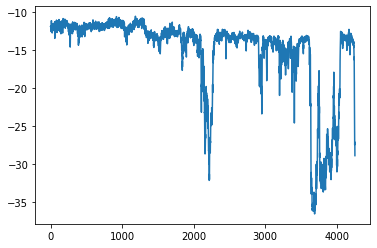

In [6]:
plt.plot(reward_records_)

In [7]:
import misc

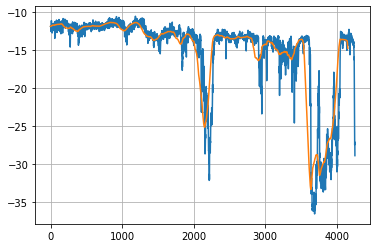

In [8]:
plt.plot(reward_records_)
plt.plot(misc.smooth(reward_records_,100))
plt.grid()


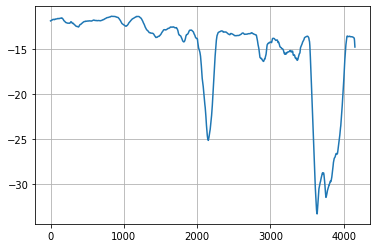

In [9]:
# plt.plot(reward_records_)
plt.plot(misc.smooth(reward_records_,100))
plt.grid()

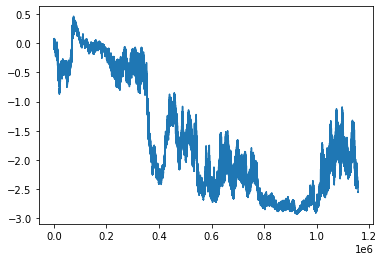

In [10]:
plt.plot(np.array(action_statmean_records).reshape([-1,8])[:,0])

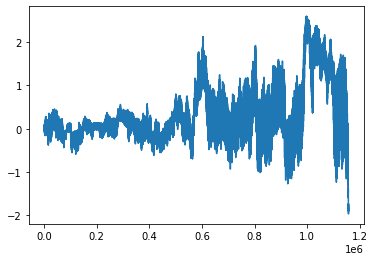

In [11]:
plt.plot(np.array(action_statmean_records).reshape([-1,8])[:,1])

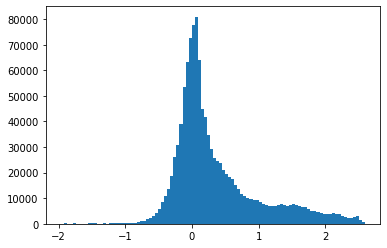

In [12]:
_=plt.hist(np.array(action_statmean_records).reshape([-1,8])[:,1],bins=100)